In [97]:
import os


import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression as LR

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests, rm_anova
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
sparse_mice = stx.ymaze_sess_deets.sparse_mice

plt.rcParams['pdf.fonttype']=42
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
figdir = "C://Users/esay/data/Stx3/YMazeResults/neural/novel_arm_activity"
os.makedirs(figdir, exist_ok=True)

In [98]:
# load session
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
mouse = 'SparseKO_06'
d = sparse_sessions[mouse][5]
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']


pkldir = os.path.join('C://Users/esay/data/Stx3/YMazeSessPkls', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)


In [109]:
baseline_trials

slice(87, 97, None)

In [114]:
baseline_avg_speed = np.nanmean(np.nanmean(sess.trial_matrices['channel_0_speed'][baseline_trials, :speed_max_bin],axis = 0, keepdims=True))

C:\Users\esay\AppData\Local\Temp\ipykernel_61508\505937241.py:1: RuntimeWarning: Mean of empty slice
  baseline_avg_speed = np.nanmean(np.nanmean(sess.trial_matrices['channel_0_speed'][baseline_trials, :speed_max_bin],axis = 0, keepdims=True))


In [115]:
np.nanmean(sess.trial_matrices[speed_key][baseline_trials,:speed_max_bin]/baseline_avg_speed, axis=-1)

array([1.08984121, 0.9168337 , 1.00376878, 1.00834213, 0.87422038,
       1.01663979, 1.01946865, 0.99661657, 1.05549674, 1.02574481])

In [143]:
results = {}
key = 'spks'
ts_key = 'spks'
speed_max_bin = 30
days =6
mice = sparse_mice

for mouse in mice:
    if mouse =='SparseKO_09':
        days = 5
    else:
        days = 6
    results[mouse] = {}
    for day in range(days):

        results[mouse][day] = {}
        d = {} 
        sess = u.load_single_day(mouse, day)


        # # calculate spks norm idk if this will work
        # sess.add_timeseries(channel_0_spks_norm = sess.timeseries['channel_0_spks']/np.nanpercentile(sess.timeseries['channel_0_spks'],99,axis=1,keepdims=True))
        # sess.add_pos_binned_trial_matrix('channel_0_spks_norm')
        # sess.add_timeseries(channel_1_spks_norm = sess.timeseries['channel_1_spks']/np.nanpercentile(sess.timeseries['channel_1_spks'],99,axis=1,keepdims=True))
        # sess.add_pos_binned_trial_matrix('channel_1_spks_norm')
        
        last_block_ind = np.argwhere(sess.trial_info['block_number']==5)[0][0]

        baseline_trials = slice(last_block_ind-10, last_block_ind)

        last_block = sess.trial_info['block_number']==5
        fam_last_block = (sess.trial_info['block_number']==5)*(sess.trial_info['LR']==-1*sess.novel_arm)
        nov_last_block = (sess.trial_info['block_number']==5)*(sess.trial_info['LR']==sess.novel_arm)
        
        
        for chan in ['channel_0', 'channel_1']:
            speed_key = chan + '_speed'

            d = {}

            d['last_block_lr'] = sess.trial_info['LR'][last_block]
            baseline_avg_speed = np.nanmean(np.nanmean(sess.trial_matrices[speed_key][baseline_trials,:speed_max_bin], axis=0, keepdims=True))
                
            d['baseline_speed'] = np.nanmean(sess.trial_matrices[speed_key][baseline_trials,:speed_max_bin]/baseline_avg_speed, axis=-1)
            d['last_block_speed'] = np.nanmean(sess.trial_matrices[speed_key][last_block,:speed_max_bin]/baseline_avg_speed, axis=-1)
            d['fam_speed'] = np.nanmean(sess.trial_matrices[speed_key][fam_last_block,:speed_max_bin]/baseline_avg_speed, axis=-1)
            d['nov_speed'] = np.nanmean(sess.trial_matrices[speed_key][nov_last_block,:speed_max_bin]/baseline_avg_speed, axis=-1)
            
            # baseline_avg_act = np.nanmean(np.nanmean(sess.trial_matrices['spks_norm'][baseline_trials,:,:], axis=0, keepdims=True), axis=1, keepdims=True)
            baseline_avg_act = np.nanmean(np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:,:], axis=0, keepdims=True), axis=1, keepdims=True)

            d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
            d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
            d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
            d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)
            d['fam_mu_act_per_cell'] = np.nanmean(np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=1), axis=0)
            d['nov_mu_act_per_cell'] = np.nanmean(np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=1), axis=0)
            
            results[mouse][day][chan] = d


{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '20_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': -1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': -1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 29, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:42: RuntimeWarning: Mean of empty slice
  baseline_a

{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 32, 'novel_arm': -1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 6, 'novel_arm': -1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:42: RuntimeWarning: Mean of empty slice
  baseline_avg_speed = np.nanmean(np.nanmean(sess.trial_matrices[speed_key][baseline_trials,:speed_max_bin], axis=0, keepdims=True))
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:50: RuntimeWarning: Mean of empty slice
  baseline_avg_act = np.nanmean(np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:,:], axis=0, keepdims=True), axis=1, keepdims=True)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py

{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 7, 'scan': 19, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:42: RuntimeWarning: Mean of empty slice
  baseline_a

{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 5, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:42: RuntimeWarning: Mean of empty slice
  baseline_avg_speed = np.nanmean(np.nanmean(sess.trial_matrices[speed_key][baseline_trials,:speed_max_bin], axis=0, keepdims=True))
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:50: RuntimeWarning: Mean of empty slice
  baseline_avg_act = np.nanmean(np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:,:], axis=0, keepdims=True), axis=1, keepdims=True)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py

{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '01_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 31, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '02_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '03_06_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 10, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '24_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 27, 'novel_arm': 1, 'exp_day': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': 1, 'exp_day': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:42: RuntimeWarning: Mean of empty slice
  baseline_avg_speed = np.nanmean(np.nanmean(sess.trial_matrices[speed_key][baseline_trials,:speed_max_bin], axis=0, keepdims=True))
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:50: RuntimeWarning: Mean of empty slice
  baseline_avg_act = np.nanmean(np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:,:], axis=0, keepdims=True), axis=1, keepdims=True)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:42: RuntimeWarning: Mean of empty slice
  baseline_avg_speed = np.nanmean(np.nanmean(sess.trial_matrices[speed_key][baseline_trials,:speed_max_bin], axis=0, keepdims=True))
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:50: RuntimeWarning: Mean of empty slice
  baseline_avg_act = np.nanmean(np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:,:], axis=0, keepdims=True), axis=1, keepdims=True)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py

{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 22, 'novel_arm': 1, 'exp_day': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:42: RuntimeWarning: Mean of empty slice
  baseline_a

{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': 1, 'exp_day': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:54: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][fam_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:55: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][nov_last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:42: RuntimeWarning: Mean of empty slice
  baseline_a

{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 20, 'novel_arm': 1, 'exp_day': 6}


C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:42: RuntimeWarning: Mean of empty slice
  baseline_avg_speed = np.nanmean(np.nanmean(sess.trial_matrices[speed_key][baseline_trials,:speed_max_bin], axis=0, keepdims=True))
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:50: RuntimeWarning: Mean of empty slice
  baseline_avg_act = np.nanmean(np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:,:], axis=0, keepdims=True), axis=1, keepdims=True)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:52: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][baseline_trials,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py:53: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices[f"{chan}_{ts_key}"][last_block,:, :]/baseline_avg_act, axis=-1)
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3332632646.py

In [137]:
results['SparseKO_06'][0]['channel_0']['fam_act']

array([[0.77797154, 0.81809654, 0.93677872, 1.59437638, 1.56975976,
        1.40286773, 1.38418751, 1.38350345, 1.35829985, 1.33051697,
        1.30095158, 1.3298266 , 1.41693281, 1.31519127, 1.01241045,
        0.95075399, 0.98355315, 1.10275116, 1.40200032, 1.54553332,
        1.61278064, 1.61874773, 1.56397323, 1.29100734, 1.11281999,
        0.93763336, 1.18420059, 1.4426536 , 1.44218741, 1.35898687],
       [0.92155381, 0.72419135, 0.93441853, 0.84559621, 0.82854738,
        0.80452572, 0.86616979, 0.82442407, 1.06211471, 1.30536654,
        1.10118676, 1.02794562, 0.94095797, 0.95315164, 1.07291994,
        1.26763694, 1.3616646 , 1.22738443, 1.19131802, 0.97650679,
        0.90534964, 0.96982636, 1.1885566 , 1.55171345, 1.23552621,
        1.13291359, 1.25934312, 1.58303646, 1.6016852 , 1.39675357],
       [1.30287697, 1.23666346, 1.20183274, 1.20219915, 1.02117853,
        1.08130416, 1.21702752, 1.31897917, 1.49164284, 1.13841621,
        0.86065341, 1.08443339, 1.08913078, 0.

In [138]:
import pickle 
with open('C://Users/esay/data/Stx3/YMazeSessPkls/nov_activity_rate_F_dff.pkl','wb') as file:
        pickle.dump(results,file)

0
1
2
3
4
5


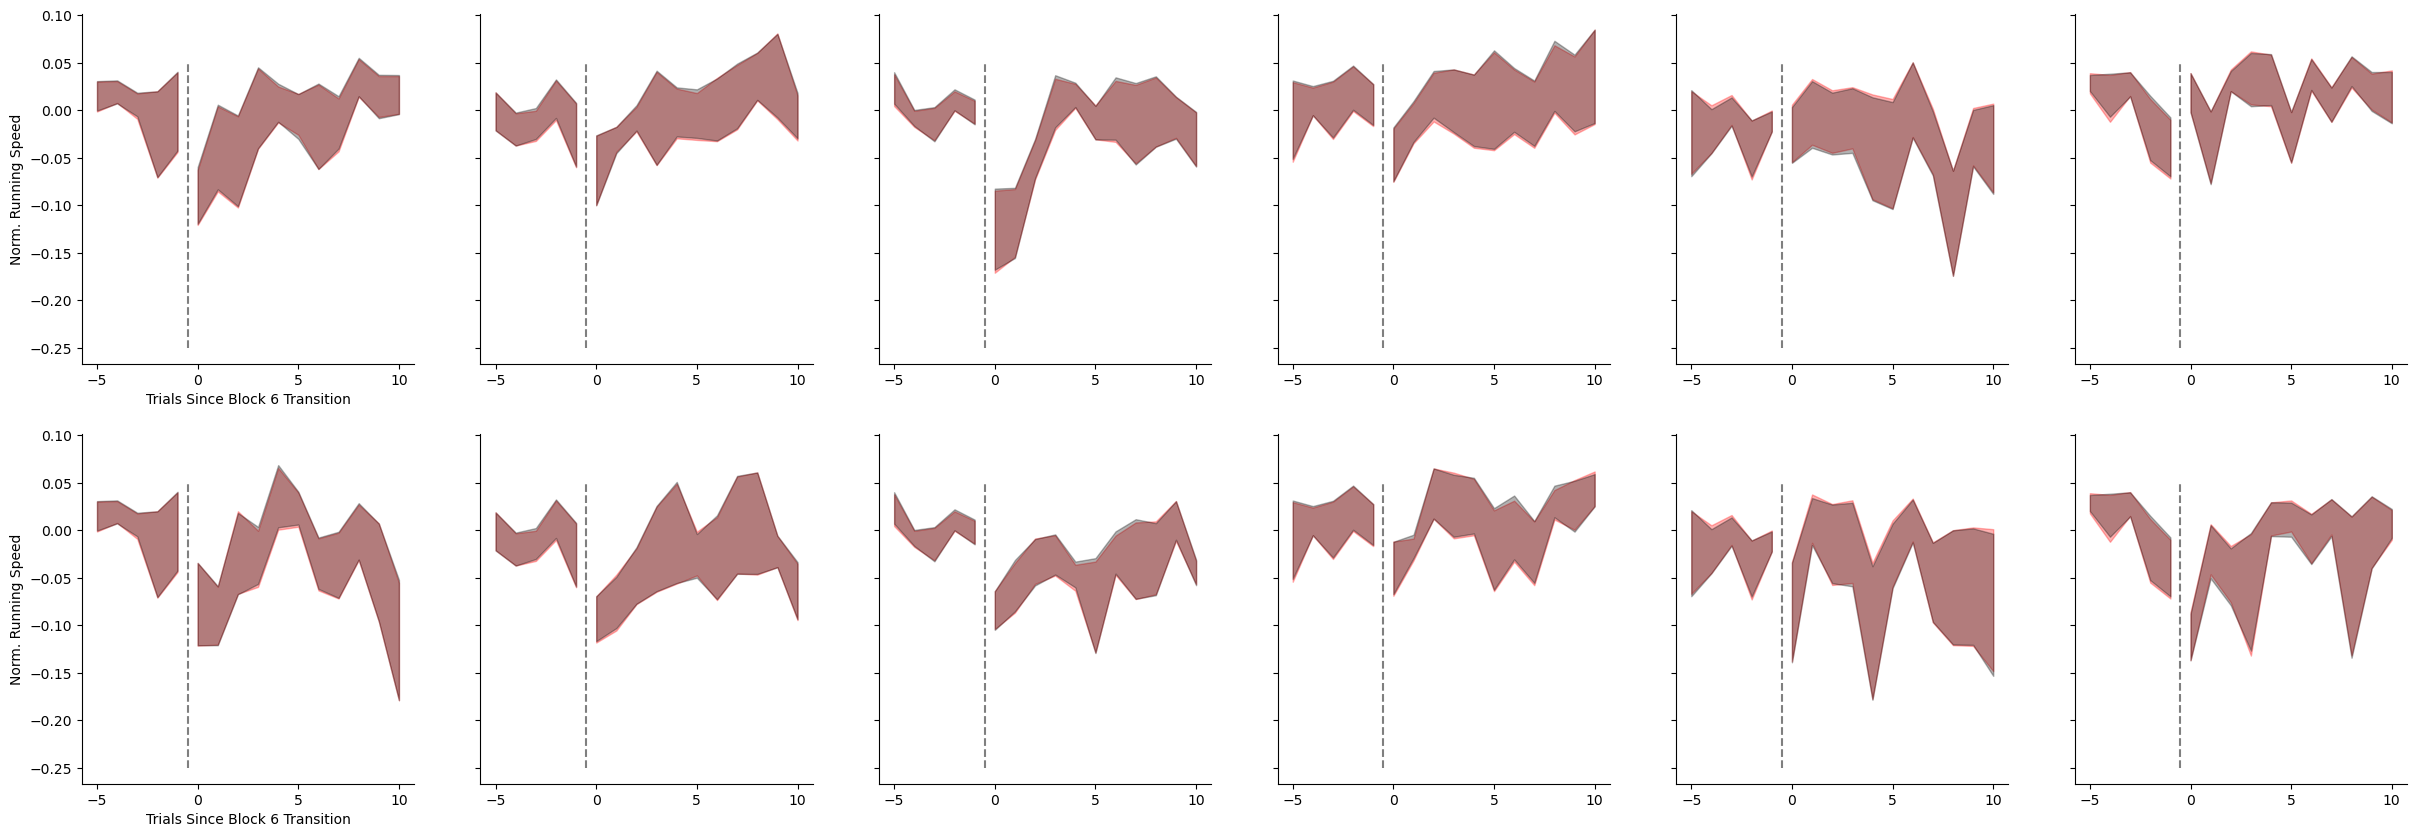

In [142]:
fig,ax = plt.subplots(2,6, figsize = [30, 10],sharey=True)
# ax[0,0].set_ylim([.5,1.2])

n_trials_anova = 2
df = {
      'mouse': [],
      'cond': [],
      'day': [],
      'fam_speed':[],
      'nov_speed': [],
     }

#change  to 6 to include last day
for day in range(6):
    print(day)
    
#      familiar
    ko_base = np.zeros((len(sparse_mice), 5))*np.nan
    ko_fam_speed = np.zeros((len(sparse_mice), 11))*np.nan
    ko_nov_speed = np.zeros((len(sparse_mice), 11))*np.nan
    for m, mouse in enumerate(sparse_mice):
        if mouse == 'SparseKO_09' and day == 2:
            continue
        d = results[mouse][day]['channel_0']
        ko_base[m,:] = np.log10(d['baseline_speed'][-5:])
        
        _speed = np.log10(d['fam_speed'][:11])
        ko_fam_speed[m,:_speed.shape[0]] = _speed[:11]
        
        _speed = np.log10(d['nov_speed'][:11])
        ko_nov_speed[m,:_speed.shape[0]] = _speed[:11]
        
        df['mouse'].append(mouse)
        df['cond'].append('KO')
        df['day'].append(day)
        df['fam_speed'].append(np.log10(np.nanmean(d['fam_speed'][:n_trials_anova])))
        df['nov_speed'].append(np.log10(np.nanmean(d['nov_speed'][:n_trials_anova])))
        # df['fam_speed'].append(np.log10(np.nanmean(d['fam_speed'][:n_trials_anova])))
        # df['nov_speed'].append(np.log10(np.nanmean(d['nov_speed'][:n_trials_anova])))
        
        


    x_base = np.arange(-5,0)
    x_speed = np.arange(0, 11)
    mu_b, sem_b = np.nanmean(ko_base, axis=0), sp.stats.sem(ko_base, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='red', alpha=.3)
    ax[1, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='red', alpha=.3)

    mu_s, sem_s = np.nanmean(ko_fam_speed, axis=0), sp.stats.sem(ko_fam_speed, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_speed, mu_s-sem_s, mu_s+sem_s, color='red', alpha=.3)
    
    mu_s, sem_s = np.nanmean(ko_nov_speed, axis=0), sp.stats.sem(ko_nov_speed, axis=0, nan_policy='omit')
    ax[1, day].fill_between(x_speed, mu_s-sem_s, mu_s+sem_s, color='red', alpha=.3)
    
    
    
 


    ctrl_base = np.zeros((len(sparse_mice), 5))*np.nan
    ctrl_fam_speed = np.zeros((len(sparse_mice), 11))*np.nan
    ctrl_nov_speed = np.zeros((len(sparse_mice), 11))*np.nan
    for m, mouse in enumerate(sparse_mice):
        if mouse == 'SparseKO_09' and day == 2:
            continue
        
        d = results[mouse][day]['channel_1']
        
        ctrl_base[m,:] = np.log10(d['baseline_speed'][-5:])
        
        _speed = np.log10(d['fam_speed'][:11])
        ctrl_fam_speed[m,:_speed.shape[0]] = _speed[:11]
        
        _speed = np.log10(d['nov_speed'][:11])
        ctrl_nov_speed[m,:_speed.shape[0]] = _speed[:11]
        
        df['mouse'].append(mouse)
        df['cond'].append('ctrl')
        df['day'].append(day)
        df['fam_speed'].append(np.log10(np.nanmean(d['fam_speed'][:n_trials_anova])))
        df['nov_speed'].append(np.log10(np.nanmean(d['nov_speed'][:n_trials_anova])))        

    mu_b, sem_b =  np.nanmean(ctrl_base, axis=0), sp.stats.sem(ctrl_base, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='black', alpha=.3)
    ax[1, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='black', alpha=.3)

    mu_s, sem_s =  np.nanmean(ctrl_fam_speed, axis=0), sp.stats.sem(ctrl_fam_speed, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_speed, mu_s-sem_s, mu_s+sem_s, color='black', alpha=.3)
    
    mu_s, sem_s =  np.nanmean(ctrl_nov_speed, axis=0), sp.stats.sem(ctrl_nov_speed, axis=0, nan_policy='omit')
    ax[1, day].fill_between(x_speed, mu_s-sem_s, mu_s+sem_s, color='black', alpha=.3)
    
    

    
    ax[0,day].plot([-.5, -.5],[-.25,.05],'k--', alpha = .5)
    ax[1,day].plot([-.5, -.5],[-.25,.05],'k--', alpha = .5)
    
    ax[0,day].set_xticks([-5, 0, 5, 10])
    ax[1,day].set_xticks([-5, 0, 5, 10])
    
    
    ax[0,day].spines['top'].set_visible(False)
    ax[1,day].spines['top'].set_visible(False)
    
    ax[0,day].spines['right'].set_visible(False)
    ax[1,day].spines['right'].set_visible(False)
    
ax[0,0].set_ylabel('Norm. Running Speed')
ax[0,0].set_xlabel('Trials Since Block 6 Transition')

ax[1,0].set_ylabel('Norm. Running Speed')
ax[1,0].set_xlabel('Trials Since Block 6 Transition')

df = pd.DataFrame(df)

# fig.savefig(os.path.join(figdir,"relative_speed_all_days.pdf"),format='pdf')

In [131]:
df

mouse  cond  day  fam_speed  nov_speed
0   SparseKO_02    KO    0   0.031290   0.013468
1   SparseKO_06    KO    0  -0.184262  -0.167982
2   SparseKO_08    KO    0  -0.006738  -0.027074
3   SparseKO_10    KO    0  -0.071820  -0.077676
4   SparseKO_11    KO    0  -0.099885  -0.164905
..          ...   ...  ...        ...        ...
67  SparseKO_06  ctrl    5   0.025787  -0.057358
68  SparseKO_08  ctrl    5  -0.041345  -0.010984
69  SparseKO_10  ctrl    5   0.065117  -0.147310
70  SparseKO_11  ctrl    5  -0.121517  -0.111574
71  SparseKO_13  ctrl    5   0.013294   0.015859

[72 rows x 5 columns]

In [13]:
aov = mixed_anova(data=df, dv='fam_speed', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df, dv='fam_speed', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)



        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0         cond  0.040129    1   14  0.040129  5.064412  0.041021  0.265647   
1          day  0.098203    5   70  0.019641  4.521404  0.001251  0.244118   
2  Interaction  0.020128    5   70  0.004026  0.926730  0.469043  0.062085   

        eps  
0       NaN  
1  0.576843  
2       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True  0.078510  15.000000   
1          day   -    0     2   True        True -0.428295  15.000000   
2          day   -    0     3   True        True -1.504481  15.000000   
3          day   -    0     4   True        True -2.462619  15.000000   
4          day   -    0     5   True        True -5.097525  15.000000   
5          day   -    1     2   True        True -0.424189  15.000000   
6          day   -    1     3   True        True -1.243903  15.000000   
7          day   -    1     4   True        Tru

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

In [14]:
aov = mixed_anova(data=df, dv='nov_speed', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df, dv='nov_speed', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)


        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0         cond  0.015458    1   14  0.015458  2.364341  0.146426  0.144481   
1          day  0.053264    5   70  0.010653  2.936233  0.018311  0.173370   
2  Interaction  0.009536    5   70  0.001907  0.525696  0.756040  0.036191   

        eps  
0       NaN  
1  0.656587  
2       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -1.353051  15.000000   
1          day   -    0     2   True        True -0.917737  15.000000   
2          day   -    0     3   True        True  0.061592  15.000000   
3          day   -    0     4   True        True -0.735637  15.000000   
4          day   -    0     5   True        True -2.394629  15.000000   
5          day   -    1     2   True        True  0.440870  15.000000   
6          day   -    1     3   True        True  1.679395  15.000000   
7          day   -    1     4   True        Tru

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

In [69]:
df

mouse  cond  day  fam_speed  nov_speed
0   SparseKO_06    KO    0  -0.183117  -0.166396
1   SparseKO_08    KO    0  -0.009643  -0.030057
2   SparseKO_09    KO    0  -0.106854  -0.073637
3   SparseKO_10    KO    0  -0.069947  -0.079806
4   SparseKO_11    KO    0  -0.102795  -0.167889
5   SparseKO_13    KO    0  -0.040091  -0.063019
6   SparseKO_06  ctrl    0  -0.183117  -0.166396
7   SparseKO_08  ctrl    0  -0.009643  -0.030057
8   SparseKO_09  ctrl    0  -0.106854  -0.073637
9   SparseKO_10  ctrl    0  -0.069947  -0.079806
10  SparseKO_11  ctrl    0  -0.102795  -0.167889
11  SparseKO_13  ctrl    0  -0.040091  -0.063019
12  SparseKO_06    KO    1  -0.121750  -0.149008
13  SparseKO_08    KO    1  -0.015652  -0.075954
14  SparseKO_09    KO    1  -0.043164  -0.043060
15  SparseKO_10    KO    1  -0.058220  -0.138284
16  SparseKO_11    KO    1   0.010413  -0.036011
17  SparseKO_13    KO    1  -0.067943  -0.079195
18  SparseKO_06  ctrl    1  -0.121750  -0.149008
19  SparseKO_08  ctrl    1  -0.015652  -0.075954
20  SparseKO_09  ctrl    1  -0.043164  -0.043060
21  SparseKO_10  ctrl    1  -0.058220  -0.138284
22  SparseKO_11  ctrl    1   0.010413  -0.036011
23  SparseKO_13  ctrl    1  -0.067943  -0.079195
24  SparseKO_06    KO    2  -0.079975  -0.075003
25  SparseKO_08    KO    2  -0.213730  -0.028285
26  SparseKO_10    KO    2  -0.209713  -0.059391
27  SparseKO_11    KO    2  -0.076213  -0.091407
28  SparseKO_13    KO    2  -0.042175  -0.034279
29  SparseKO_06  ctrl    2  -0.079975  -0.075003
30  SparseKO_08  ctrl    2  -0.213730  -0.028285
31  SparseKO_10  ctrl    2  -0.209713  -0.059391
32  SparseKO_11  ctrl    2  -0.076213  -0.091407
33  SparseKO_13  ctrl    2  -0.042175  -0.034279
34  SparseKO_06    KO    3  -0.067313  -0.077528
35  SparseKO_08    KO    3  -0.077041  -0.003389
36  SparseKO_09    KO    3  -0.065958  -0.206564
37  SparseKO_10    KO    3   0.007582  -0.023658
38  SparseKO_11    KO    3  -0.078486   0.002641
39  SparseKO_13    KO    3   0.039273   0.008122
40  SparseKO_06  ctrl    3  -0.067313  -0.077528
41  SparseKO_08  ctrl    3  -0.077041  -0.003389
42  SparseKO_09  ctrl    3  -0.065958  -0.206564
43  SparseKO_10  ctrl    3   0.007582  -0.023658
44  SparseKO_11  ctrl    3  -0.078486   0.002641
45  SparseKO_13  ctrl    3   0.039273   0.008122
46  SparseKO_06    KO    4   0.019427   0.025118
47  SparseKO_08    KO    4  -0.053307  -0.007586
48  SparseKO_09    KO    4  -0.129400  -0.214597
49  SparseKO_10    KO    4  -0.012917  -0.110020
50  SparseKO_11    KO    4  -0.071543  -0.071401
51  SparseKO_13    KO    4   0.072707   0.024479
52  SparseKO_06  ctrl    4   0.019427   0.025118
53  SparseKO_08  ctrl    4  -0.053307  -0.007586
54  SparseKO_09  ctrl    4  -0.129400  -0.214597
55  SparseKO_10  ctrl    4  -0.012917  -0.110020
56  SparseKO_11  ctrl    4  -0.071543  -0.071401
57  SparseKO_13  ctrl    4   0.072707   0.024479

In [68]:
mask = (df['cond']=='ctrl') & (df['day']==day) 
lr = df['fam_speed'].loc[mask]._values

lr

array([ 0.01942686, -0.05330745, -0.12940028, -0.01291688, -0.07154345,
        0.07270712])

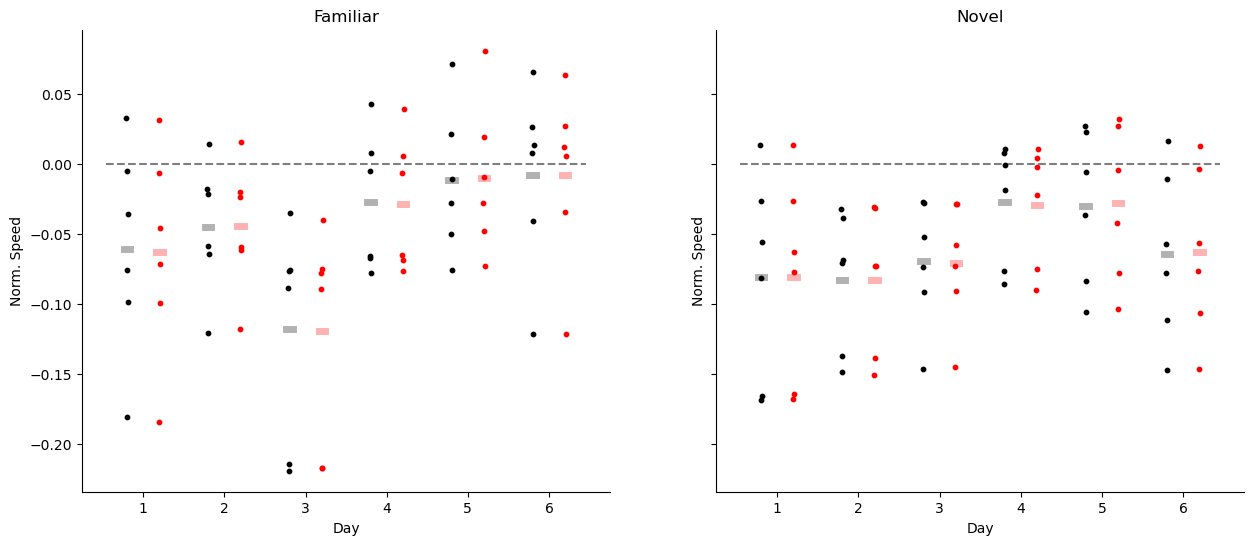

In [132]:
fig, ax = plt.subplots(1,2, figsize=[15,6], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) 
    lr = df['fam_speed'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), np.nanmean(lr)*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) 
    lr = df['nov_speed'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), np.nanmean(lr)*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='KO') & (df['day']==day) 
    lr = df['fam_speed'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), np.nanmean(lr)*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='KO') & (df['day']==day)
    lr = df['nov_speed'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), np.nanmean(lr)*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
ax[0].plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)
ax[1].plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)
    
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Norm. Speed')
    ax[a].set_xlabel('Day')
    
# fig.savefig(os.path.join(figdir,"relative_speed_summary.pdf"),format='pdf')

In [9]:

print(results['cre'][0][ko_mice[0]].keys())
results['cre'][0][ko_mice[0]]['fam_act'].shape

dict_keys(['last_block_lr', 'baseline_speed', 'last_block_speed', 'fam_speed', 'nov_speed', 'baseline_act', 'last_block_act', 'fam_act', 'nov_act', 'fam_mu_act_per_cell', 'nov_mu_act_per_cell'])


(19, 30)

In [133]:
def plot_sess_act(cond, day, mouse, vmin=-.4, vmax=.4):

    fig = plt.figure()
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, .1], height_ratios=[1, 1], wspace=.5)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    cbar_ax = fig.add_subplot(gs[0,2])

    d = results[day][mouse][cond]
    print(np.isnan(d['last_block_act']).sum())
    # h = ax1.imshow(np.log10(np.concatenate((d['baseline_act'],d['last_block_act']), axis=0)), vmin=vmin, vmax=vmax, cmap='PuOr')
    h = ax1.imshow(np.concatenate((d['baseline_act'],d['last_block_act'])), vmin=vmin, vmax=vmax, cmap='PuOr')
    ax1.set_title('All Trials')
    nrows = d['baseline_act'].shape[0]+d['last_block_act'].shape[0]
    ax1.set_yticks(np.arange(0, nrows, 10), labels= np.arange(-10,nrows-10,10))
    ax1.set_ylabel('Trial')
    ax1.set_xlabel('Position')
    ax1.set_xticks([0, 10, 20, 30], [0, 100, 200, 300])


    ax2.imshow(np.log10(d['fam_act']), vmin=vmin, vmax=vmax, cmap='PuOr')
    ax2.set_title('Familiar Trials')
    ax2.set_yticks(np.arange(0,d['fam_act'].shape[0],10))
    ax2.set_xticks([0, 10, 20, 30], [0, 100, 200, 300])


    ax3.imshow(np.log10(d['nov_act']), vmin=vmin, vmax=vmax, cmap='PuOr')
    ax3.set_title('Novel Trials')
    ax3.set_yticks(np.arange(0,d['nov_act'].shape[0],10))
    ax3.set_xticks([0, 10, 20, 30], [0, 100, 200, 300])

    fig.colorbar(h,cbar_ax)
    fig.suptitle(f'mouse: {mouse}, day: {day}')
    
    fig.savefig(os.path.join(figdir,f"nov_act_{mouse}_day{day}.pdf"),format='pdf')


20
12


/tmp/ipykernel_2696826/1105578615.py:22: RuntimeWarning: invalid value encountered in log10
  ax2.imshow(np.log10(d['fam_act']), vmin=vmin, vmax=vmax, cmap='PuOr')
/tmp/ipykernel_2696826/1105578615.py:28: RuntimeWarning: invalid value encountered in log10
  ax3.imshow(np.log10(d['nov_act']), vmin=vmin, vmax=vmax, cmap='PuOr')


18
21
9
25
13
17
18
15
11
21
15
13
10
11
11
17


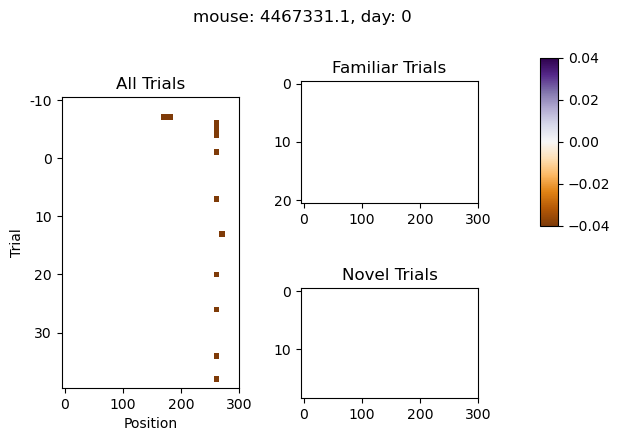

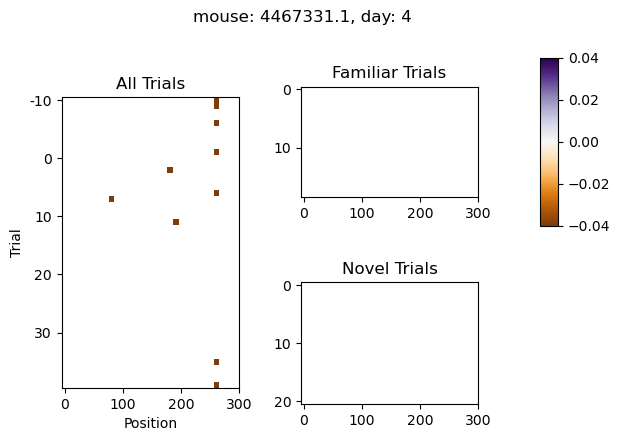

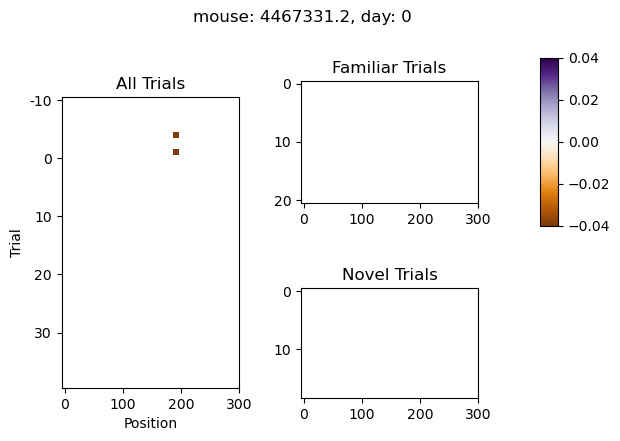

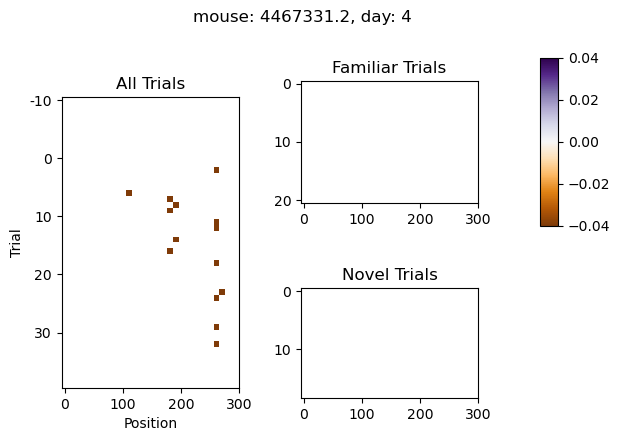

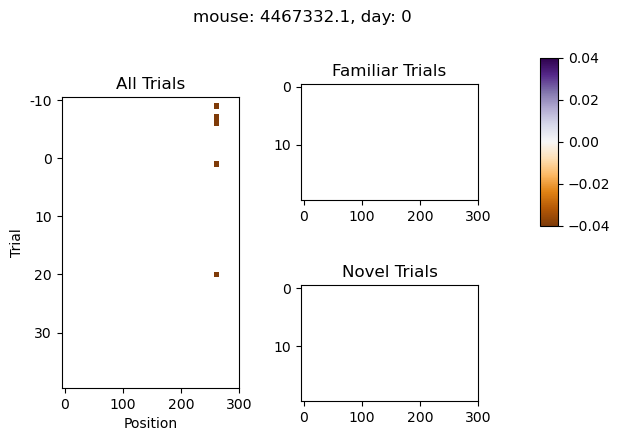

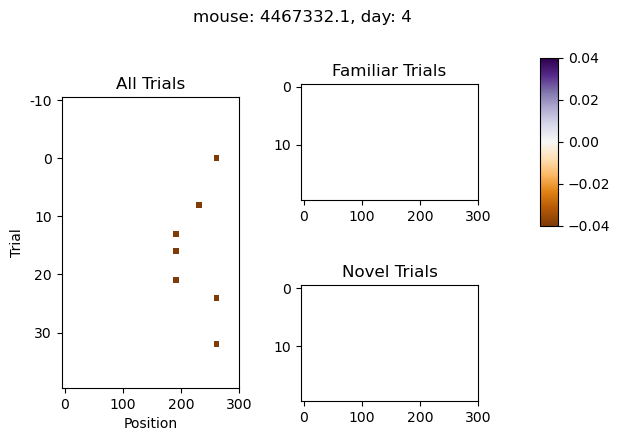

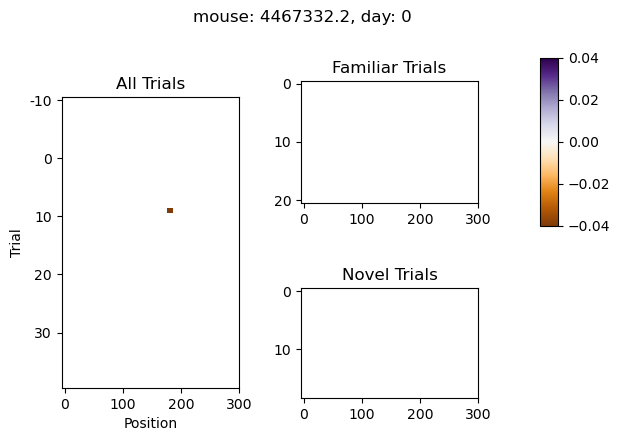

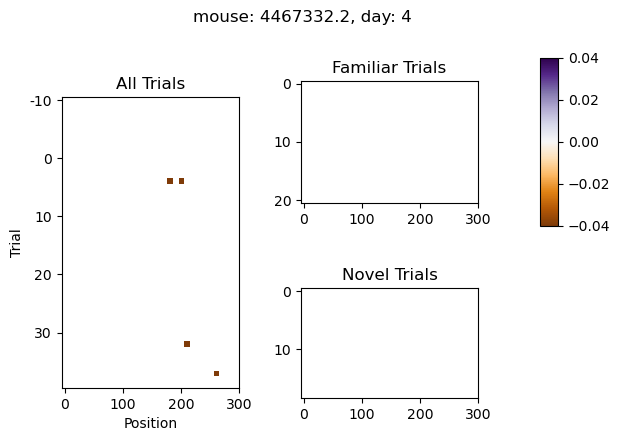

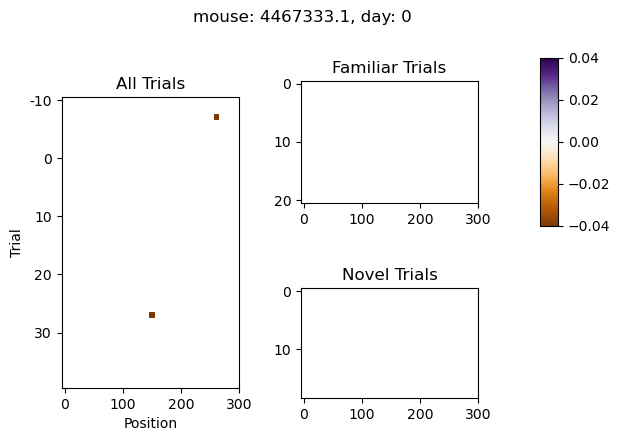

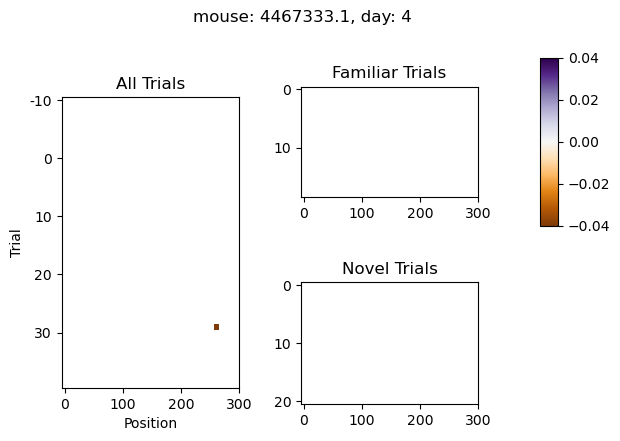

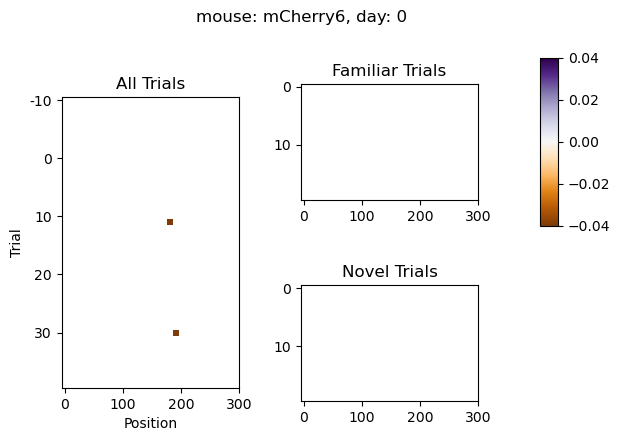

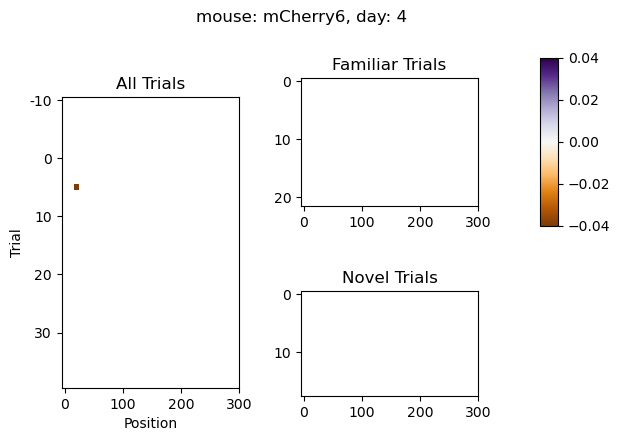

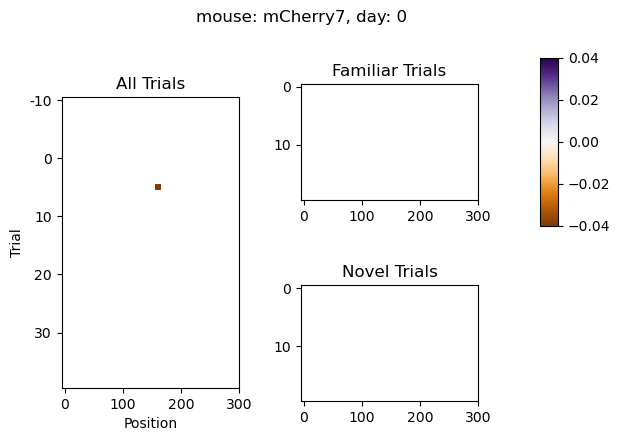

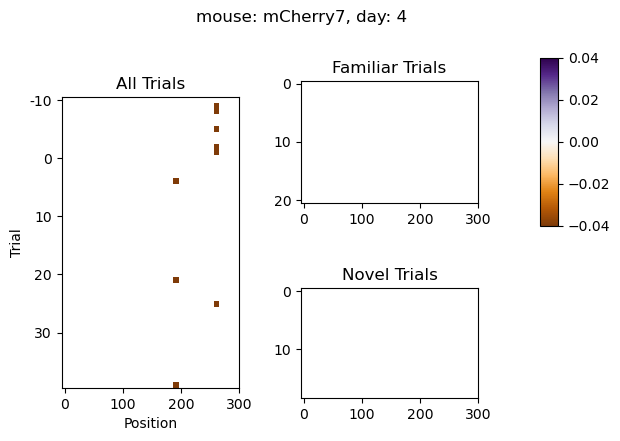

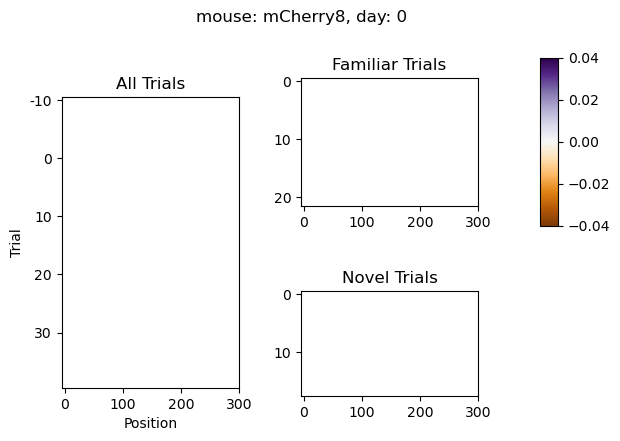

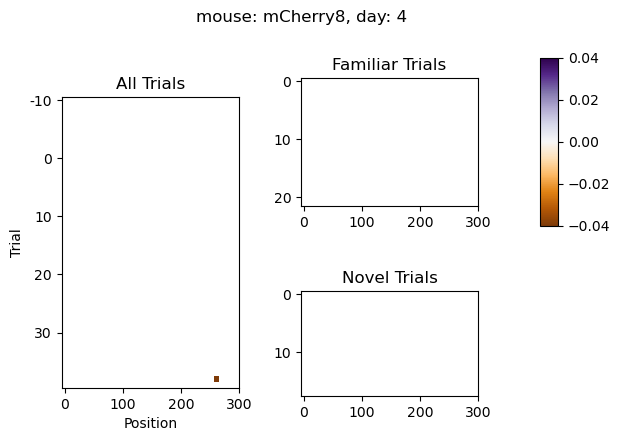

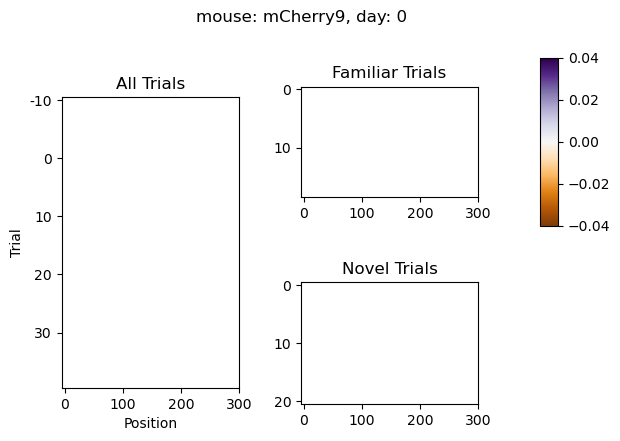

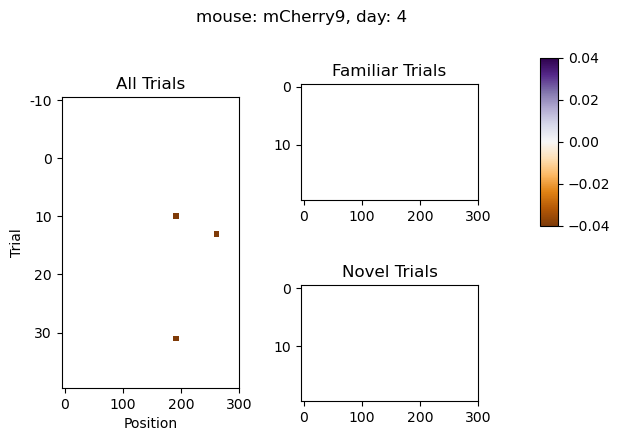

In [12]:
for mouse in ctrl_mice:
    # mouse = ctrl_mice[0]
    plot_sess_act('ctrl', 0, mouse)
    plot_sess_act('ctrl', 4, mouse)

/tmp/ipykernel_2696826/1955802889.py:21: RuntimeWarning: invalid value encountered in log10
  ax2.imshow(np.log10(d['fam_act']), vmin=vmin, vmax=vmax, cmap='PuOr')
/tmp/ipykernel_2696826/1955802889.py:27: RuntimeWarning: invalid value encountered in log10
  ax3.imshow(np.log10(d['nov_act']), vmin=vmin, vmax=vmax, cmap='PuOr')


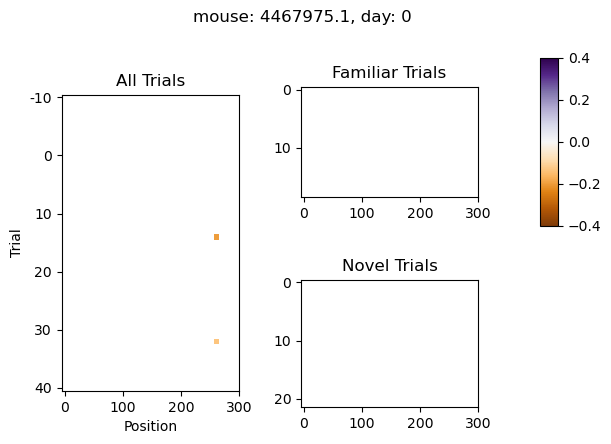

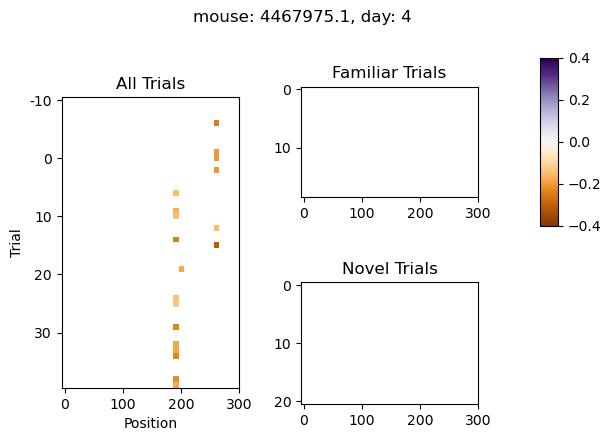

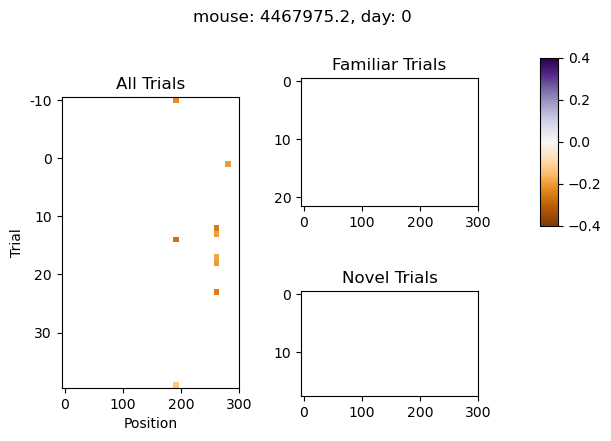

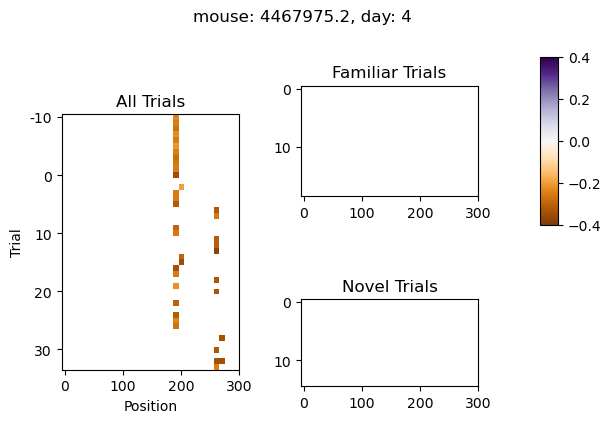

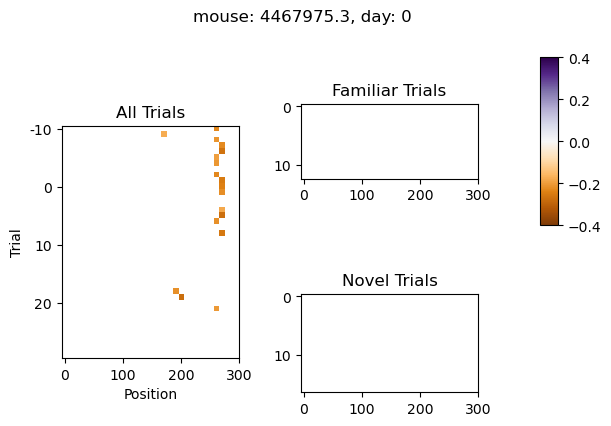

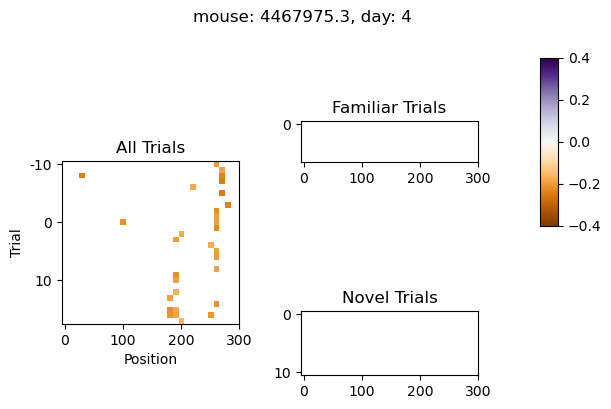

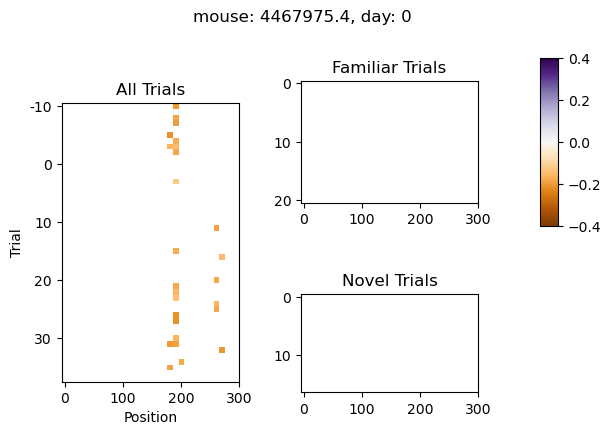

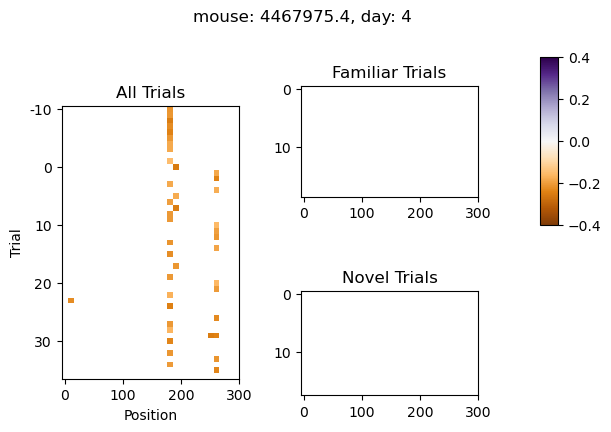

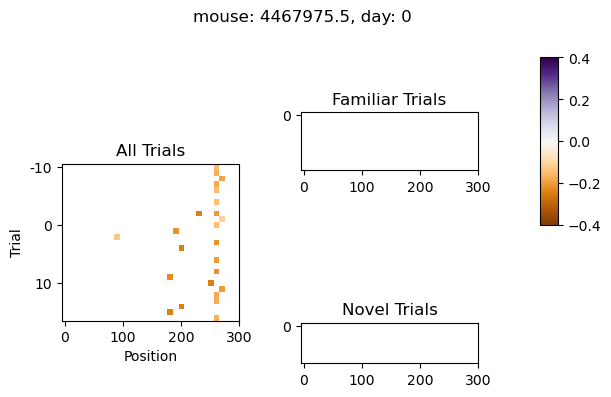

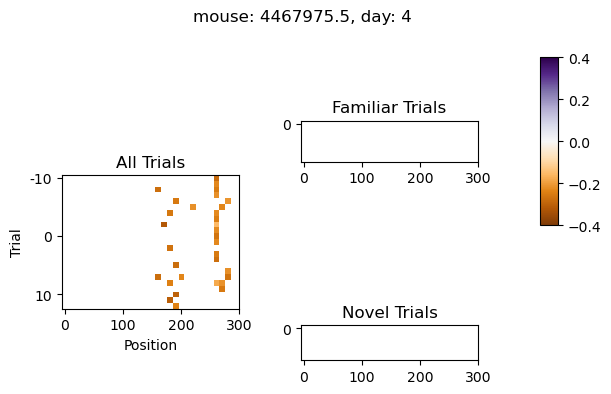

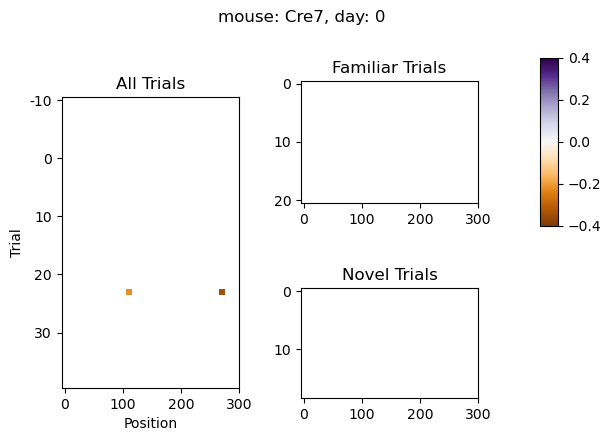

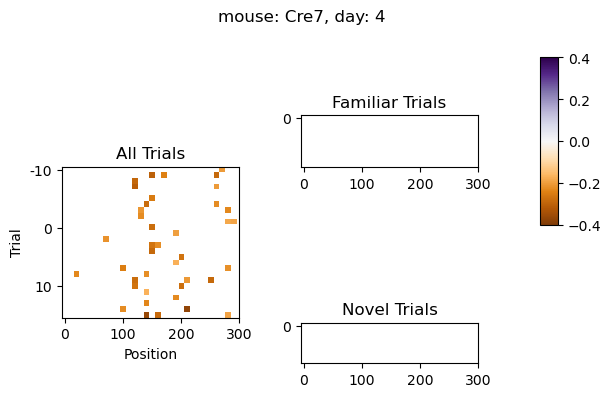

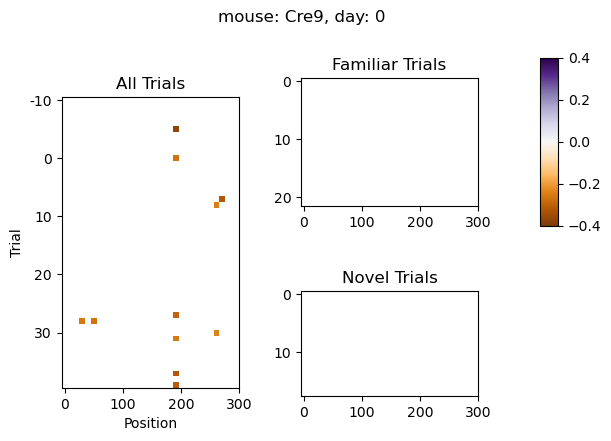

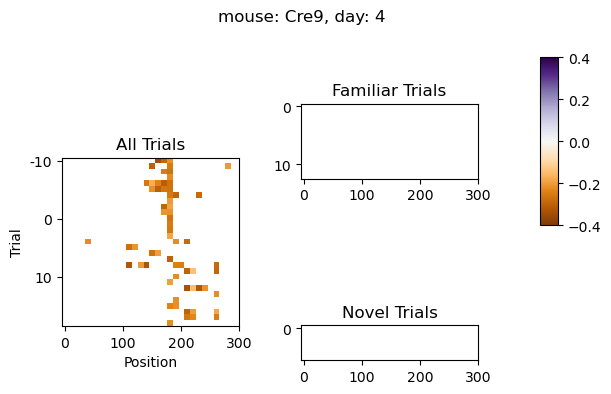

In [10]:
for mouse in ko_mice:
    plot_sess_act('cre', 0, mouse)
    plot_sess_act('cre', 4, mouse)

C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3664479589.py:52: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  mu_b, sem_b = np.nanmean(ko_base, axis=0), sp.stats.sem(ko_base, axis=0, nan_policy='omit')
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3664479589.py:99: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  mu_b, sem_b = np.nanmean(ctrl_base, axis=0), sp.stats.sem(ctrl_base, axis=0, nan_policy='omit')
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\3664479589.py:52: RuntimeWarning: Mean of empty slice
  mu_b, sem_b = np.nanmean(ko_base, axis=0), sp.stats.sem(ko_base, axis=0, nan_policy='omit')
C:\Users\esay\AppData\Local\Temp\ipykernel_61508\

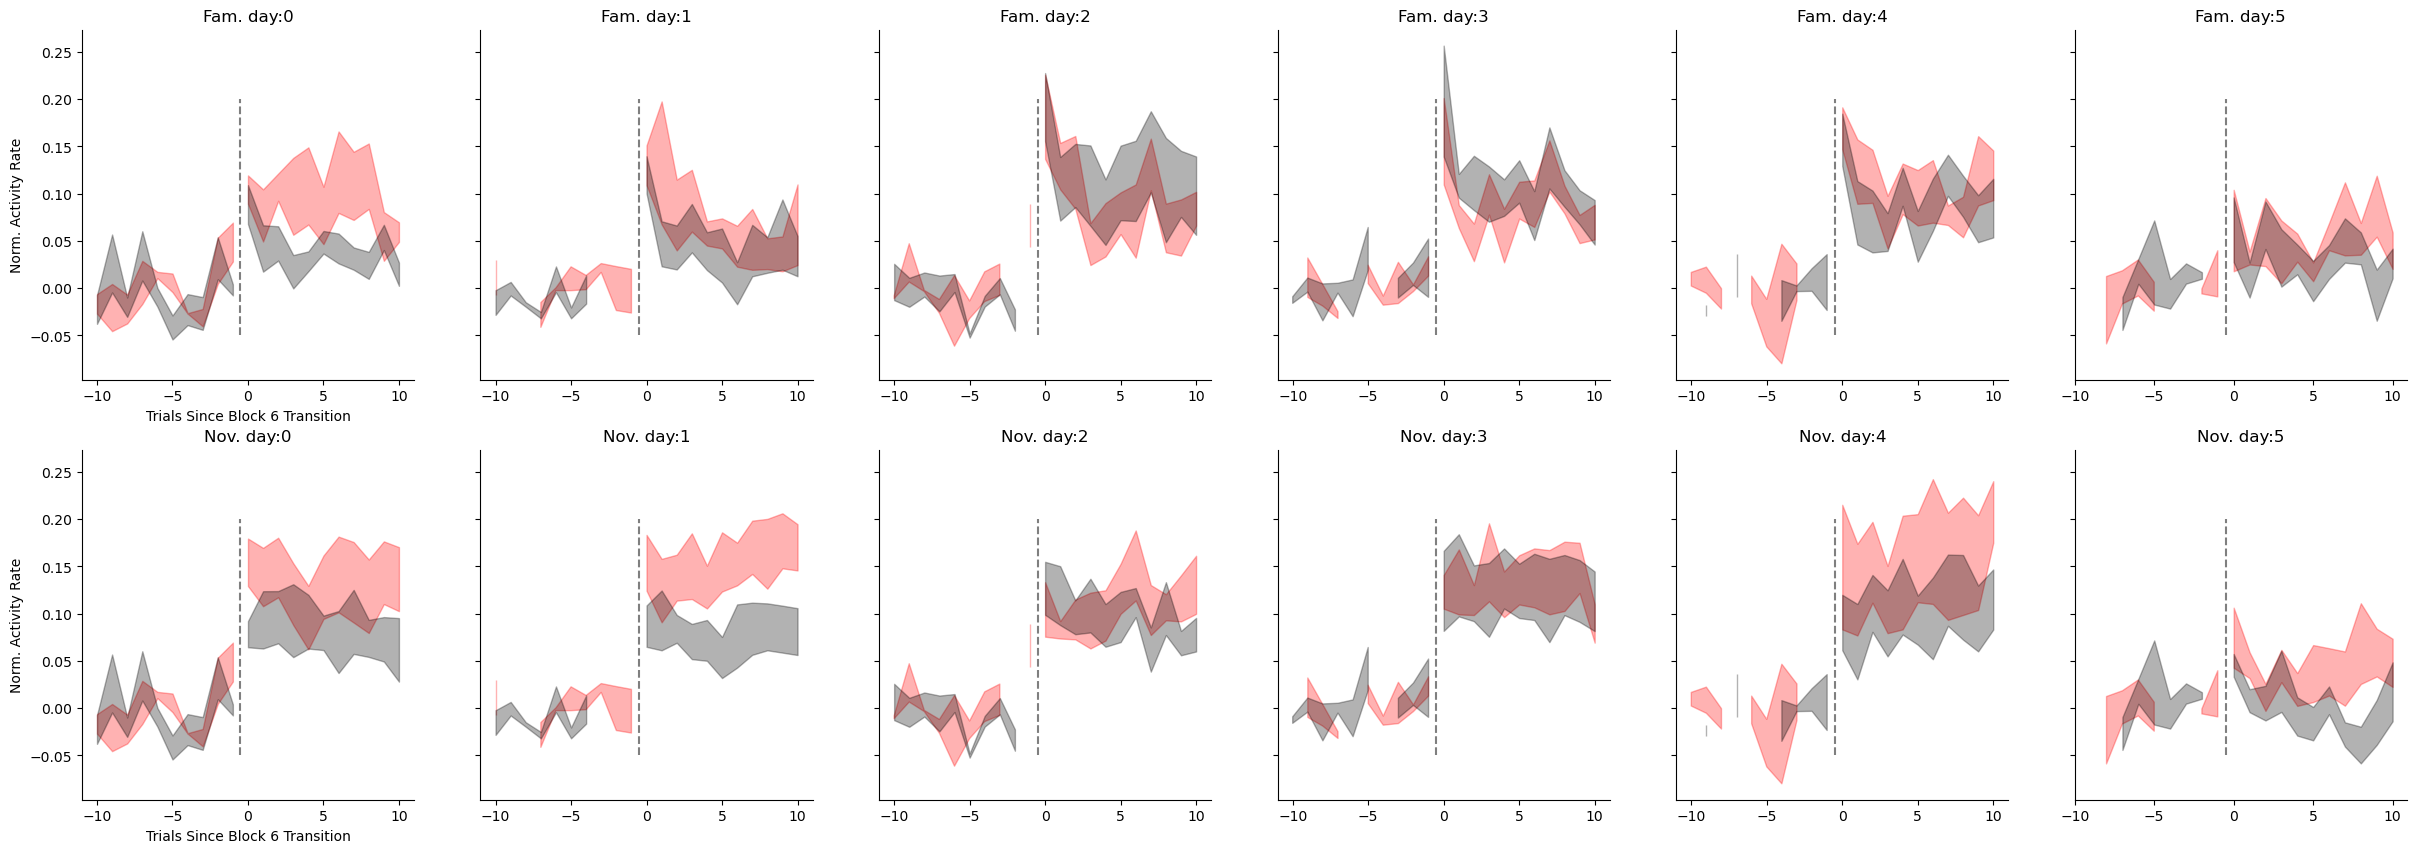

In [144]:
fig,ax = plt.subplots(2,6, figsize = [30, 10],sharey=True)
# ax[0,0].set_ylim([.5,1.2])


df = {
      'mouse': [],
      'cond': [],
      'day': [],
      'fam/nov': [],
      'act':[],
     }

for day in range(6):

    ko_base = np.zeros((len(sparse_mice), 10))*np.nan
    ko_fam_act = np.zeros((len(sparse_mice), 11))*np.nan
    ko_nov_act = np.zeros((len(sparse_mice), 11))*np.nan
    for m, mouse in enumerate(sparse_mice):
        if mouse =='SparseKO_09' and day == 2:
            continue
        d = results[mouse][day]['channel_0']
        ko_base[m,:] = np.log10(d['baseline_act'][-10:,:].mean(axis=-1))
        
        _act = np.log10(np.nanmean(d['fam_act'][:11,:],axis=-1))
        ko_fam_act[m,:_act.shape[0]] = _act[:11]
        
        _act = np.log10(np.nanmean(d['nov_act'][:11,:],axis=-1))
        ko_nov_act[m,:_act.shape[0]] = _act[:11]
        
        df['mouse'].append(mouse)
        df['cond'].append('KO')
        df['day'].append(day)
        df['fam/nov'].append('fam')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
        
        df['mouse'].append(mouse)
        df['cond'].append('KO')
        df['day'].append(day)
        df['fam/nov'].append('nov')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))))
        
        df['mouse'].append(mouse)
        df['cond'].append('KO')
        df['day'].append(day)
        df['fam/nov'].append('diff')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))) - np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
        
                         

    x_base = np.arange(-10,0)
    x_act = np.arange(0, 11)
    mu_b, sem_b = np.nanmean(ko_base, axis=0), sp.stats.sem(ko_base, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='red', alpha=.3)
    ax[1, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='red', alpha=.3)

    mu_s, sem_s = np.nanmean(ko_fam_act, axis=0), sp.stats.sem(ko_fam_act, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_act, mu_s-sem_s, mu_s+sem_s, color='red', alpha=.3)
    
    mu_s, sem_s = np.nanmean(ko_nov_act, axis=0), sp.stats.sem(ko_nov_act, axis=0, nan_policy='omit')
    ax[1, day].fill_between(x_act, mu_s-sem_s, mu_s+sem_s, color='red', alpha=.3)
    
                         
    ctrl_base = np.zeros((len(sparse_mice), 10))*np.nan
    ctrl_fam_act = np.zeros((len(sparse_mice), 11))*np.nan
    ctrl_nov_act = np.zeros((len(sparse_mice), 11))*np.nan
    for m, mouse in enumerate(sparse_mice):
        if mouse =='SparseKO_09' and day == 2:
            continue
        d = results[mouse][day]['channel_1']
        ctrl_base[m,:] = np.log10(d['baseline_act'][-10:,:].mean(axis=-1))
        
        _act = np.log10(np.nanmean(d['fam_act'][:11,:],axis=-1))
        ctrl_fam_act[m,:_act.shape[0]] = _act[:11]
        
        _act = np.log10(np.nanmean(d['nov_act'][:11,:],axis=-1))
        ctrl_nov_act[m,:_act.shape[0]] = _act[:11]
        
        df['mouse'].append(mouse)
        df['cond'].append('ctrl')
        df['day'].append(day)
        df['fam/nov'].append('fam')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
        
        df['mouse'].append(mouse)
        df['cond'].append('ctrl')
        df['day'].append(day)
        df['fam/nov'].append('nov')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))))
        
        df['mouse'].append(mouse)
        df['cond'].append('ctrl')
        df['day'].append(day)
        df['fam/nov'].append('diff')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))) - np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
                         

    x_base = np.arange(-10,0)
    x_act = np.arange(0, 11)
    mu_b, sem_b = np.nanmean(ctrl_base, axis=0), sp.stats.sem(ctrl_base, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='black', alpha=.3)
    ax[1, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='black', alpha=.3)

    mu_s, sem_s = np.nanmean(ctrl_fam_act, axis=0), sp.stats.sem(ctrl_fam_act, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_act, mu_s-sem_s, mu_s+sem_s, color='black', alpha=.3)
    
    mu_s, sem_s = np.nanmean(ctrl_nov_act, axis=0), sp.stats.sem(ctrl_nov_act, axis=0, nan_policy='omit')
    ax[1, day].fill_between(x_act, mu_s-sem_s, mu_s+sem_s, color='black', alpha=.3)
    
    
 



    
    ax[0,day].plot([-.5, -.5],[-.05,.2],'k--', alpha = .5)
    ax[1,day].plot([-.5, -.5],[-.05,.2],'k--', alpha = .5)
    
    ax[0,day].set_xticks([-10, -5, 0, 5, 10])
    ax[1,day].set_xticks([-10, -5, 0, 5, 10])
    
    ax[0, day].set_title(f'Fam. day:{day}')
    ax[1, day].set_title(f'Nov. day:{day}')
    
    ax[0,day].spines['top'].set_visible(False)
    ax[1,day].spines['top'].set_visible(False)
    
    ax[0,day].spines['right'].set_visible(False)
    ax[1,day].spines['right'].set_visible(False)
    
ax[0,0].set_ylabel('Norm. Activity Rate')
ax[0,0].set_xlabel('Trials Since Block 6 Transition')

ax[1,0].set_ylabel('Norm. Activity Rate')
ax[1,0].set_xlabel('Trials Since Block 6 Transition')

df = pd.DataFrame(df)

# fig.savefig(os.path.join(figdir,"log_activity_rate_all_days.pdf"),format='pdf')

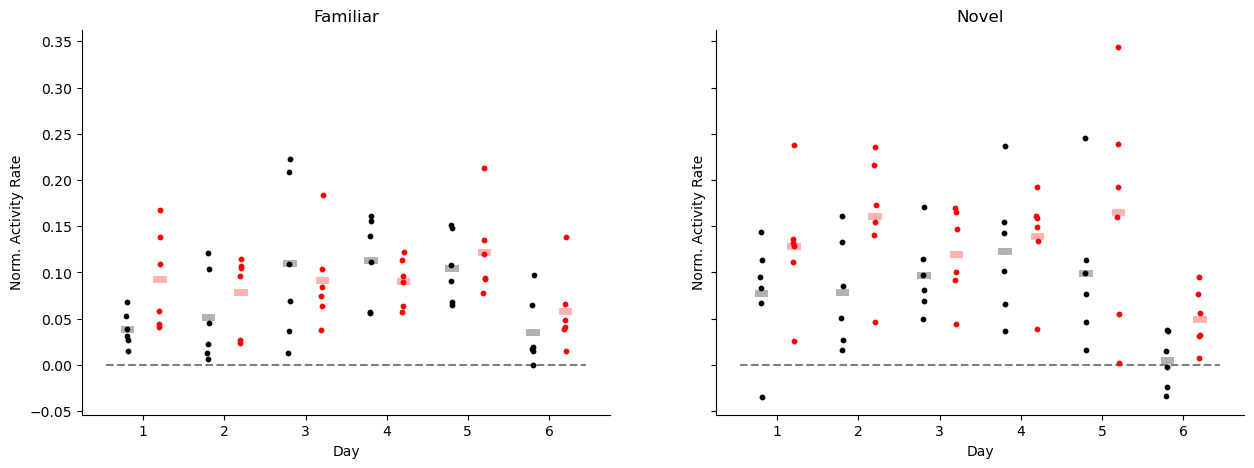

In [135]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['fam/nov']=='fam')
    lr = df['act'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), np.nanmean(lr)*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['fam/nov']=='nov')
    lr = df['act'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), np.nanmean(lr)*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='KO') & (df['day']==day) & (df['fam/nov']=='fam')
    lr = df['act'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), np.nanmean(lr)*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='KO') & (df['day']==day) & (df['fam/nov']=='nov')
    lr = df['act'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), np.nanmean(lr)*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
ax[0].plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)
ax[1].plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)
    
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Norm. Activity Rate')
    ax[a].set_xlabel('Day')
    
# fig.savefig(os.path.join(figdir,"log_activity_rate_summary.pdf"),format='pdf')

In [10]:
_df = df[(df['fam/nov']=='fam') & (df['day']<5)]
aov = mixed_anova(data=_df, dv='act', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=_df, dv='act', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0         cond  0.058528    1   14  0.058528  16.625034  0.001131  0.542858   
1          day  0.003232    4   56  0.000808   0.944286  0.445288  0.063187   
2  Interaction  0.003448    4   56  0.000862   1.007151  0.411617  0.067111   

        eps  
0       NaN  
1  0.580321  
2       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True  0.020304  15.000000   
1          day   -    0     2   True        True  0.741543  15.000000   
2          day   -    0     3   True        True -1.076926  15.000000   
3          day   -    0     4   True        True -0.441410  15.000000   
4          day   -    1     2   True        True  1.040791  15.000000   
5          day   -    1     3   True        True -1.249133  15.000000   
6          day   -    1     4   True        True -0.666977  15.000000   
7          day   -    2     3   True       

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

In [11]:
_df = df[(df['fam/nov']=='nov') & (df['day']<5)]
aov = mixed_anova(data=_df, dv='act', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=_df, dv='act', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0         cond  0.112224    1   14  0.112224  37.487895  0.000026  0.728091   
1          day  0.015337    4   56  0.003834   4.137792  0.005245  0.228131   
2  Interaction  0.005946    4   56  0.001486   1.604044  0.186032  0.102797   

        eps  
0       NaN  
1  0.637562  
2       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -0.595000  15.000000   
1          day   -    0     2   True        True -0.668087  15.000000   
2          day   -    0     3   True        True -2.670840  15.000000   
3          day   -    0     4   True        True -2.796059  15.000000   
4          day   -    1     2   True        True -0.198314  15.000000   
5          day   -    1     3   True        True -2.653200  15.000000   
6          day   -    1     4   True        True -4.222641  15.000000   
7          day   -    2     3   True       

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

SparseKO_06
SparseKO_08
SparseKO_09
SparseKO_10
SparseKO_11
SparseKO_13
SparseKO_06
SparseKO_08
SparseKO_09
SparseKO_10
SparseKO_11
SparseKO_13
SparseKO_06
SparseKO_08
SparseKO_09
SparseKO_10
SparseKO_11
SparseKO_13
SparseKO_06
SparseKO_08
SparseKO_09
SparseKO_10
SparseKO_11
SparseKO_13
SparseKO_06
SparseKO_08
SparseKO_09
SparseKO_10
SparseKO_11
SparseKO_13


Text(0.5, 0, 'Day')

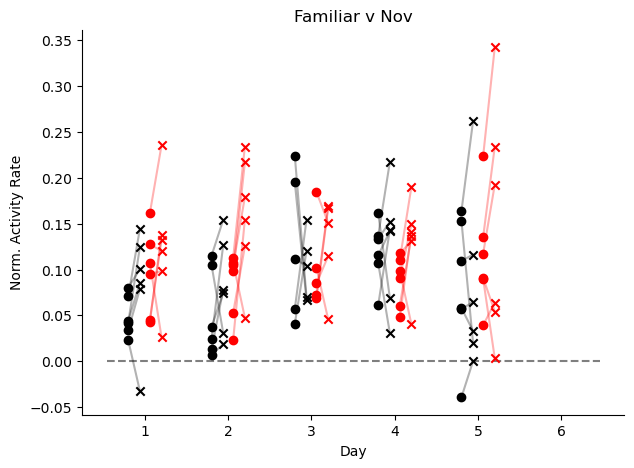

In [80]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(5):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in sparse_mice:
        print(mouse)
        if mouse == 'SparseKO_09' and day ==2:
            continue
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['act'].loc[_df['fam/nov']=='fam']._values, _df['act'].loc[_df['fam/nov']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='KO') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in sparse_mice:
        if mouse == 'SparseKO_09' and day ==2:
            continue
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['act'].loc[_df['fam/nov']=='fam']._values, _df['act'].loc[_df['fam/nov']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')

ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Norm. Activity Rate')
ax.set_xlabel('Day')
    
# fig.savefig(os.path.join(figdir,"log_activity_rate_summary_within_group.pdf"),format='pdf')

In [13]:
_df = df[(df['fam/nov']=='diff') & (df['day']<5)]
aov = mixed_anova(data=_df, dv='act', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=_df, dv='act', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0         cond  0.008663    1   14  0.008663  8.131281  0.012811  0.367411   
1          day  0.008087    4   56  0.002022  6.313330  0.000289  0.310797   
2  Interaction  0.000568    4   56  0.000142  0.443371  0.776724  0.030697   

        eps  
0       NaN  
1  0.849149  
2       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -1.109065  15.000000   
1          day   -    0     2   True        True -2.685491  15.000000   
2          day   -    0     3   True        True -3.058129  15.000000   
3          day   -    0     4   True        True -5.427120  15.000000   
4          day   -    1     2   True        True -1.828870  15.000000   
5          day   -    1     3   True        True -2.298126  15.000000   
6          day   -    1     4   True        True -2.943616  15.000000   
7          day   -    2     3   True        Tru

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.product(eig) / (eig.sum() / d) ** d
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.

In [14]:
from pingouin import rm_anova
_df = df[(df['cond']=='ctrl') & (df['day']<5) & (df['fam/nov']!='diff')]
aov = rm_anova(data=_df, dv='act', within=['day', 'fam/nov'], subject='mouse')
print(aov)

posthoc = pairwise_tests(data=_df, dv='act', within=['day', 'fam/nov'], subject='mouse', padjust = 'holm')
print(posthoc)

          Source        SS  ddof1  ddof2        MS           F     p-unc  \
0            day  0.013749      4     32  0.003437    1.998430  0.118460   
1        fam/nov  0.067044      1      8  0.067044  145.790605  0.000002   
2  day * fam/nov  0.003380      4     32  0.000845    5.086802  0.002745   

   p-GG-corr       ng2       eps  
0   0.180120  0.098655  0.394694  
1   0.000002  0.347998  1.000000  
2   0.005520  0.026201  0.819279  
         Contrast day    A    B Paired  Parametric          T  dof  \
0             day   -    0    1   True        True  -1.653068  8.0   
1             day   -    0    2   True        True  -2.362161  8.0   
2             day   -    0    3   True        True  -1.946830  8.0   
3             day   -    0    4   True        True  -1.809989  8.0   
4             day   -    1    2   True        True   0.101193  8.0   
5             day   -    1    3   True        True  -1.162776  8.0   
6             day   -    1    4   True        True  -1.554888  8.

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always settin

In [15]:
from pingouin import rm_anova
_df = df[(df['cond']=='cre') & (df['day']<5) & (df['fam/nov']!='diff')]
aov = rm_anova(data=_df, dv='act', within=['day', 'fam/nov'], subject='mouse')
print(aov)

posthoc = pairwise_tests(data=_df, dv='act', within=['day', 'fam/nov'], subject='mouse', padjust = 'holm')
print(posthoc)

          Source        SS  ddof1  ddof2        MS          F     p-unc  \
0            day  0.009887      4     24  0.002472   1.656420  0.192904   
1        fam/nov  0.019769      1      6  0.019769  31.392078  0.001377   
2  day * fam/nov  0.000948      4     24  0.000237   1.557396  0.217792   

   p-GG-corr       ng2       eps  
0   0.241136  0.131320  0.362635  
1   0.001377  0.232113  1.000000  
2   0.253509  0.014284  0.444481  
         Contrast day    A    B Paired  Parametric         T  dof alternative  \
0             day   -    0    1   True        True  1.478294  6.0   two-sided   
1             day   -    0    2   True        True  1.094037  6.0   two-sided   
2             day   -    0    3   True        True -0.724840  6.0   two-sided   
3             day   -    0    4   True        True  0.004794  6.0   two-sided   
4             day   -    1    2   True        True  0.463109  6.0   two-sided   
5             day   -    1    3   True        True -1.725379  6.0   two-s

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always settin

In [85]:
results['SparseKO_06'][0]['channel_1'].keys()


dict_keys(['last_block_lr', 'baseline_speed', 'last_block_speed', 'fam_speed', 'nov_speed', 'baseline_act', 'last_block_act', 'fam_act', 'nov_act', 'fam_mu_act_per_cell', 'nov_mu_act_per_cell'])

Text(0.5, 0.95, 'Novel')

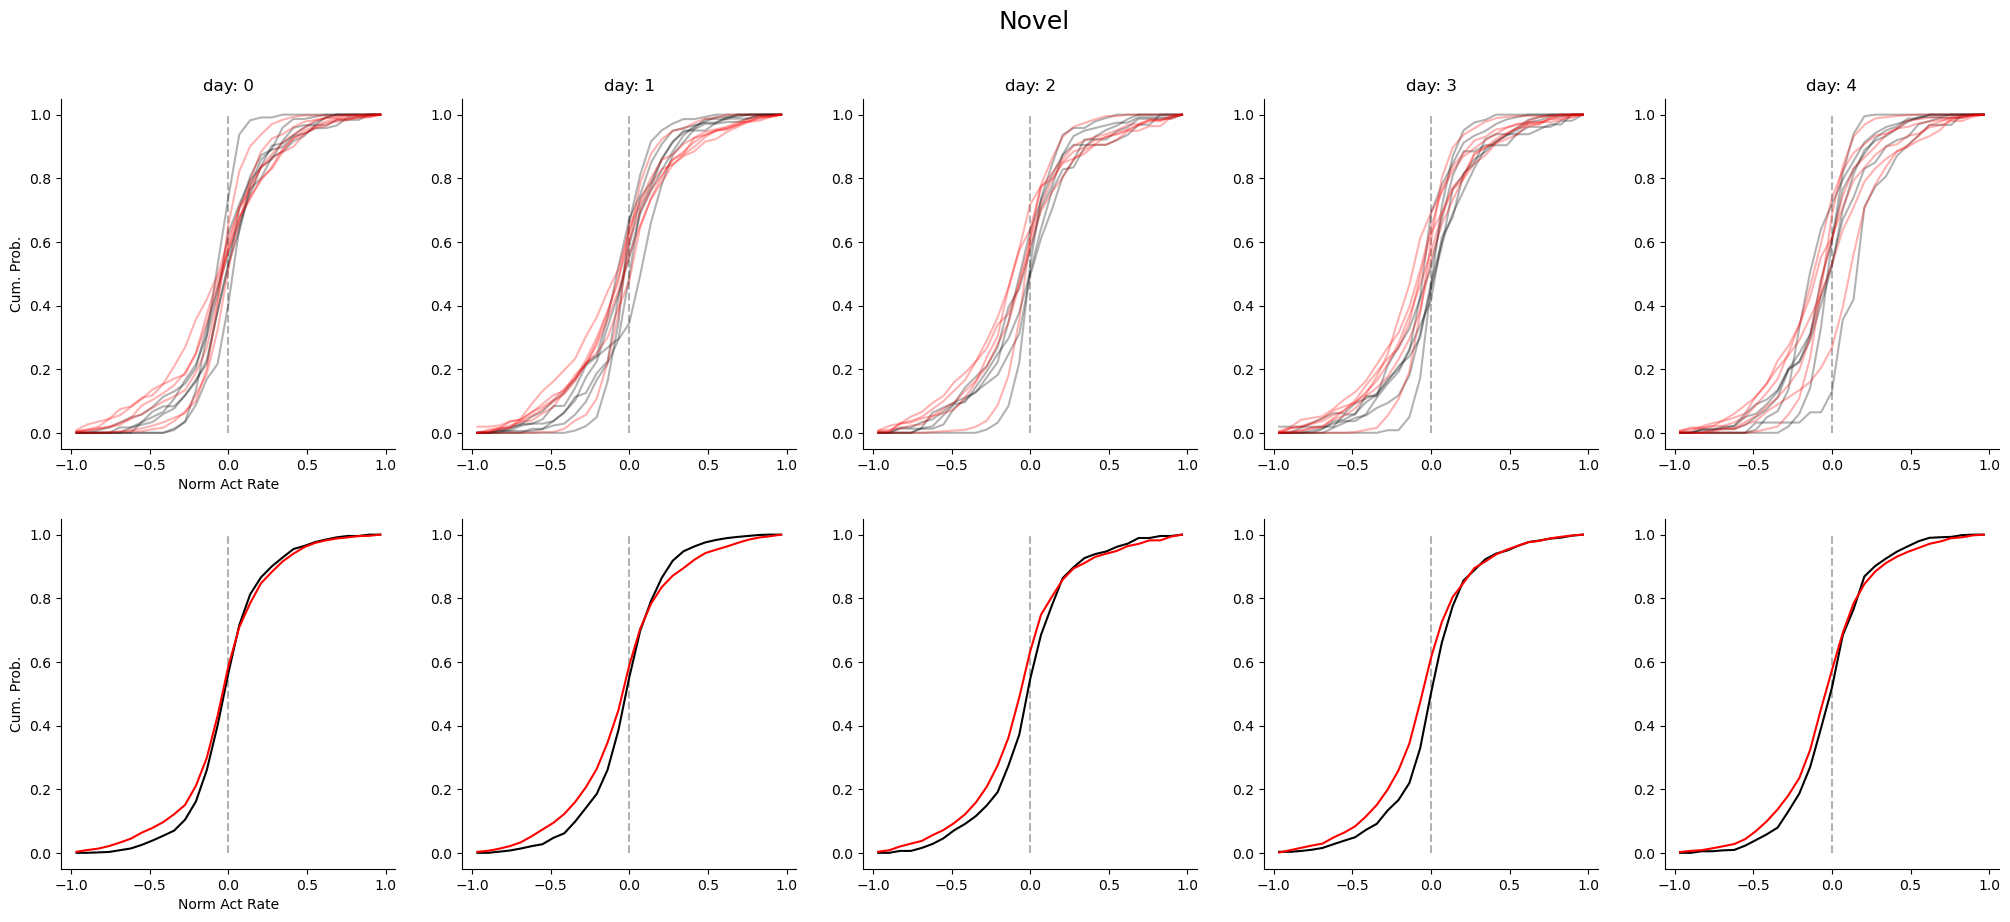

In [93]:

fig, ax = plt.subplots(2,5, figsize=[25,10])
for day in range(5):

    bin_edges = np.linspace(-1,1, num=30)
    centers = bin_edges[1:] + bin_edges[:-1]
    centers /= 2


    

    ctrl_avg_hist = []
    for mouse in sparse_mice:
        if mouse == 'SparseKO_09' and day ==2:
            continue
        d = results[mouse][day]['channel_1']
        hist, _ = np.histogram(np.log10(d['nov_mu_act_per_cell']), bin_edges)
        hist = hist/hist.sum()
        ctrl_avg_hist.append(hist)
        ax[0, day].plot(centers, np.cumsum(hist), color='black', alpha = .3)

    ko_avg_hist = []
    for mouse in sparse_mice:
        if mouse == 'SparseKO_09' and day ==2:
            continue
        d = results[mouse][day]['channel_0']
        hist, _ = np.histogram(np.log10(d['nov_mu_act_per_cell']), bin_edges)
        hist = hist/hist.sum()
        ko_avg_hist.append(hist)
        ax[0, day].plot(centers, np.cumsum(hist), color='red', alpha = .3)

    ctrl_avg_hist = np.array(ctrl_avg_hist).mean(axis=0)
    ctrl_avg_hist = ctrl_avg_hist/ctrl_avg_hist.sum()
    ko_avg_hist = np.array(ko_avg_hist).mean(axis=0)
    ko_avg_hist = ko_avg_hist/ko_avg_hist.sum()

    ax[0, day].plot([0, 0], [0,1], 'k--', alpha=.3, zorder=-1)
    ax[0, day].set_title(f'day: {day}')


    ax[1, day].plot(centers, np.cumsum(ctrl_avg_hist), color='black')
    ax[1, day].plot(centers, np.cumsum(ko_avg_hist), color='red')
    
    
    ax[1, day].plot([0, 0], [0,1], 'k--', alpha=.3, zorder=-1)
    
    for r in range(2):
        ax[r,day].spines['top'].set_visible(False)
        ax[r,day].spines['right'].set_visible(False)
        
ax[0,0].set_xlabel('Norm Act Rate')
ax[0,0].set_ylabel('Cum. Prob.')

ax[1,0].set_xlabel('Norm Act Rate')
ax[1,0].set_ylabel('Cum. Prob.')
fig.text(0.5, 0.95,'Novel',fontsize=18)
# fig.savefig(os.path.join(figdir,"log_activity_rate_hist_nov.pdf"),format='pdf')


Text(0.5, 0.95, 'Familiar')

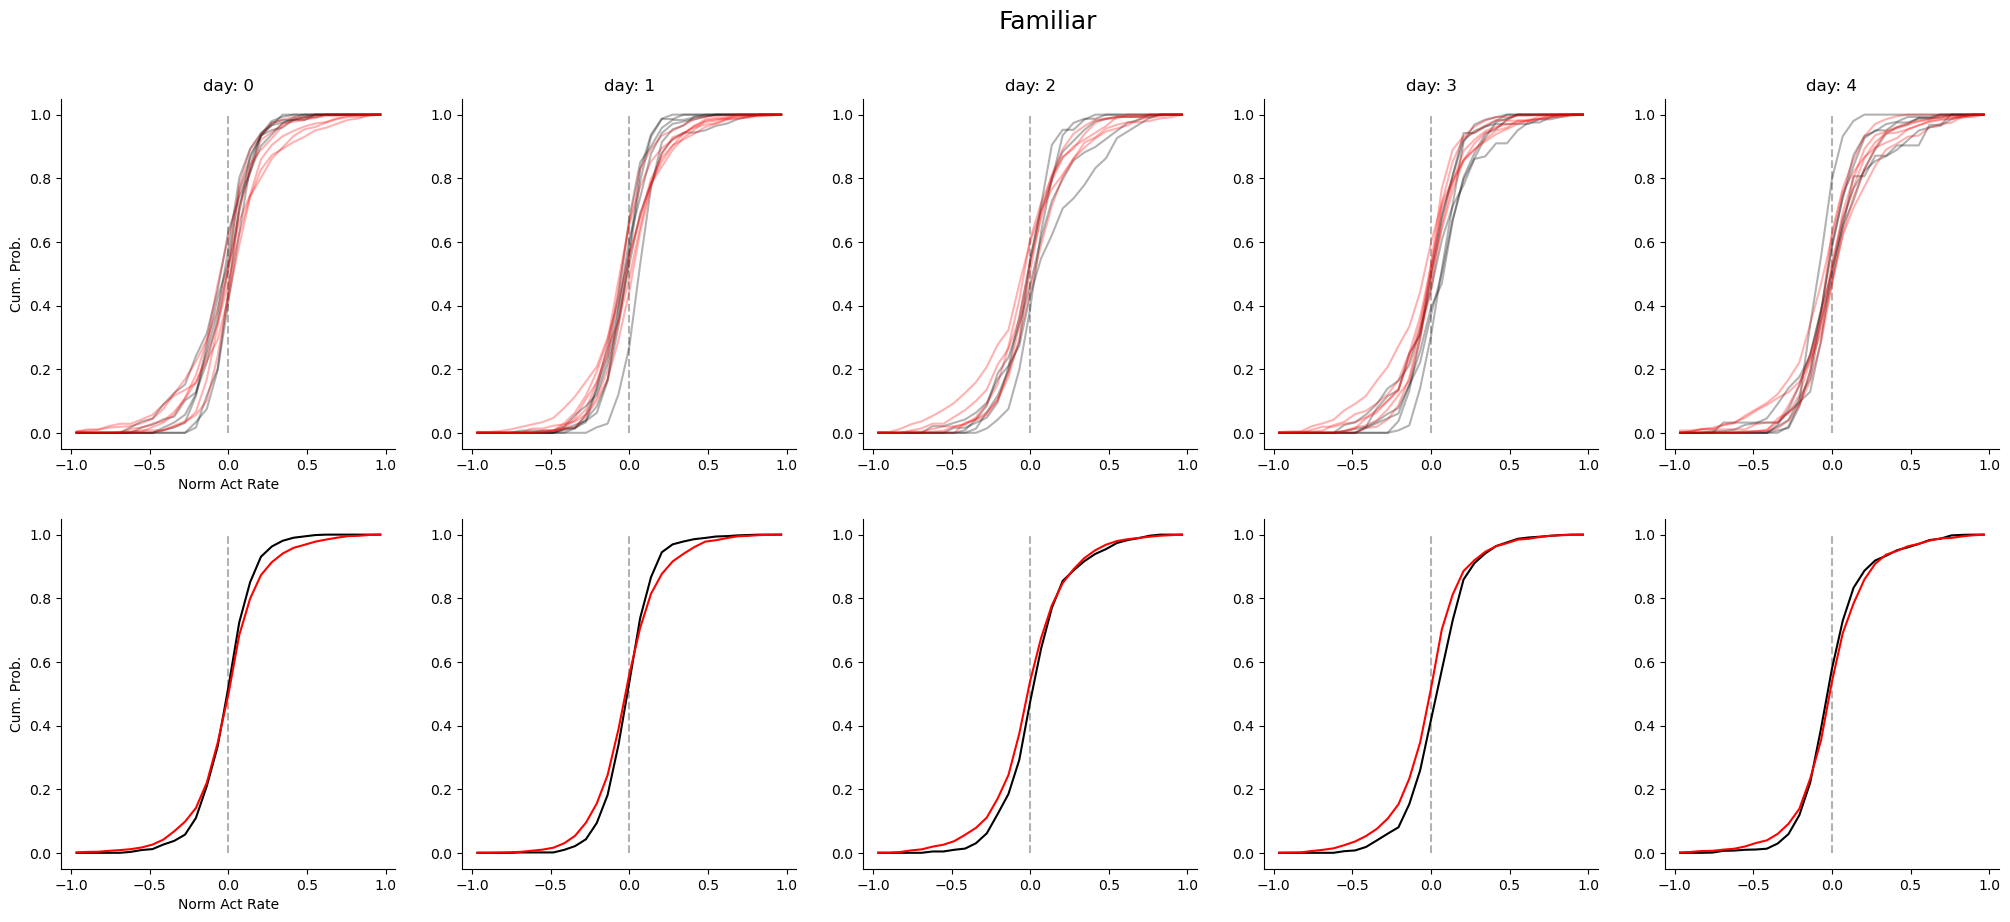

In [94]:

fig, ax = plt.subplots(2,5, figsize=[25,10])
for day in range(5):

    bin_edges = np.linspace(-1,1, num=30)
    centers = bin_edges[1:] + bin_edges[:-1]
    centers /= 2


    

    ctrl_avg_hist = []
    for mouse in sparse_mice:
        if mouse == 'SparseKO_09' and day ==2:
            continue
        d = results[mouse][day]['channel_1']
        hist, _ = np.histogram(np.log10(d['fam_mu_act_per_cell']), bin_edges)
        hist = hist/hist.sum()
        ctrl_avg_hist.append(hist)
        ax[0, day].plot(centers, np.cumsum(hist), color='black', alpha = .3)

    ko_avg_hist = []
    for mouse in sparse_mice:
        if mouse == 'SparseKO_09' and day ==2:
            continue
        d = results[mouse][day]['channel_0']
        hist, _ = np.histogram(np.log10(d['fam_mu_act_per_cell']), bin_edges)
        hist = hist/hist.sum()
        ko_avg_hist.append(hist)
        ax[0, day].plot(centers, np.cumsum(hist), color='red', alpha = .3)

    ctrl_avg_hist = np.array(ctrl_avg_hist).mean(axis=0)
    ctrl_avg_hist = ctrl_avg_hist/ctrl_avg_hist.sum()
    ko_avg_hist = np.array(ko_avg_hist).mean(axis=0)
    ko_avg_hist = ko_avg_hist/ko_avg_hist.sum()

    ax[0, day].plot([0, 0], [0,1], 'k--', alpha=.3, zorder=-1)
    ax[0, day].set_title(f'day: {day}')


    ax[1, day].plot(centers, np.cumsum(ctrl_avg_hist), color='black')
    ax[1, day].plot(centers, np.cumsum(ko_avg_hist), color='red')
    
    
    ax[1, day].plot([0, 0], [0,1], 'k--', alpha=.3, zorder=-1)
    
    for r in range(2):
        ax[r,day].spines['top'].set_visible(False)
        ax[r,day].spines['right'].set_visible(False)
        
ax[0,0].set_xlabel('Norm Act Rate')
ax[0,0].set_ylabel('Cum. Prob.')

ax[1,0].set_xlabel('Norm Act Rate')
ax[1,0].set_ylabel('Cum. Prob.')
fig.text(0.5, 0.95,'Familiar',fontsize=18)
# fig.savefig(os.path.join(figdir,"log_activity_rate_hist_nov.pdf"),format='pdf')


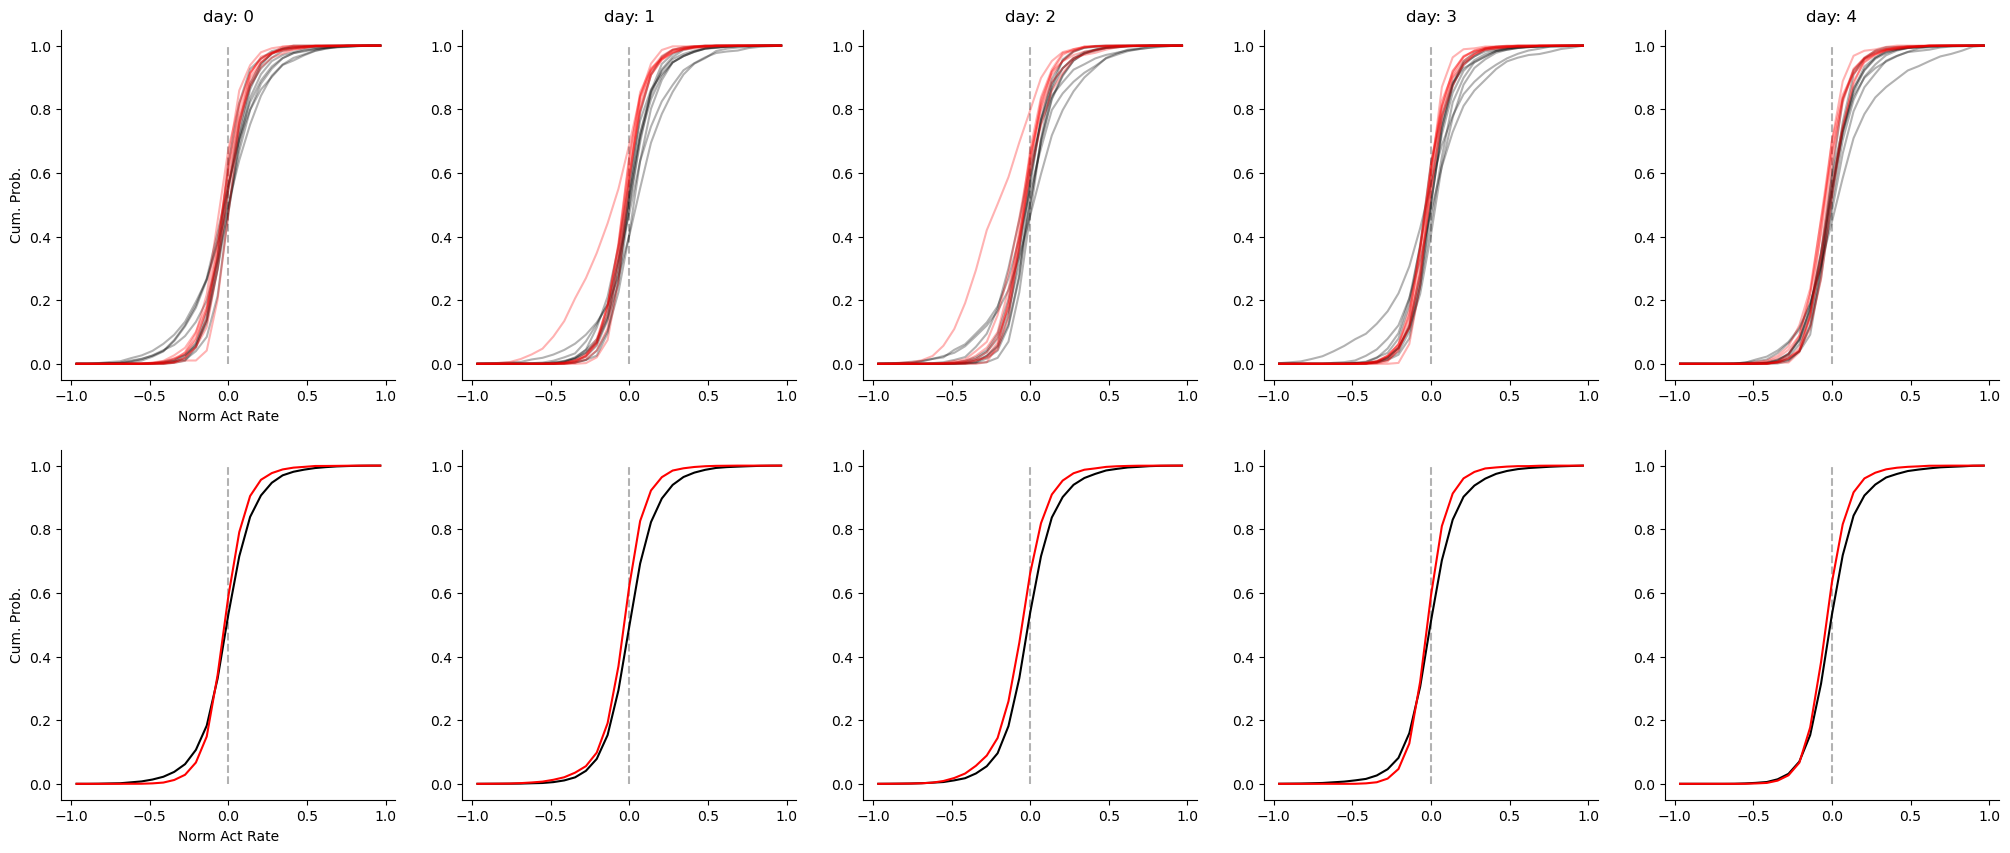

In [10]:
fig, ax = plt.subplots(2,5, figsize=[25,10])
for day in range(5):

    bin_edges = np.linspace(-1,1, num=30)
    centers = bin_edges[1:] + bin_edges[:-1]
    centers /= 2


    

    ctrl_avg_hist = []
    for mouse in ctrl_mice:
        d = results['ctrl'][day][mouse]
        hist, _ = np.histogram(np.log10(d['fam_mu_act_per_cell']), bin_edges)
        hist = hist/hist.sum()
        ctrl_avg_hist.append(hist)
        ax[0, day].plot(centers, np.cumsum(hist), color='black', alpha = .3)

    ko_avg_hist = []
    for mouse in ko_mice:
        d = results['cre'][day][mouse]
        hist, _ = np.histogram(np.log10(d['fam_mu_act_per_cell']), bin_edges)
        hist = hist/hist.sum()
        ko_avg_hist.append(hist)
        ax[0, day].plot(centers, np.cumsum(hist), color='red', alpha = .3)

    ctrl_avg_hist = np.array(ctrl_avg_hist).mean(axis=0)
    ctrl_avg_hist = ctrl_avg_hist/ctrl_avg_hist.sum()
    ko_avg_hist = np.array(ko_avg_hist).mean(axis=0)
    ko_avg_hist = ko_avg_hist/ko_avg_hist.sum()

    ax[0, day].plot([0, 0], [0,1], 'k--', alpha=.3, zorder=-1)
    ax[0, day].set_title(f'day: {day}')


    ax[1, day].plot(centers, np.cumsum(ctrl_avg_hist), color='black')
    ax[1, day].plot(centers, np.cumsum(ko_avg_hist), color='red')
    
    
    ax[1, day].plot([0, 0], [0,1], 'k--', alpha=.3, zorder=-1)
    
    for r in range(2):
        ax[r,day].spines['top'].set_visible(False)
        ax[r,day].spines['right'].set_visible(False)
        
ax[0,0].set_xlabel('Norm Act Rate')
ax[0,0].set_ylabel('Cum. Prob.')

ax[1,0].set_xlabel('Norm Act Rate')
ax[1,0].set_ylabel('Cum. Prob.')

fig.savefig(os.path.join(figdir,"log_activity_rate_hist_fam.pdf"),format='pdf')
        

In [15]:
from pingouin import rm_anova
_df = df[(df['cond']=='cre') & (df['day']<5) & (df['fam/nov']!='diff')]
aov = rm_anova(data=_df, dv='fam_mu_act_per_cell', within=['day', 'fam/nov'], subject='mouse')
print(aov)

posthoc = pairwise_tests(data=_df, dv='act', within=['day', 'fam/nov'], subject='mouse', padjust = 'holm')
print(posthoc)

NameError: name 'df' is not defined

In [12]:
results = {}

speed_max_bin = 30

for cond, mice in zip(('ctrl', 'cre'),(ctrl_mice, ko_mice)):
    results[cond] = {}
    for day in range(6):
        results[cond][day] = {}
        for mouse in mice:
            
            d = {} 
            sess = u.load_single_day(mouse, day)
            
            last_block_ind = np.argwhere(sess.trial_info['block_number']==5)[0][0]

            baseline_trials = slice(last_block_ind-10, last_block_ind)

            last_block = sess.trial_info['block_number']==3
            fam_last_block = (sess.trial_info['block_number']==3)*(sess.trial_info['LR']==-1*sess.novel_arm)
            nov_last_block = (sess.trial_info['block_number']==3)*(sess.trial_info['LR']==sess.novel_arm)
            
            d['last_block_lr'] = sess.trial_info['LR'][last_block]
            
            baseline_avg_speed = np.nanmean(sess.trial_matrices['speed'][baseline_trials,:speed_max_bin], axis=0, keepdims=True).mean()
            
            d['baseline_speed'] = np.nanmean(sess.trial_matrices['speed'][baseline_trials,:speed_max_bin]/baseline_avg_speed, axis=-1)
            d['last_block_speed'] = np.nanmean(sess.trial_matrices['speed'][last_block,:speed_max_bin]/baseline_avg_speed, axis=-1)
            d['fam_speed'] = np.nanmean(sess.trial_matrices['speed'][fam_last_block,:speed_max_bin]/baseline_avg_speed, axis=-1)
            d['nov_speed'] = np.nanmean(sess.trial_matrices['speed'][nov_last_block,:speed_max_bin]/baseline_avg_speed, axis=-1)
            
            
            baseline_avg_act = np.nanmean(np.nanmean(sess.trial_matrices['spks_norm'][baseline_trials,:,:], axis=0, keepdims=True), axis=1, keepdims=True)
            
            # print(last_block.sum(), fam_last_block.sum(), nov_last_block.sum())
            # print(sess.trial_matrices['spks_norm'].shape)
            
            d['baseline_act'] = np.nanmean(sess.trial_matrices['spks_norm'][baseline_trials,:, :]/baseline_avg_act, axis=-1)
            d['last_block_act'] = np.nanmean(sess.trial_matrices['spks_norm'][last_block,:, :]/baseline_avg_act, axis=-1)
            d['fam_act'] = np.nanmean(sess.trial_matrices['spks_norm'][fam_last_block,:, :]/baseline_avg_act, axis=-1)
            d['nov_act'] = np.nanmean(sess.trial_matrices['spks_norm'][nov_last_block,:, :]/baseline_avg_act, axis=-1)
            d['fam_mu_act_per_cell'] = np.nanmean(np.nanmean(sess.trial_matrices['spks_norm'][fam_last_block,:, :]/baseline_avg_act, axis=1), axis=0)
            d['nov_mu_act_per_cell'] = np.nanmean(np.nanmean(sess.trial_matrices['spks_norm'][nov_last_block,:, :]/baseline_avg_act, axis=1), axis=0)
            
            results[cond][day][mouse] = d


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


/tmp/ipykernel_3745599/4161785458.py:37: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices['spks_norm'][baseline_trials,:, :]/baseline_avg_act, axis=-1)
/tmp/ipykernel_3745599/4161785458.py:38: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices['spks_norm'][last_block,:, :]/baseline_avg_act, axis=-1)
/tmp/ipykernel_3745599/4161785458.py:39: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices['spks_norm'][fam_last_block,:, :]/baseline_avg_act, axis=-1)
/tmp/ipykernel_3745599/4161785458.py:42: RuntimeWarning: Mean of empty slice
  d['nov_mu_act_per_cell'] = np.nanmean(np.nanmean(sess.trial_matrices['spks_norm'][nov_last_block,:, :]/baseline_avg_act, axis=1), axis=0)


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', '

/tmp/ipykernel_3745599/4161785458.py:37: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices['spks_norm'][baseline_trials,:, :]/baseline_avg_act, axis=-1)
/tmp/ipykernel_3745599/4161785458.py:38: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices['spks_norm'][last_block,:, :]/baseline_avg_act, axis=-1)
/tmp/ipykernel_3745599/4161785458.py:39: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices['spks_norm'][fam_last_block,:, :]/baseline_avg_act, axis=-1)
/tmp/ipykernel_3745599/4161785458.py:42: RuntimeWarning: Mean of empty slice
  d['nov_mu_act_per_cell'] = np.nanmean(np.nanmean(sess.trial_matrices['spks_norm'][nov_last_block,:, :]/baseline_avg_act, axis=1), axis=0)


{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 's

/tmp/ipykernel_3745599/4161785458.py:37: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices['spks_norm'][baseline_trials,:, :]/baseline_avg_act, axis=-1)
/tmp/ipykernel_3745599/4161785458.py:38: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices['spks_norm'][last_block,:, :]/baseline_avg_act, axis=-1)
/tmp/ipykernel_3745599/4161785458.py:39: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices['spks_norm'][fam_last_block,:, :]/baseline_avg_act, axis=-1)
/tmp/ipykernel_3745599/4161785458.py:42: RuntimeWarning: Mean of empty slice
  d['nov_mu_act_per_cell'] = np.nanmean(np.nanmean(sess.trial_matrices['spks_norm'][nov_last_block,:, :]/baseline_avg_act, axis=1), axis=0)


{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 's

/tmp/ipykernel_3745599/4161785458.py:40: RuntimeWarning: Mean of empty slice
  d['nov_act'] = np.nanmean(sess.trial_matrices['spks_norm'][nov_last_block,:, :]/baseline_avg_act, axis=-1)


{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}


/tmp/ipykernel_3745599/1668055660.py:38: RuntimeWarning: Mean of empty slice
  df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))))
/tmp/ipykernel_3745599/1668055660.py:44: RuntimeWarning: Mean of empty slice
  df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))) - np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
/tmp/ipykernel_3745599/1668055660.py:57: RuntimeWarning: Mean of empty slice
  mu_s, sem_s = np.nanmean(ko_nov_act, axis=0), sp.stats.sem(ko_nov_act, axis=0, nan_policy='omit')
/tmp/ipykernel_3745599/1668055660.py:84: RuntimeWarning: Mean of empty slice
  df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))))
/tmp/ipykernel_3745599/1668055660.py:90: RuntimeWarning: Mean of empty slice
  df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))) - np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
/tmp/ipykernel_3745599/1668055660.py:102: RuntimeWarning: Mean of empty slice
  mu_s, sem_s = n

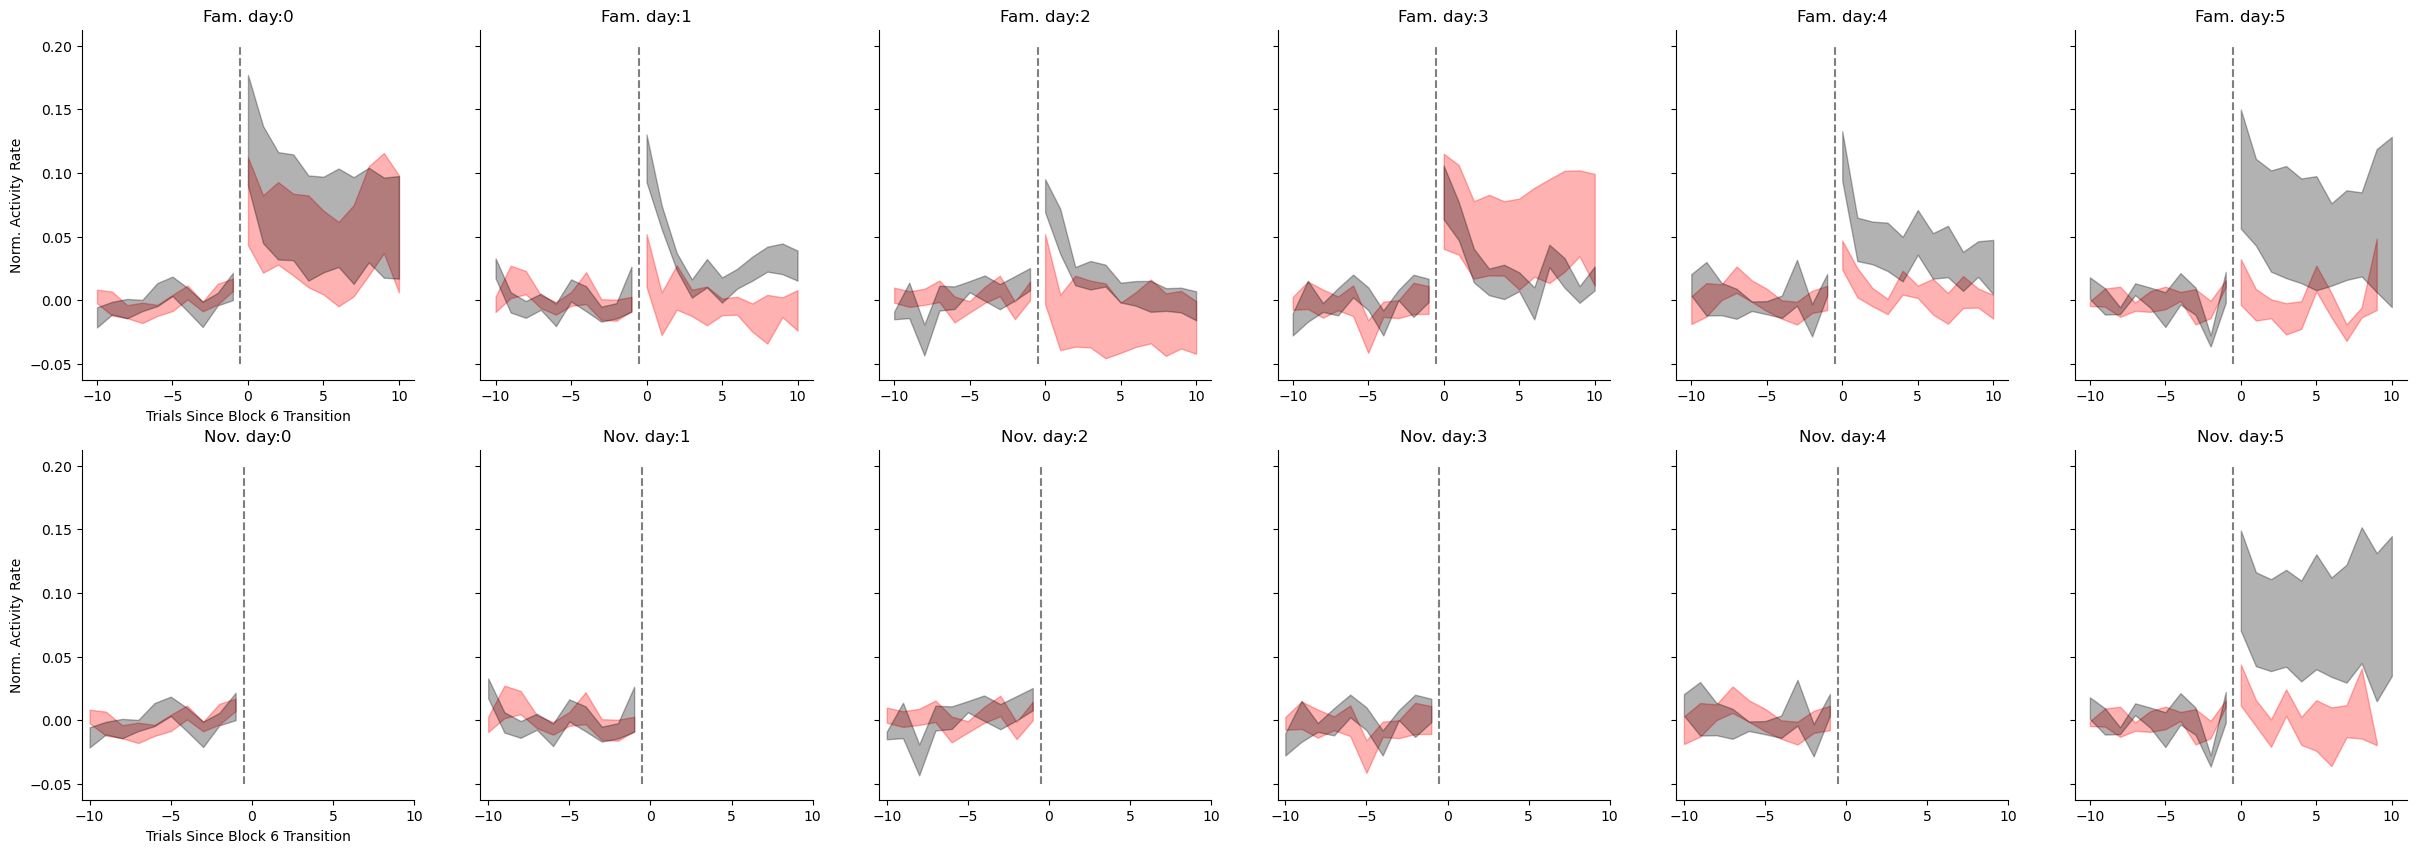

In [13]:
fig,ax = plt.subplots(2,6, figsize = [30, 10],sharey=True)
# ax[0,0].set_ylim([.5,1.2])


df = {
      'mouse': [],
      'cond': [],
      'day': [],
      'fam/nov': [],
      'act':[],
     }

for day in range(6):

    ko_base = np.zeros((len(ko_mice), 10))*np.nan
    ko_fam_act = np.zeros((len(ko_mice), 11))*np.nan
    ko_nov_act = np.zeros((len(ko_mice), 11))*np.nan
    for m, mouse in enumerate(ko_mice):
        d = results['cre'][day][mouse]
        ko_base[m,:] = np.log10(d['baseline_act'][-10:,:].mean(axis=-1))
        
        _act = np.log10(np.nanmean(d['fam_act'][:11,:],axis=-1))
        ko_fam_act[m,:_act.shape[0]] = _act[:11]
        
        _act = np.log10(np.nanmean(d['nov_act'][:11,:],axis=-1))
        ko_nov_act[m,:_act.shape[0]] = _act[:11]
        
        df['mouse'].append(mouse)
        df['cond'].append('cre')
        df['day'].append(day)
        df['fam/nov'].append('fam')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
        
        df['mouse'].append(mouse)
        df['cond'].append('cre')
        df['day'].append(day)
        df['fam/nov'].append('nov')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))))
        
        df['mouse'].append(mouse)
        df['cond'].append('cre')
        df['day'].append(day)
        df['fam/nov'].append('diff')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))) - np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
        
                         

    x_base = np.arange(-10,0)
    x_act = np.arange(0, 11)
    mu_b, sem_b = np.nanmean(ko_base, axis=0), sp.stats.sem(ko_base, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='red', alpha=.3)
    ax[1, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='red', alpha=.3)

    mu_s, sem_s = np.nanmean(ko_fam_act, axis=0), sp.stats.sem(ko_fam_act, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_act, mu_s-sem_s, mu_s+sem_s, color='red', alpha=.3)
    
    mu_s, sem_s = np.nanmean(ko_nov_act, axis=0), sp.stats.sem(ko_nov_act, axis=0, nan_policy='omit')
    ax[1, day].fill_between(x_act, mu_s-sem_s, mu_s+sem_s, color='red', alpha=.3)
    
                         
    ctrl_base = np.zeros((len(ctrl_mice), 10))*np.nan
    ctrl_fam_act = np.zeros((len(ctrl_mice), 11))*np.nan
    ctrl_nov_act = np.zeros((len(ctrl_mice), 11))*np.nan
    for m, mouse in enumerate(ctrl_mice):
        d = results['ctrl'][day][mouse]
        ctrl_base[m,:] = np.log10(d['baseline_act'][-10:,:].mean(axis=-1))
        
        _act = np.log10(np.nanmean(d['fam_act'][:11,:],axis=-1))
        ctrl_fam_act[m,:_act.shape[0]] = _act[:11]
        
        _act = np.log10(np.nanmean(d['nov_act'][:11,:],axis=-1))
        ctrl_nov_act[m,:_act.shape[0]] = _act[:11]
        
        df['mouse'].append(mouse)
        df['cond'].append('ctrl')
        df['day'].append(day)
        df['fam/nov'].append('fam')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
        
        df['mouse'].append(mouse)
        df['cond'].append('ctrl')
        df['day'].append(day)
        df['fam/nov'].append('nov')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))))
        
        df['mouse'].append(mouse)
        df['cond'].append('ctrl')
        df['day'].append(day)
        df['fam/nov'].append('diff')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))) - np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
                         

    x_base = np.arange(-10,0)
    x_act = np.arange(0, 11)
    mu_b, sem_b = np.nanmean(ctrl_base, axis=0), sp.stats.sem(ctrl_base, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='black', alpha=.3)
    ax[1, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='black', alpha=.3)

    mu_s, sem_s = np.nanmean(ctrl_fam_act, axis=0), sp.stats.sem(ctrl_fam_act, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_act, mu_s-sem_s, mu_s+sem_s, color='black', alpha=.3)
    
    mu_s, sem_s = np.nanmean(ctrl_nov_act, axis=0), sp.stats.sem(ctrl_nov_act, axis=0, nan_policy='omit')
    ax[1, day].fill_between(x_act, mu_s-sem_s, mu_s+sem_s, color='black', alpha=.3)
    
    
 



    
    ax[0,day].plot([-.5, -.5],[-.05,.2],'k--', alpha = .5)
    ax[1,day].plot([-.5, -.5],[-.05,.2],'k--', alpha = .5)
    
    ax[0,day].set_xticks([-10, -5, 0, 5, 10])
    ax[1,day].set_xticks([-10, -5, 0, 5, 10])
    
    ax[0, day].set_title(f'Fam. day:{day}')
    ax[1, day].set_title(f'Nov. day:{day}')
    
    ax[0,day].spines['top'].set_visible(False)
    ax[1,day].spines['top'].set_visible(False)
    
    ax[0,day].spines['right'].set_visible(False)
    ax[1,day].spines['right'].set_visible(False)
    
ax[0,0].set_ylabel('Norm. Activity Rate')
ax[0,0].set_xlabel('Trials Since Block 6 Transition')

ax[1,0].set_ylabel('Norm. Activity Rate')
ax[1,0].set_xlabel('Trials Since Block 6 Transition')

df = pd.DataFrame(df)

fig.savefig(os.path.join(figdir,"log_activity_rate_block3_all_days.pdf"),format='pdf')

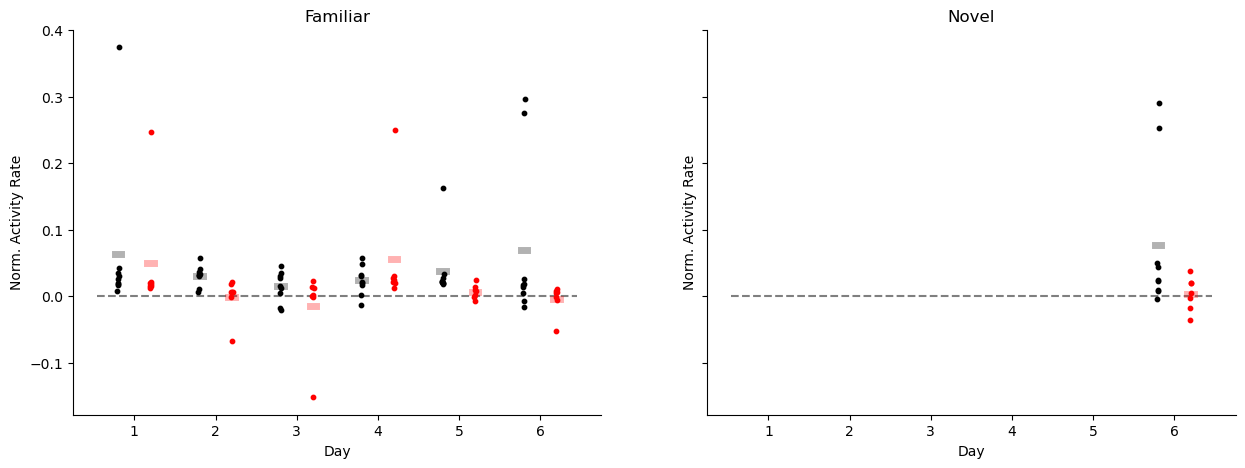

In [14]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['fam/nov']=='fam')
    lr = df['act'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['fam/nov']=='nov')
    lr = df['act'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['fam/nov']=='fam')
    lr = df['act'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['fam/nov']=='nov')
    lr = df['act'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=lr.shape[0]), lr, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), lr.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
ax[0].plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)
ax[1].plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)
    
ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Norm. Activity Rate')
    ax[a].set_xlabel('Day')
    
fig.savefig(os.path.join(figdir,"log_activity_rate_block3_summary.pdf"),format='pdf')

In [4]:
test_block = 3
results = {}

speed_max_bin = 30

for cond, mice in zip(('ctrl', 'cre'),(ctrl_mice, ko_mice)):
    results[cond] = {}
    for day in range(6):
        results[cond][day] = {}
        for mouse in mice:
            
            d = {} 
            sess = u.load_single_day(mouse, day)
            
            last_block_ind = np.argwhere(sess.trial_info['block_number']==test_block)[0][0]

            baseline_trials = slice(last_block_ind-10, last_block_ind)

            last_block = sess.trial_info['block_number']==test_block
            fam_last_block = (sess.trial_info['block_number']==test_block)*(sess.trial_info['LR']==-1*sess.novel_arm)
            nov_last_block = (sess.trial_info['block_number']==test_block)*(sess.trial_info['LR']==sess.novel_arm)
            
            d['last_block_lr'] = sess.trial_info['LR'][last_block]
            
            baseline_avg_speed = np.nanmean(sess.trial_matrices['speed'][baseline_trials,:speed_max_bin], axis=0, keepdims=True).mean()
            
            d['baseline_speed'] = np.nanmean(sess.trial_matrices['speed'][baseline_trials,:speed_max_bin]/baseline_avg_speed, axis=-1)
            d['last_block_speed'] = np.nanmean(sess.trial_matrices['speed'][last_block,:speed_max_bin]/baseline_avg_speed, axis=-1)
            d['fam_speed'] = np.nanmean(sess.trial_matrices['speed'][fam_last_block,:speed_max_bin]/baseline_avg_speed, axis=-1)
            d['nov_speed'] = np.nanmean(sess.trial_matrices['speed'][nov_last_block,:speed_max_bin]/baseline_avg_speed, axis=-1)
            
            
            baseline_avg_act = np.nanmean(np.nanmean(sess.trial_matrices['spks_norm'][baseline_trials,:,:], axis=0, keepdims=True), axis=1, keepdims=True)
            
            # print(last_block.sum(), fam_last_block.sum(), nov_last_block.sum())
            # print(sess.trial_matrices['spks_norm'].shape)
            
            d['baseline_act'] = np.nanmean(sess.trial_matrices['spks_norm'][baseline_trials,:, :]/baseline_avg_act, axis=-1)
            d['last_block_act'] = np.nanmean(sess.trial_matrices['spks_norm'][last_block,:, :]/baseline_avg_act, axis=-1)
            d['fam_act'] = np.nanmean(sess.trial_matrices['spks_norm'][fam_last_block,:, :]/baseline_avg_act, axis=-1)
            d['nov_act'] = np.nanmean(sess.trial_matrices['spks_norm'][nov_last_block,:, :]/baseline_avg_act, axis=-1)
            d['fam_mu_act_per_cell'] = np.nanmean(np.nanmean(sess.trial_matrices['spks_norm'][fam_last_block,:, :]/baseline_avg_act, axis=1), axis=0)
            d['nov_mu_act_per_cell'] = np.nanmean(np.nanmean(sess.trial_matrices['spks_norm'][nov_last_block,:, :]/baseline_avg_act, axis=1), axis=0)
            
            results[cond][day][mouse] = d

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


/tmp/ipykernel_4018305/2925147164.py:38: RuntimeWarning: Mean of empty slice
  d['baseline_act'] = np.nanmean(sess.trial_matrices['spks_norm'][baseline_trials,:, :]/baseline_avg_act, axis=-1)
/tmp/ipykernel_4018305/2925147164.py:39: RuntimeWarning: Mean of empty slice
  d['last_block_act'] = np.nanmean(sess.trial_matrices['spks_norm'][last_block,:, :]/baseline_avg_act, axis=-1)
/tmp/ipykernel_4018305/2925147164.py:40: RuntimeWarning: Mean of empty slice
  d['fam_act'] = np.nanmean(sess.trial_matrices['spks_norm'][fam_last_block,:, :]/baseline_avg_act, axis=-1)
/tmp/ipykernel_4018305/2925147164.py:43: RuntimeWarning: Mean of empty slice
  d['nov_mu_act_per_cell'] = np.nanmean(np.nanmean(sess.trial_matrices['spks_norm'][nov_last_block,:, :]/baseline_avg_act, axis=1), axis=0)


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}



KeyboardInterrupt



/tmp/ipykernel_2718184/644506180.py:38: RuntimeWarning: Mean of empty slice
  df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))))
/tmp/ipykernel_2718184/644506180.py:44: RuntimeWarning: Mean of empty slice
  df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))) - np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
/tmp/ipykernel_2718184/644506180.py:57: RuntimeWarning: Mean of empty slice
  mu_s, sem_s = np.nanmean(ko_nov_act, axis=0), sp.stats.sem(ko_nov_act, axis=0, nan_policy='omit')
/tmp/ipykernel_2718184/644506180.py:85: RuntimeWarning: Mean of empty slice
  df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))))
/tmp/ipykernel_2718184/644506180.py:91: RuntimeWarning: Mean of empty slice
  df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))) - np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
/tmp/ipykernel_2718184/644506180.py:103: RuntimeWarning: Mean of empty slice
  mu_s, sem_s = np.nanm

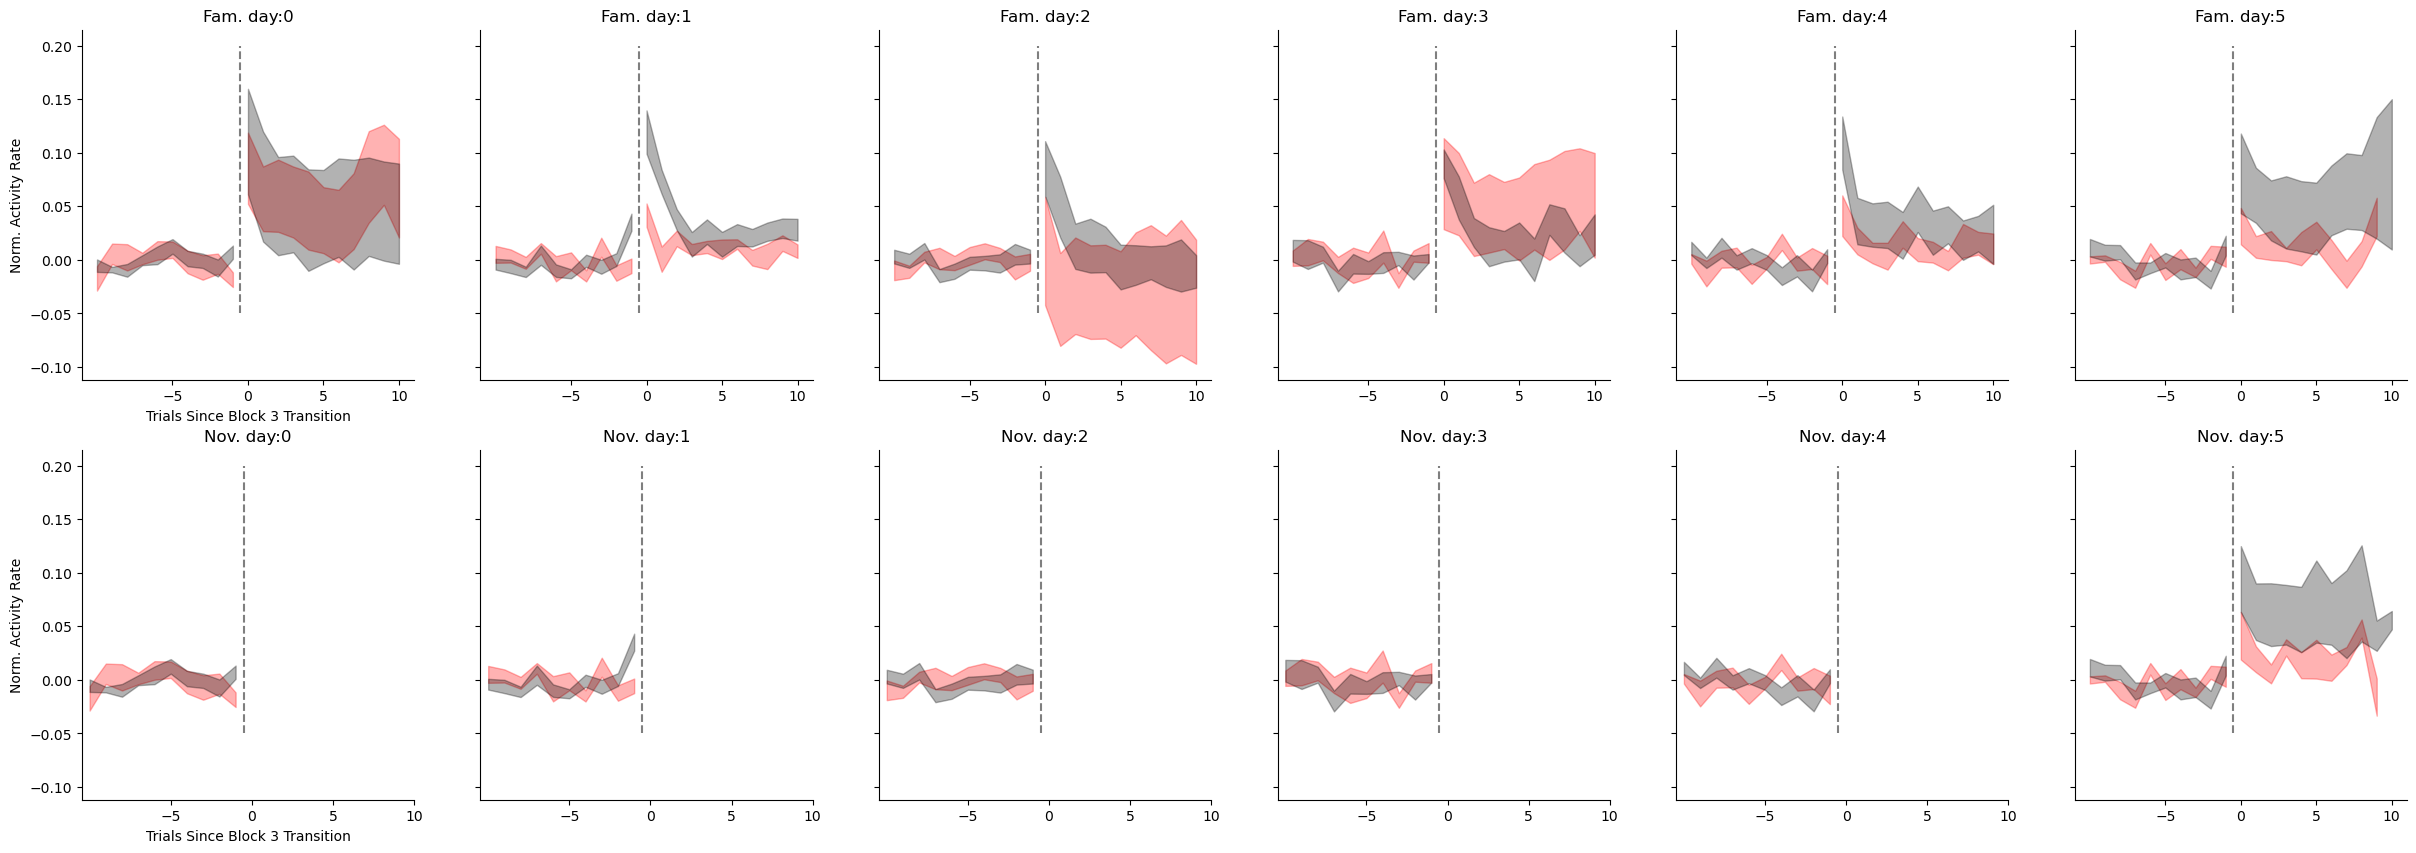

In [44]:
fig,ax = plt.subplots(2,6, figsize = [30, 10],sharey=True)
# ax[0,0].set_ylim([.5,1.2])


df = {
      'mouse': [],
      'cond': [],
      'day': [],
      'fam/nov': [],
      'act':[],
     }

for day in range(6):

    ko_base = np.zeros((len(ko_mice), 10))*np.nan
    ko_fam_act = np.zeros((len(ko_mice), 11))*np.nan
    ko_nov_act = np.zeros((len(ko_mice), 11))*np.nan
    for m, mouse in enumerate(ko_mice):
        d = results['cre'][day][mouse]
        ko_base[m,:] = np.log10(d['baseline_act'][-10:,:].mean(axis=-1))
        
        _act = np.log10(np.nanmean(d['fam_act'][:11,:],axis=-1))
        ko_fam_act[m,:_act.shape[0]] = _act[:11]
        
        _act = np.log10(np.nanmean(d['nov_act'][:11,:],axis=-1))
        ko_nov_act[m,:_act.shape[0]] = _act[:11]
        
        df['mouse'].append(mouse)
        df['cond'].append('cre')
        df['day'].append(day)
        df['fam/nov'].append('fam')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
        
        df['mouse'].append(mouse)
        df['cond'].append('cre')
        df['day'].append(day)
        df['fam/nov'].append('nov')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))))
        
        df['mouse'].append(mouse)
        df['cond'].append('cre')
        df['day'].append(day)
        df['fam/nov'].append('diff')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))) - np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
        
                         

    x_base = np.arange(-10,0)
    x_act = np.arange(0, 11)
    mu_b, sem_b = np.nanmean(ko_base, axis=0), sp.stats.sem(ko_base, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='red', alpha=.3)
    ax[1, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='red', alpha=.3)

    mu_s, sem_s = np.nanmean(ko_fam_act, axis=0), sp.stats.sem(ko_fam_act, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_act, mu_s-sem_s, mu_s+sem_s, color='red', alpha=.3)
    
    mu_s, sem_s = np.nanmean(ko_nov_act, axis=0), sp.stats.sem(ko_nov_act, axis=0, nan_policy='omit')
    ax[1, day].fill_between(x_act, mu_s-sem_s, mu_s+sem_s, color='red', alpha=.3)
    
                         
    ctrl_base = np.zeros((len(ctrl_mice), 10))*np.nan
    ctrl_fam_act = np.zeros((len(ctrl_mice), 11))*np.nan
    ctrl_nov_act = np.zeros((len(ctrl_mice), 11))*np.nan
    for m, mouse in enumerate(ctrl_mice):
        d = results['ctrl'][day][mouse]
        # print(d['baseline_act'][-10:,:].mean(axis=-1))
        ctrl_base[m,:] = np.log10(np.nanmean(d['baseline_act'][-10:,:],axis=-1))
        
        _act = np.log10(np.nanmean(d['fam_act'][:11,:],axis=-1))
        ctrl_fam_act[m,:_act.shape[0]] = _act[:11]
        
        _act = np.log10(np.nanmean(d['nov_act'][:11,:],axis=-1))
        ctrl_nov_act[m,:_act.shape[0]] = _act[:11]
        
        df['mouse'].append(mouse)
        df['cond'].append('ctrl')
        df['day'].append(day)
        df['fam/nov'].append('fam')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
        
        df['mouse'].append(mouse)
        df['cond'].append('ctrl')
        df['day'].append(day)
        df['fam/nov'].append('nov')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))))
        
        df['mouse'].append(mouse)
        df['cond'].append('ctrl')
        df['day'].append(day)
        df['fam/nov'].append('diff')
        df['act'].append(np.log10(np.nanmean(np.nanmean(d['nov_act'], axis=-1))) - np.log10(np.nanmean(np.nanmean(d['fam_act'], axis=-1))))
                         

    x_base = np.arange(-10,0)
    x_act = np.arange(0, 11)
    mu_b, sem_b = np.nanmean(ctrl_base, axis=0), sp.stats.sem(ctrl_base, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='black', alpha=.3)
    ax[1, day].fill_between(x_base, mu_b-sem_b, mu_b+sem_b, color='black', alpha=.3)

    mu_s, sem_s = np.nanmean(ctrl_fam_act, axis=0), sp.stats.sem(ctrl_fam_act, axis=0, nan_policy='omit')
    ax[0, day].fill_between(x_act, mu_s-sem_s, mu_s+sem_s, color='black', alpha=.3)
    
    mu_s, sem_s = np.nanmean(ctrl_nov_act, axis=0), sp.stats.sem(ctrl_nov_act, axis=0, nan_policy='omit')
    ax[1, day].fill_between(x_act, mu_s-sem_s, mu_s+sem_s, color='black', alpha=.3)
    
    
 



    
    ax[0,day].plot([-.5, -.5],[-.05,.2],'k--', alpha = .5)
    ax[1,day].plot([-.5, -.5],[-.05,.2],'k--', alpha = .5)
    
    ax[0,day].set_xticks([-5, 0, 5, 10])
    ax[1,day].set_xticks([-5, 0, 5, 10])
    
    ax[0, day].set_title(f'Fam. day:{day}')
    ax[1, day].set_title(f'Nov. day:{day}')
    
    ax[0,day].spines['top'].set_visible(False)
    ax[1,day].spines['top'].set_visible(False)
    
    ax[0,day].spines['right'].set_visible(False)
    ax[1,day].spines['right'].set_visible(False)
    
ax[0,0].set_ylabel('Norm. Activity Rate')
ax[0,0].set_xlabel(f'Trials Since Block {test_block} Transition')

ax[1,0].set_ylabel('Norm. Activity Rate')
ax[1,0].set_xlabel(f'Trials Since Block {test_block} Transition')

df = pd.DataFrame(df)

fig.savefig(os.path.join(figdir,"log_activity_rate_block3_all_days.pdf"),format='pdf')

In [ ]:
# running speed in novel and familiar trials in last block compared to previous block

# compare novel vs familiar

# day 1

# day 5

# summary across days

In [ ]:
# example population averages for individual mice as function of position

# broken up by familiar and novel trials


# day 1


# day 5


# across animal average as a function of position


In [ ]:
# novel activity rate 
    # compare cre and control
    
    # regress out running speed
    

    
    

In [ ]:
# familiar last block activity rate
    # compare cre and control
    
    

In [ ]:
# novel vs familar difference
    # compare cre and control

In [5]:
class ActivityRate:
    
    def __init__(self, days = np.arange(6), pos_bin=False, pos_avg = True, block = 5, cell_avg=True, novel_only = False, fam_only=False, t_post=40):
        
        self.ko_mice = ko_mice
        self.ctrl_mice = ctrl_mice
        
        self.days = days
        self.n_days = days.shape[0]
        
        self.pos_bin = pos_bin
        self.pos_avg = pos_avg
        self.block = block
        self.cell_avg = cell_avg
        self.novel_only = novel_only
        self.fam_only = fam_only
        self.t_post = t_post
        self.df = None
        
        self.ko_data = self.mouse_loop(ko_mice)
        self.ctrl_data = self.mouse_loop(ctrl_mice)
        self.make_dataframe()
        
    @staticmethod
    def get_act_rate(sess, block=5, pos_bin=False, pos_avg = True, t_post = 40, cell_avg = True, novel_only = False, fam_only=False):
        '''
        
        
        '''
        
        last_block_ind = np.argwhere(sess.trial_info['block_number']==block)[0][0]
#         last_trial_ind = np.argwhere(sess.trial_info['block_number'])
        lr = np.zeros([t_post,])*np.nan
        _lr = sess.trial_info['LR'][last_block_ind:last_block_ind+t_post]
        lr[:_lr.shape[0]]=_lr
        
        if pos_bin:
            if pos_avg:
                
                mu = np.zeros([t_post,])*np.nan
                speed = np.zeros([t_post,])*np.nan
                
            
                baseline_tmat = sess.trial_matrices['spks'][last_block_ind-10:last_block_ind,:,:]
                tmat = sess.trial_matrices['spks'][last_block_ind:last_block_ind+t_post,:,:]
                if novel_only:
                    tmat = tmat[_lr==sess.novel_arm,:,:]
                
                if fam_only:
                    tmat = tmat[_lr==-1*sess.novel_arm,:,:]
                    
                

                baseline_mu = (np.nanmean(baseline_tmat, axis=1, keepdims=True)/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)).mean(axis=-1).ravel()
                
                mu[:tmat.shape[0]] = (np.nanmean(tmat, axis=1, keepdims=True)/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)).mean(axis=-1).ravel()

                _baseline_speed = np.nanmean(sess.trial_matrices['speed'][last_block_ind-10:last_block_ind, :], axis=-1)
                _speed = np.nanmean(sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post,:],axis=-1)/_baseline_speed.mean(axis=0,keepdims=True)
                if novel_only:
                    _speed = _speed[_lr==sess.novel_arm]
                    
                if fam_only:
                    _speed = _speed[_lr==-1*sess.novel_arm]
                    
                speed[:tmat.shape[0]] = _speed #np.nanmean(sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post, :], axis=-1)/_baseline_speed.mean(keepdims=True)
                
                baseline_speed = _baseline_speed/_baseline_speed.mean()
            else:
                
                

                speed = np.zeros([t_post, sess.trial_matrices['speed'].shape[1]])*np.nan
                
                if cell_avg:
                    mu = np.zeros([t_post, sess.trial_matrices['spks'].shape[1]])*np.nan
                    baseline_tmat = sess.trial_matrices['spks'][last_block_ind-10:last_block_ind, :, :] +1E-5
                    tmat = sess.trial_matrices['spks'][last_block_ind:last_block_ind+t_post,:,:]
                    if novel_only:
                        tmat = tmat[_lr==sess.novel_arm,:,:]
                


                    baseline_mu = np.nanmean(baseline_tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=-1)
                    
                    mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True), axis=-1)
    #                 mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=-1)
                    
                else:
                    mu = np.zeros([t_post, *sess.trial_matrices['spks'].shape[1:]])*np.nan
                    baseline_tmat = sess.trial_matrices['spks'][last_block_ind-10:last_block_ind, :, :] +1E-5
                    tmat = sess.trial_matrices['spks'][last_block_ind:last_block_ind+t_post,:,:]


    #                 baseline_mu = np.nanmean(baseline_tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=-1)
                    baseline_mu = baseline_tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True)
                    mu[:tmat.shape[0], :, :] = tmat/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)
    #                 mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True), axis=-1)
    #                 mu[:tmat.shape[0], :] = np.nanmean(tmat/np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=-1)

                
                _baseline_speed = np.nanmean(sess.trial_matrices['speed'][last_block_ind-10:last_block_ind, :], axis=-1)
                _speed = sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post,:]/_baseline_speed.mean(axis=0,keepdims=True)
                if novel_only:
                    _speed = _speed[_lr==sess.novel_arm,:]
                speed[:tmat.shape[0], :] = _speed #sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post,:]/_baseline_speed.mean(axis=0,keepdims=True)
                
                baseline_speed = _baseline_speed/_baseline_speed.mean(axis=0, keepdims=True)
      
            
        else:
            
            # TODO: 
            _baseline_mu = np.zeros([10,sess.timeseries['spks'].shape[0]])*np.nan
            mu = np.zeros([t_post,sess.timeseries['spks'].shape[0]])*np.nan
            
            _baseline_speed = np.zeros([10,])*np.nan
            speed = np.zeros([t_post,])*np.nan
            
            baseline_starts, baseline_stops = sess.trial_start_inds[last_block_ind-10:last_block_ind], sess.teleport_inds[last_block_ind-10:last_block_ind]
            for i, (start, stop) in enumerate(zip(baseline_starts, baseline_stops)):
                _baseline_mu[i,:] = sess.timeseries['spks'][:,start:stop].mean(axis=-1)
                _baseline_speed[i] = sess.timeseries['speed'][0,start:stop].mean()
            
            starts, stops = sess.trial_start_inds[last_block_ind:last_block_ind+t_post], sess.teleport_inds[last_block_ind:last_block_ind+t_post]
            for i, (start, stop) in enumerate(zip(starts,stops)):
                mu[i,:] = sess.timeseries['spks'][:,start:stop].mean(axis=-1)
                speed[i] = sess.timeseries['speed'][0,start:stop].mean()
            
            
            baseline_mu = (_baseline_mu/_baseline_mu.mean(axis=0,keepdims=True)).mean(axis=-1) 
            mu = (mu/_baseline_mu.mean(axis=0,keepdims=True)).mean(axis=-1)
            
            
            baseline_speed = _baseline_speed/_baseline_speed.mean()
            speed /= _baseline_speed.mean()
#             print(speed.shape)
            
        return mu, baseline_mu, speed, baseline_speed, lr
    
    
    def mouse_loop(self, mice):
        
        d= {}
        for mouse in mice:
            d[mouse] = {'mu': [], 'baseline_mu': [], 'speed': [], 'baseline_speed': [], 'famnov': [], 
                        'place_cell_info': [], 'trials_post_nov':[]}
            for day in self.days:
                sess = u.load_single_day(mouse, day, verbose=False)
                mu, baseline_mu, speed, baseline_speed, lr = self.get_act_rate(sess, block=self.block, pos_bin = self.pos_bin, 
                                                                               pos_avg = self.pos_avg, cell_avg = self.cell_avg, 
                                                                               novel_only = self.novel_only, fam_only = self.fam_only,
                                                                              t_post = self.t_post)
#                 d[mouse]['mu'].append(mu)
                d[mouse]['mu'].append(np.log(mu))
                d[mouse]['baseline_mu'].append(np.log(baseline_mu))
                d[mouse]['speed'].append(speed)
                d[mouse]['baseline_speed'].append(baseline_speed)
                d[mouse]['famnov'].append(lr*sess.novel_arm) # 1 = novel, -1 familiar
                d[mouse]['trials_post_nov'].append(self.trials_post_novel(lr*sess.novel_arm))
                d[mouse]['place_cell_info'].append(sess.place_cell_info)
                
        return d
    
    @staticmethod
    def trials_post_novel(famnov):
        
        tpostnov = np.zeros(famnov.shape)
        counter = -1
        for ind, t in enumerate(famnov):
            if counter <0: 
                if t ==1:
                    counter+=1
                else:
                    tpostnov[ind]=-1
            else:
                if t==1:
                    counter = 0
                else:
                    counter+=1
                    tpostnov[ind]=np.copy(counter)
        return tpostnov

    
    
    
    @staticmethod
    def make_plot_arr(data_dict, day):
        
        mu, baseline_mu, speed, baseline_speed, lr = [], [], [], [], []
        for mouse in data_dict.keys():
            mu.append(data_dict[mouse]['mu'][day])
            baseline_mu.append(data_dict[mouse]['baseline_mu'][day])
            speed.append(data_dict[mouse]['speed'][day])
            baseline_speed.append(data_dict[mouse]['baseline_speed'][day])
            lr.append(data_dict[mouse]['famnov'][day])
            
        return np.array(mu), np.array(baseline_mu), np.array(speed), np.array(baseline_speed), np.array(lr)
    
    def make_dataframe(self):
        self.df = pd.DataFrame({'ko': [],
                          'day': [],
                          'dz': [],
                          'day_x_ko': [],
                          'mu': [],
                          'speed': [],
                          'mouse': [],
                          'm': [],
                          'intercept': [],
                          'famnov': [],
                          'trials_since_nov': [],
                          })
        days_z = sp.stats.zscore(self.days)
        for m, mouse in enumerate(self.ctrl_mice):
            for day, dz  in zip(self.days, days_z):
#                 print(self.ctrl_data[mouse]['famnov'])
                for trial in np.argwhere(~np.isnan(self.ctrl_data[mouse]['mu'][day])):
#                     print(self.ctrl_data[mouse]['mu'][day][trial][0])
                    self.df = self.df.append({'ko': 0,
                                              'day': day,
                                              'day_x_ko': 0,
                                              'mu': self.ctrl_data[mouse]['mu'][day][trial][0],
                                              'speed': self.ctrl_data[mouse]['speed'][day][trial][0],
                                              'day': day,
                                              'dz': dz,
                                              'mouse': mouse,
                                              'm': m,
                                              'famnov': self.ctrl_data[mouse]['famnov'][day][trial][0],
                                              'trials_since_nov': self.ctrl_data[mouse]['trials_post_nov'][day][trial][0],
                                              'intercept': 1,
                                   }, ignore_index=True)
                                    
        for m, mouse in enumerate(self.ko_mice):
            for day, dz in zip(self.days, days_z):
#                 print(self.ko_data[mouse]['famnov'])
                for trial in np.argwhere(~np.isnan(self.ko_data[mouse]['mu'][day])):
                    
                    self.df = self.df.append({'ko': 1,
                                              'day': day,
                                              'day_x_ko': dz,
                                              'mu': self.ko_data[mouse]['mu'][day][trial][0],
                                              'speed': self.ko_data[mouse]['speed'][day][trial][0],
                                              'day': day,
                                              'dz': dz,
                                              'mouse': mouse,
                                              'm': m + len(self.ctrl_mice),
                                              'famnov': self.ko_data[mouse]['famnov'][day][trial][0],
                                              'trials_since_nov': self.ko_data[mouse]['trials_post_nov'][day][trial][0],
                                              'intercept': 1,
                                   }, ignore_index=True)
                                    
               

    
    def mixed_anova(self, verbose = True, group_t = True, day_t = True):
        
        
        
        results = {}
        aov = mixed_anova(data=self.df[self.df['day']<5], dv='mu', between='ko', within='day', subject='m')
        results['anova'] = aov
        results['posthoc'] = pairwise_ttests(self.df[self.df['day']<5], dv='mu', between='ko', within='day', subject='m',
                                           padjust='holm',parametric=True)
        if verbose:
            print('Mixed design ANOVA results')
            print(aov)

            print(results['posthoc'])
        
#         if group_t:
#             ko_ctrl_tukey = pairwise_ttests(data=self.df, dv='mu', between='ko')
#             results['ko_ctrl_tukey'] = ko_ctrl_tukey
#             if verbose:
#                 print('PostHoc Tukey: KO vs Ctrl')
#                 print(ko_ctrl_tukey)

#         if day_t:
#             day_stats = []
#             print('PostHov Tukey on each day')
#             for day in self.days:
#                 print('Day %d' % day)
#                 stats = pairwise_ttests(data=self.df[self.df['day'] == day], dv='mu', between='ko')
#                 day_stats.append(stats)
#                 if verbose:
#                     print(stats)
#             results['day_tukey'] = day_stats

        return results
            
            
    
    @staticmethod
    def mu_sem(arr, axis=0):
        return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')
        
    
    def plot_activity_rates(self):
        
        
        fig_mu,ax_mu = plt.subplots(2, self.n_days, sharey=True, sharex = True, figsize= [5 * self.n_days, 10])
        fig_mu.suptitle('Activty Rate')
        fig_speed,ax_speed = plt.subplots(2, self.n_days, sharey=True, sharex=True, figsize= [5 * self.n_days, 10])
        fig_speed.suptitle('Speed')
        
        x_baseline = np.arange(-10,0)
        x_ = np.arange(0,self.t_post)
        for d, day in enumerate(self.days):
            ko_mu, ko_baseline_mu, ko_speed, ko_baseline_speed, ko_lr = self.make_plot_arr(self.ko_data, d)
            ctrl_mu, ctrl_baseline_mu, ctrl_speed, ctrl_baseline_speed, ctrl_lr = self.make_plot_arr(self.ctrl_data, d)
        
            # baseline mu
#             ax_mu[0,d].plot(x_baseline, ko_baseline_mu.T , color= 'red')
            
            _mu, _sem = self.mu_sem(ko_baseline_mu)
            ax_mu[1,d].fill_between(x_baseline, _mu-_sem, _mu+_sem, color='red', alpha = .3)
            
            
#             ax_mu[0,d].plot(x_baseline, ctrl_baseline_mu.T , color= 'black')
            
            _mu, _sem = self.mu_sem(ctrl_baseline_mu)
            ax_mu[1,d].fill_between(x_baseline, _mu-_sem, _mu+_sem, color='black', alpha = .3)
            
            # mu
#             ax_mu[0,d].plot(x_, ko_mu.T , color= 'red')
            
            _mu, _sem = self.mu_sem(ko_mu)
            ax_mu[1,d].fill_between(x_, _mu-_sem, _mu+_sem, color='red', alpha = .3)
            
            
#             ax_mu[0,d].plot(x_, ctrl_mu.T , color= 'black')
            
            _mu, _sem = self.mu_sem(ctrl_mu)
            ax_mu[1,d].fill_between(x_, _mu-_sem, _mu+_sem, color = 'black', alpha = .3)
            
            # baseline_speed
#             ax_speed[0,d].plot(x_baseline, ko_baseline_speed.T , color= 'red')
            
            _mu, _sem = self.mu_sem(ko_baseline_speed)
            ax_speed[1,d].fill_between(x_baseline, _mu-_sem, _mu+_sem, color='red', alpha = .3)
            
            
#             ax_speed[0,d].plot(x_baseline, ctrl_baseline_speed.T , color= 'black')
            
            _mu, _sem = self.mu_sem(ctrl_baseline_speed)
            ax_speed[1,d].fill_between(x_baseline, _mu-_sem, _mu+_sem, color='black', alpha = .3)
            
            # speed
#             ax_speed[0,d].plot(x_, ko_speed.T , color= 'red')
#             
            _mu, _sem = self.mu_sem(ko_speed)
            ax_speed[1,d].fill_between(x_, _mu-_sem, _mu+_sem, color='red', alpha = .3)
            
            
#             ax_speed[0,d].plot(x_, ctrl_speed.T , color= 'black')
            
            _mu, _sem = self.mu_sem(ctrl_speed)
            ax_speed[1,d].fill_between(x_, _mu-_sem, _mu+_sem, color = 'black', alpha = .3)
            
            for r in [0,1]:
                ax_mu[r, d].spines['top'].set_visible(False)
                ax_mu[r, d].spines['right'].set_visible(False)
                
                ax_speed[r, d].spines['top'].set_visible(False)
                ax_speed[r, d].spines['right'].set_visible(False)
        return (fig_mu, ax_mu), (fig_speed, ax_speed)

In [7]:
ar_all = ActivityRate(days = np.arange(6), block=5, pos_bin=True, pos_avg=True, novel_only = False, fam_only=False)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/tmp/ipykernel_4018305/1276325678.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({'ko': 0,
/tmp/ipykernel_4018305/1276325678.py:219: Fut

/tmp/ipykernel_4018305/3006918422.py:16: RuntimeWarning: Mean of empty slice
  ko = np.array([np.nanmean([np.nanmean(ar_all.ko_data[mouse]['mu'][day][ar_all.ko_data[mouse]['trials_post_nov'][day]==tpost]) for day in range(5)]) for mouse in ar_all.ko_mice ])
/tmp/ipykernel_4018305/3006918422.py:12: RuntimeWarning: Mean of empty slice
  ctrl = np.array([np.nanmean([np.nanmean(ar_all.ctrl_data[mouse]['mu'][day][ar_all.ctrl_data[mouse]['trials_post_nov'][day]==tpost]) for day in range(5)]) for mouse in ar_all.ctrl_mice])
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


Index(['ko', 'day', 'dz', 'day_x_ko', 'mu', 'speed', 'mouse', 'm', 'intercept',
       'famnov', 'trials_since_nov'],
      dtype='object')
                   Source        SS  ddof1  ddof2        MS         F  \
0                     day  0.194568      5     40  0.038914  4.863807   
1        trials_since_nov  0.169595      2     16  0.084798  6.464279   
2  day * trials_since_nov  0.074573     10     80  0.007457  1.440059   

      p-unc  p-GG-corr       ng2       eps  
0  0.001439   0.021252  0.124066  0.410881  
1  0.008757   0.033032  0.109893  0.516376  
2  0.178221   0.264883  0.051491  0.102402  


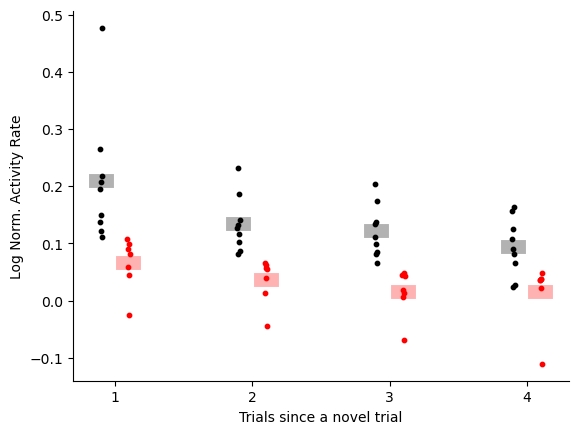

In [9]:
fig, ax = plt.subplots()

day = 4
s=10
lw=10



for tpost in range(1,5):


    ctrl = np.array([np.nanmean([np.nanmean(ar_all.ctrl_data[mouse]['mu'][day][ar_all.ctrl_data[mouse]['trials_post_nov'][day]==tpost]) for day in range(5)]) for mouse in ar_all.ctrl_mice])
    ax.scatter(5*tpost + np.linspace(-0.05,0.05, num = len(ar_all.ctrl_mice)), ctrl, color = 'black', s=s)
    ax.plot(5*tpost + np.array([-.2,.2]), np.nanmean(ctrl)*np.ones([2,]), color='black', linewidth=lw, alpha=.3)

    ko = np.array([np.nanmean([np.nanmean(ar_all.ko_data[mouse]['mu'][day][ar_all.ko_data[mouse]['trials_post_nov'][day]==tpost]) for day in range(5)]) for mouse in ar_all.ko_mice ])
    ax.scatter(5*tpost +1 + np.linspace(-0.05,0.05, num = len(ar_all.ko_mice)), ko, color = 'red', s=s)
    ax.plot(5*tpost +1+ np.array([-.2,.2]), np.nanmean(ko)*np.ones([2,]), color='red', linewidth=lw, alpha=.3)
    
# mask = (ar_all.df['ko']==0) * (ar_all.df['trials_since_nov']>0) * (ar_all.df['trials_since_nov']<3)
ax.set_xticks([5*tpost +.5 for tpost in range(1,5)])
ax.set_xticklabels([1,2,3,4])
ax.set_xlabel('Trials since a novel trial')
ax.set_ylabel('Log Norm. Activity Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print(ar_all.df.columns)

fig.savefig(os.path.join(figdir,f"day{day}_act_v_trial_post_nov.pdf"))



# df['trials_since_nov_z'] = sp.stats.zscore(df['trials_since_nov']._values)
# df['ko_x_trials_since_nov_z'] = df['ko']._values*df['trials_since_nov_z']._values
# df['dz_x_trials_since_nov_z'] = df['dz']._values*df['trials_since_nov_z']._values
# lmm_res = MixedLM(df['mu'], df[['dz', 'ko','day_x_ko',
#                                 'trials_since_nov_z','ko_x_trials_since_nov_z', 
#                                 'dz_x_trials_since_nov_z','intercept']], df['mouse'])
# lmm_resf = lmm_res.fit()
# print(lmm_resf.summary())
# print(df.columns)

mask = (ar_all.df['trials_since_nov']>0) * (ar_all.df['trials_since_nov']<4) * (ar_all.df['ko']==0)
df = ar_all.df[mask]

aov = rm_anova(data = df, dv = 'mu', within=['day','trials_since_nov'],subject = 'mouse')
print(aov)
# # mixed_anova(data=self.df[self.df['day']<5], dv='mu', between='ko', within='day', subject='m')

In [21]:
ar_nov = ActivityRate(days = np.arange(6), block=5, pos_bin=True, pos_avg=True, novel_only=True, fam_only=False)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/tmp/ipykernel_2427998/1276325678.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({'ko': 0,
/tmp/ipykernel_2427998/1276325678.py:219: Fut

In [22]:
results = ar_nov.mixed_anova()
results['anova']['p-unc'].iloc[0]

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0           ko  0.593781    1   14  0.593781  37.458106  0.000026  0.727934   
1          day  0.080738    4   56  0.020184   4.135795  0.005259  0.228046   
2  Interaction  0.031517    4   56  0.007879   1.614444  0.183381  0.103394   

        eps  
0       NaN  
1  0.640038  
2       NaN  
    Contrast  day    A    B Paired  Parametric         T        dof  \
0        day    -  0.0  1.0   True        True -0.600183  15.000000   
1        day    -  0.0  2.0   True        True -0.664728  15.000000   
2        day    -  0.0  3.0   True        True -2.673927  15.000000   
3        day    -  0.0  4.0   True        True -2.808930  15.000000   
4        day    -  1.0  2.0   True        True -0.192932  15.000000   
5        day    -  1.0  3.0   True        True -2.635703  15.000000   
6        day    -  1.0  4.0   True        True -4.214708  15.000000   
7        day    -  2.0  3.0   Tr

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

2.6492824869639065e-05

Day 0
-3.7358572984615006 0.00221446840893713
Day 1
-4.57343823966761 0.0004338638247175238
Day 2
-4.363635871982784 0.0006487027925069311
Day 3
-3.7415749410389756 0.0021895657214768016
Day 4
-4.268904489772474 0.0007790640015816336


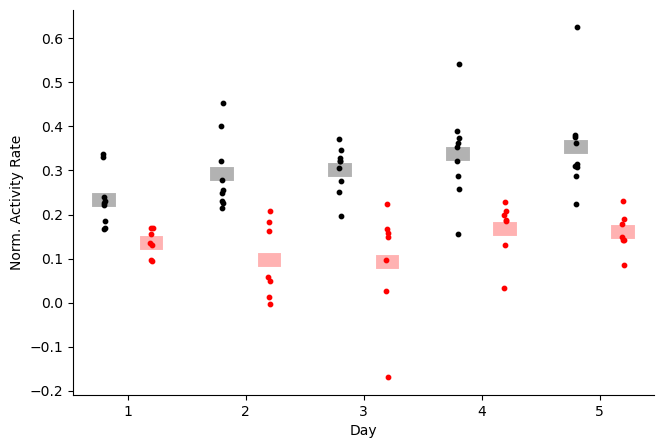

In [23]:
fig, ax = plt.subplots(figsize=[7.5,5])
lw = 10
s=10
for day in ar_nov.days[:5]:
    ctrl = np.array([np.nanmean(ar_nov.ctrl_data[mouse]['mu'][day]) for mouse in ar_nov.ctrl_mice])
    ax.scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(ar_nov.ctrl_mice)), ctrl, color = 'black', s=s)
    ax.plot(5*day  -1 + np.array([-0.2,0.2]), ctrl.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    ko = np.array([np.nanmean(ar_nov.ko_data[mouse]['mu'][day]) for mouse in ar_nov.ko_mice])
    ax.scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(ar_nov.ko_mice)), ko, color = 'red', s=s)
    ax.plot(5*day  +1 + np.array([-0.2,0.2]), ko.mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3)
    
    
    
    t,p = sp.stats.ttest_ind(ko,ctrl)
    print('Day', day)
    print(t,p)
    

ax.set_ylabel('Norm. Activity Rate')
ax.set_xlabel('Day')
ax.set_xticks(5*np.arange(5))
ax.set_xticklabels(np.arange(1,6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir,"novel_activity_rate_summary.pdf"),format='pdf')

Day 0
-3.7358572984615024 0.002214468408937122
Day 1
-4.57343823966761 0.0004338638247175238
Day 2
-4.363635871982786 0.0006487027925069277
Day 3
-3.741574941038975 0.0021895657214768055
Day 4
-4.268904489772475 0.0007790640015816308
Day 5
-2.342173842030269 0.03447364942153325


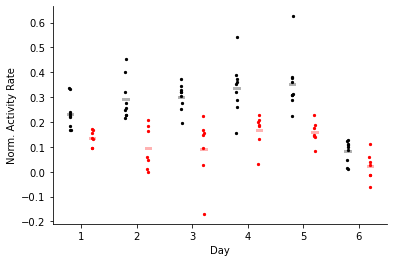

In [16]:
fig, ax = plt.subplots()
lw = 3
s=5
for day in ar_nov.days:
    ctrl = np.array([np.nanmean(ar_nov.ctrl_data[mouse]['mu'][day]) for mouse in ar_nov.ctrl_mice])
    ax.scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(ar_nov.ctrl_mice)), ctrl, color = 'black', s=s)
    ax.plot(5*day  -1 + np.array([-0.2,0.2]), ctrl.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    ko = np.array([np.nanmean(ar_nov.ko_data[mouse]['mu'][day]) for mouse in ar_nov.ko_mice])
    ax.scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(ar_nov.ko_mice)), ko, color = 'red', s=s)
    ax.plot(5*day  +1 + np.array([-0.2,0.2]), ko.mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3)
    
    
    
    t,p = sp.stats.ttest_ind(ko,ctrl)
    print('Day', day)
    print(t,p)
    

ax.set_ylabel('Norm. Activity Rate')
ax.set_xlabel('Day')
ax.set_xticks(5*np.arange(6))
ax.set_xticklabels(np.arange(1,7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylim([0.5,2.4])
# fig.savefig(os.path.join(figdir,"novel_activity_rate_summary_6days.pdf"),format='pdf')

0


/tmp/ipykernel_896112/2103249567.py:29: RuntimeWarning: Mean of empty slice
  mu,sem = np.nanmean(ko_rate,axis=0), sp.stats.sem(ko_rate,axis=0,nan_policy='omit')


1
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt

2


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt

3
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt

4


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt

5


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.s

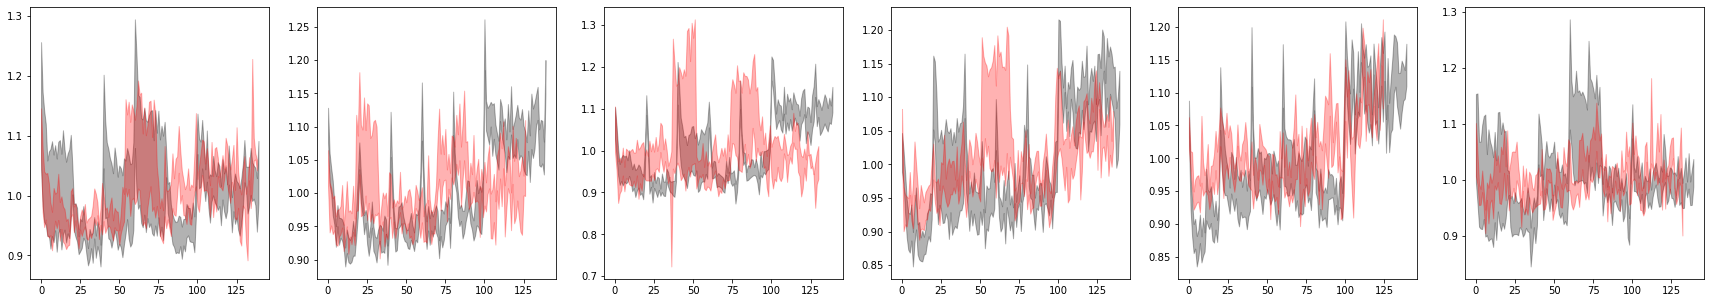

In [30]:
fig,ax = plt.subplots(1,6, figsize=[30,5])

for day in range(6):
    print(day)
    ctrl_rate = np.zeros([len(ctrl_mice),140])*np.nan
    for m, mouse in enumerate(ctrl_mice):
        sess = u.load_single_day(mouse,day,verbose=False)

        ntrials = sess.trial_matrices['spks'].shape[0]
        spks = sess.trial_matrices['spks']
        mu = np.nanmean(np.nanmean(spks,axis=1,keepdims=True),axis=0,keepdims=True)
    #     print(ntrials)
        ctrl_rate[m,:ntrials] = np.nanmean(np.nanmean(spks,axis=1,keepdims=True)/mu,axis=-1).ravel()
    #     ax.plot(np.arange(ntrials), np.nanmean(np.nanmean(spks,axis=1,keepdims=True)/mu,axis=-1).ravel(), color='black')

    ko_rate = np.zeros([len(ko_mice),140])*np.nan
    for m, mouse in enumerate(ko_mice):
        sess = u.load_single_day(mouse,day,verbose=False)

        ntrials = sess.trial_matrices['spks'].shape[0]
        spks = sess.trial_matrices['spks']
        mu = np.nanmean(np.nanmean(spks,axis=1,keepdims=True),axis=0,keepdims=True)
        ko_rate[m,:ntrials] = np.nanmean(np.nanmean(spks,axis=1,keepdims=True)/mu,axis=-1).ravel()
    #     ax.plot(np.arange(ntrials), np.nanmean(np.nanmean(spks,axis=1,keepdims=True)/mu,axis=-1).ravel(), color='red')

    mu,sem = np.nanmean(ctrl_rate,axis=0), sp.stats.sem(ctrl_rate,axis=0,nan_policy='omit')
    ax[day].fill_between(np.arange(140),mu-sem,mu+sem, color='black', alpha = .3)

    mu,sem = np.nanmean(ko_rate,axis=0), sp.stats.sem(ko_rate,axis=0,nan_policy='omit')
    ax[day].fill_between(np.arange(140),mu-sem,mu+sem, color='red', alpha=.3)

/tmp/ipykernel_2427998/1276325678.py:294: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')


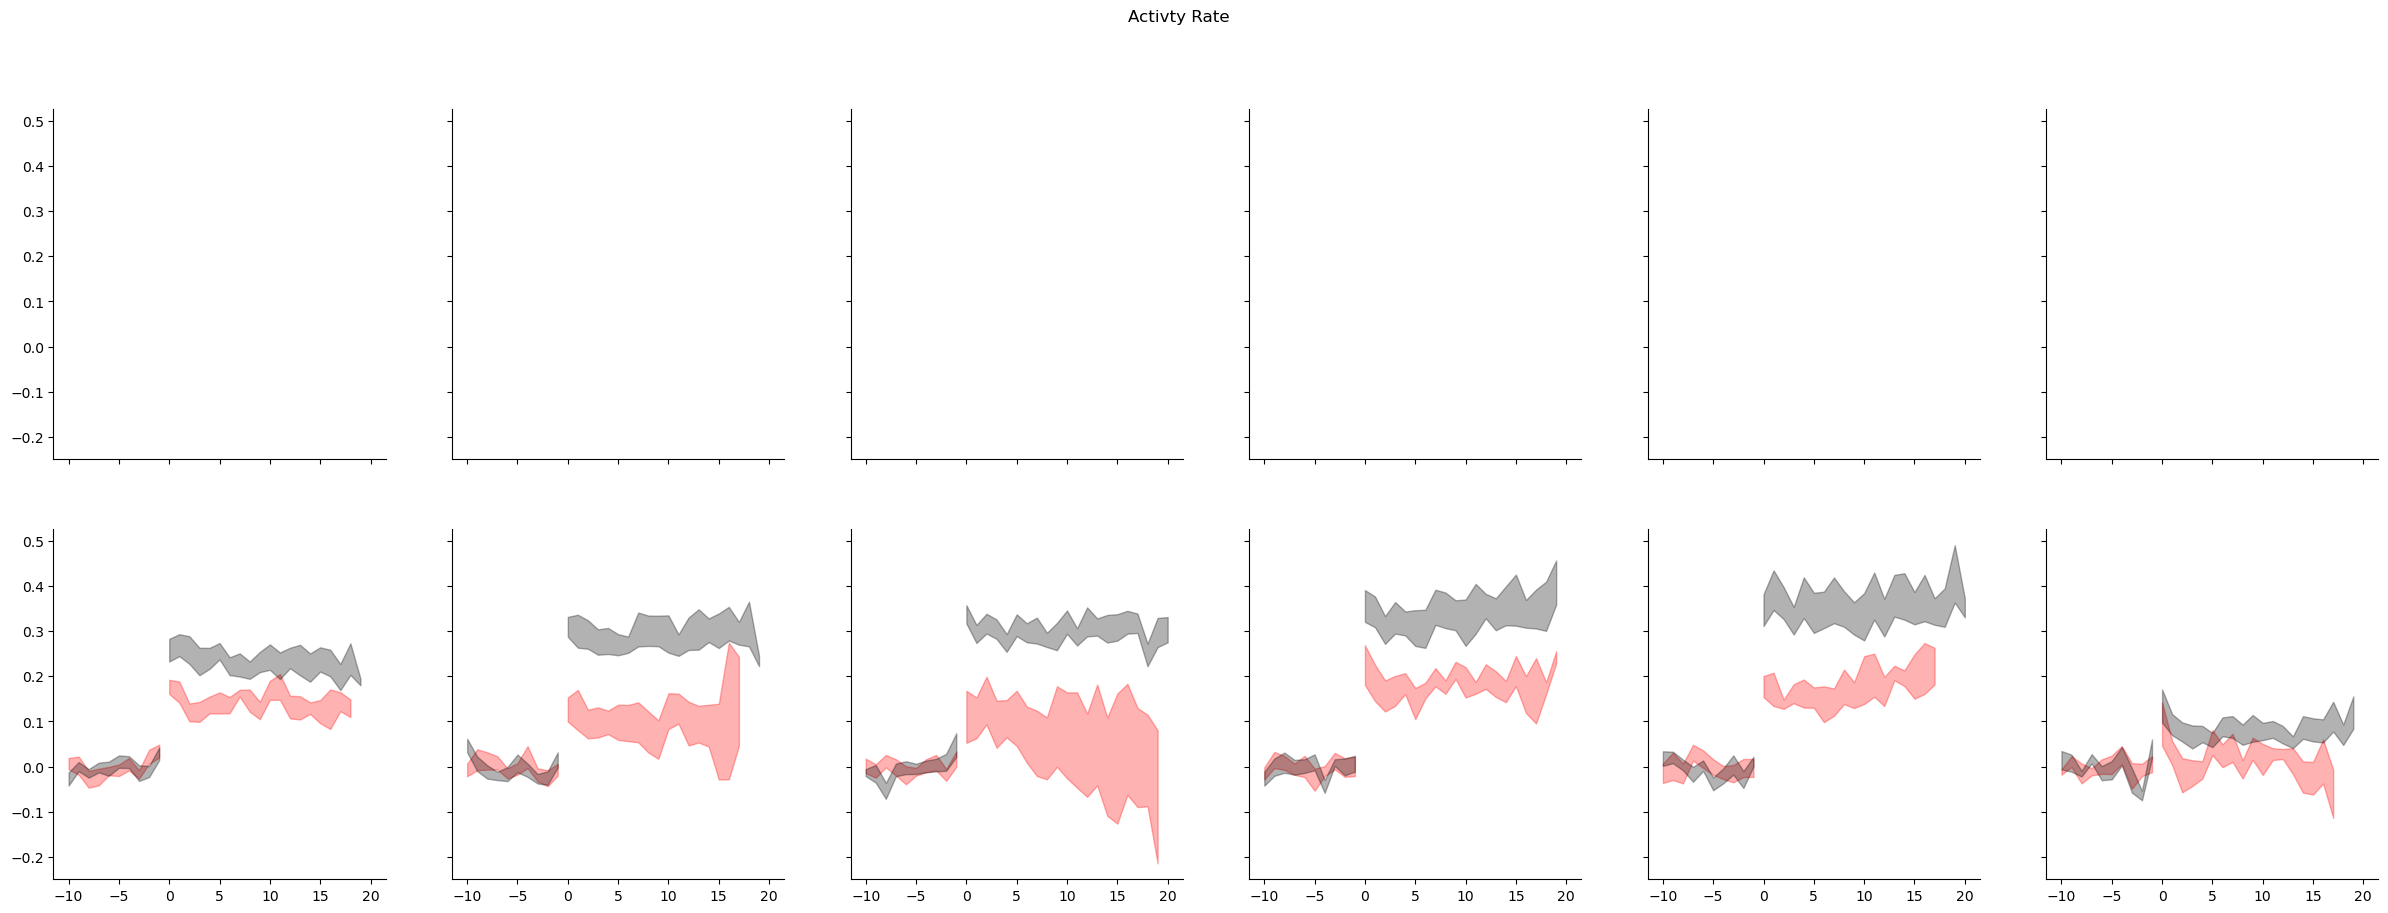

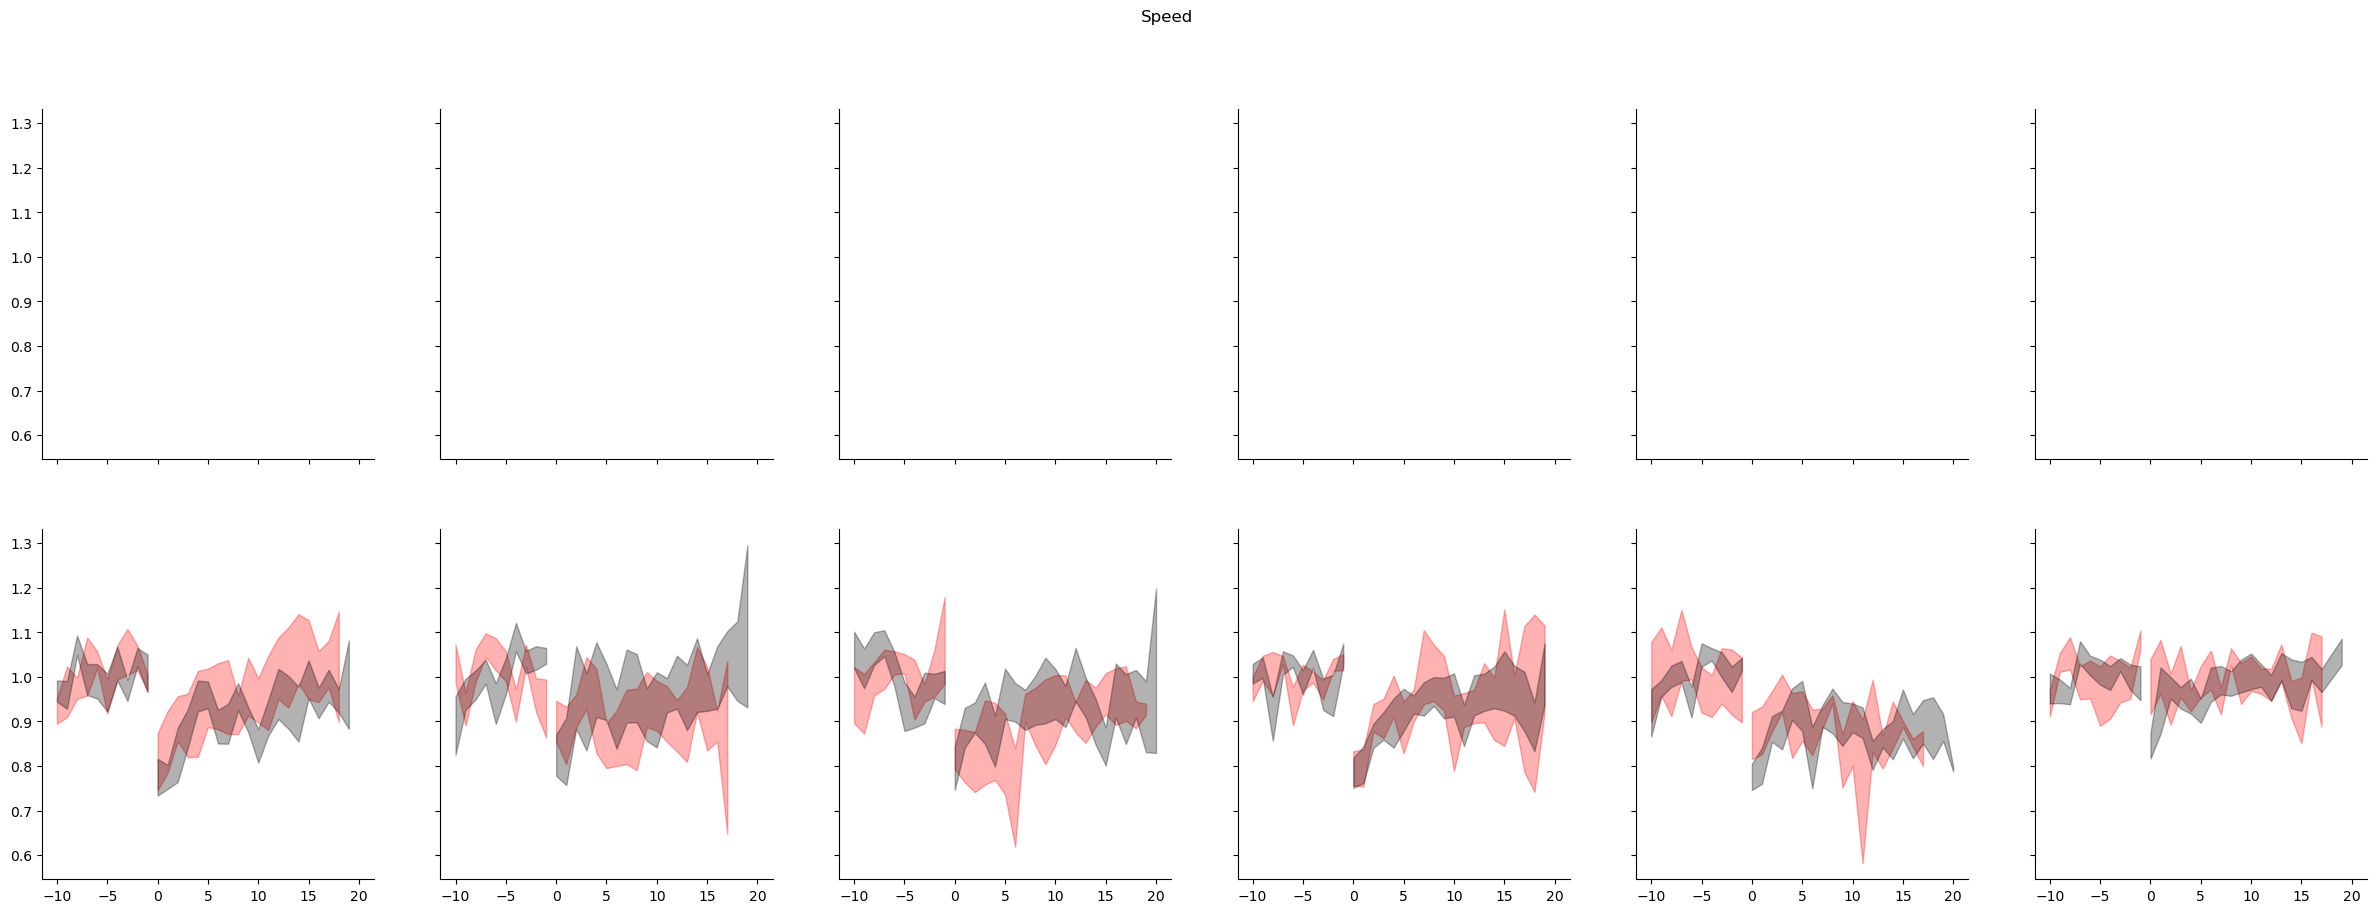

In [24]:
(fig_mu, ax_mu), (fig_speed, ax_speed) = ar_nov.plot_activity_rates()
fig_mu.savefig(os.path.join(figdir,'novel_only_block5_activity.pdf'),format='pdf')
fig_speed.savefig(os.path.join(figdir,'novel_only_block5_speed.pdf'),format='pdf')


In [32]:
ar = ActivityRate(days = np.arange(6), block=2, pos_bin=True, pos_avg=True, novel_only=False, fam_only=True, t_post=20)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel


/tmp/ipykernel_2718184/1276325678.py:54: RuntimeWarning: Mean of empty slice
  baseline_mu = (np.nanmean(baseline_tmat, axis=1, keepdims=True)/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)).mean(axis=-1).ravel()
/tmp/ipykernel_2718184/1276325678.py:56: RuntimeWarning: Mean of empty slice
  mu[:tmat.shape[0]] = (np.nanmean(tmat, axis=1, keepdims=True)/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)).mean(axis=-1).ravel()
/tmp/ipykernel_2718184/1276325678.py:59: RuntimeWarning: Mean of empty slice.
  _speed = np.nanmean(sess.trial_matrices['speed'][last_block_ind:last_block_ind+t_post,:],axis=-1)/_baseline_speed.mean(axis=0,keepdims=True)
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_2718184/1276325678.py:68: RuntimeWarning: Mean of empty slice.
  baseline_speed = _baseline_speed/_b

30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/tmp/ipykernel_2718184/1276325678.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({'ko': 0,
/tmp/ipykernel_2718184/1276325678.py:219: Fut

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9,) + inhomogeneous part.

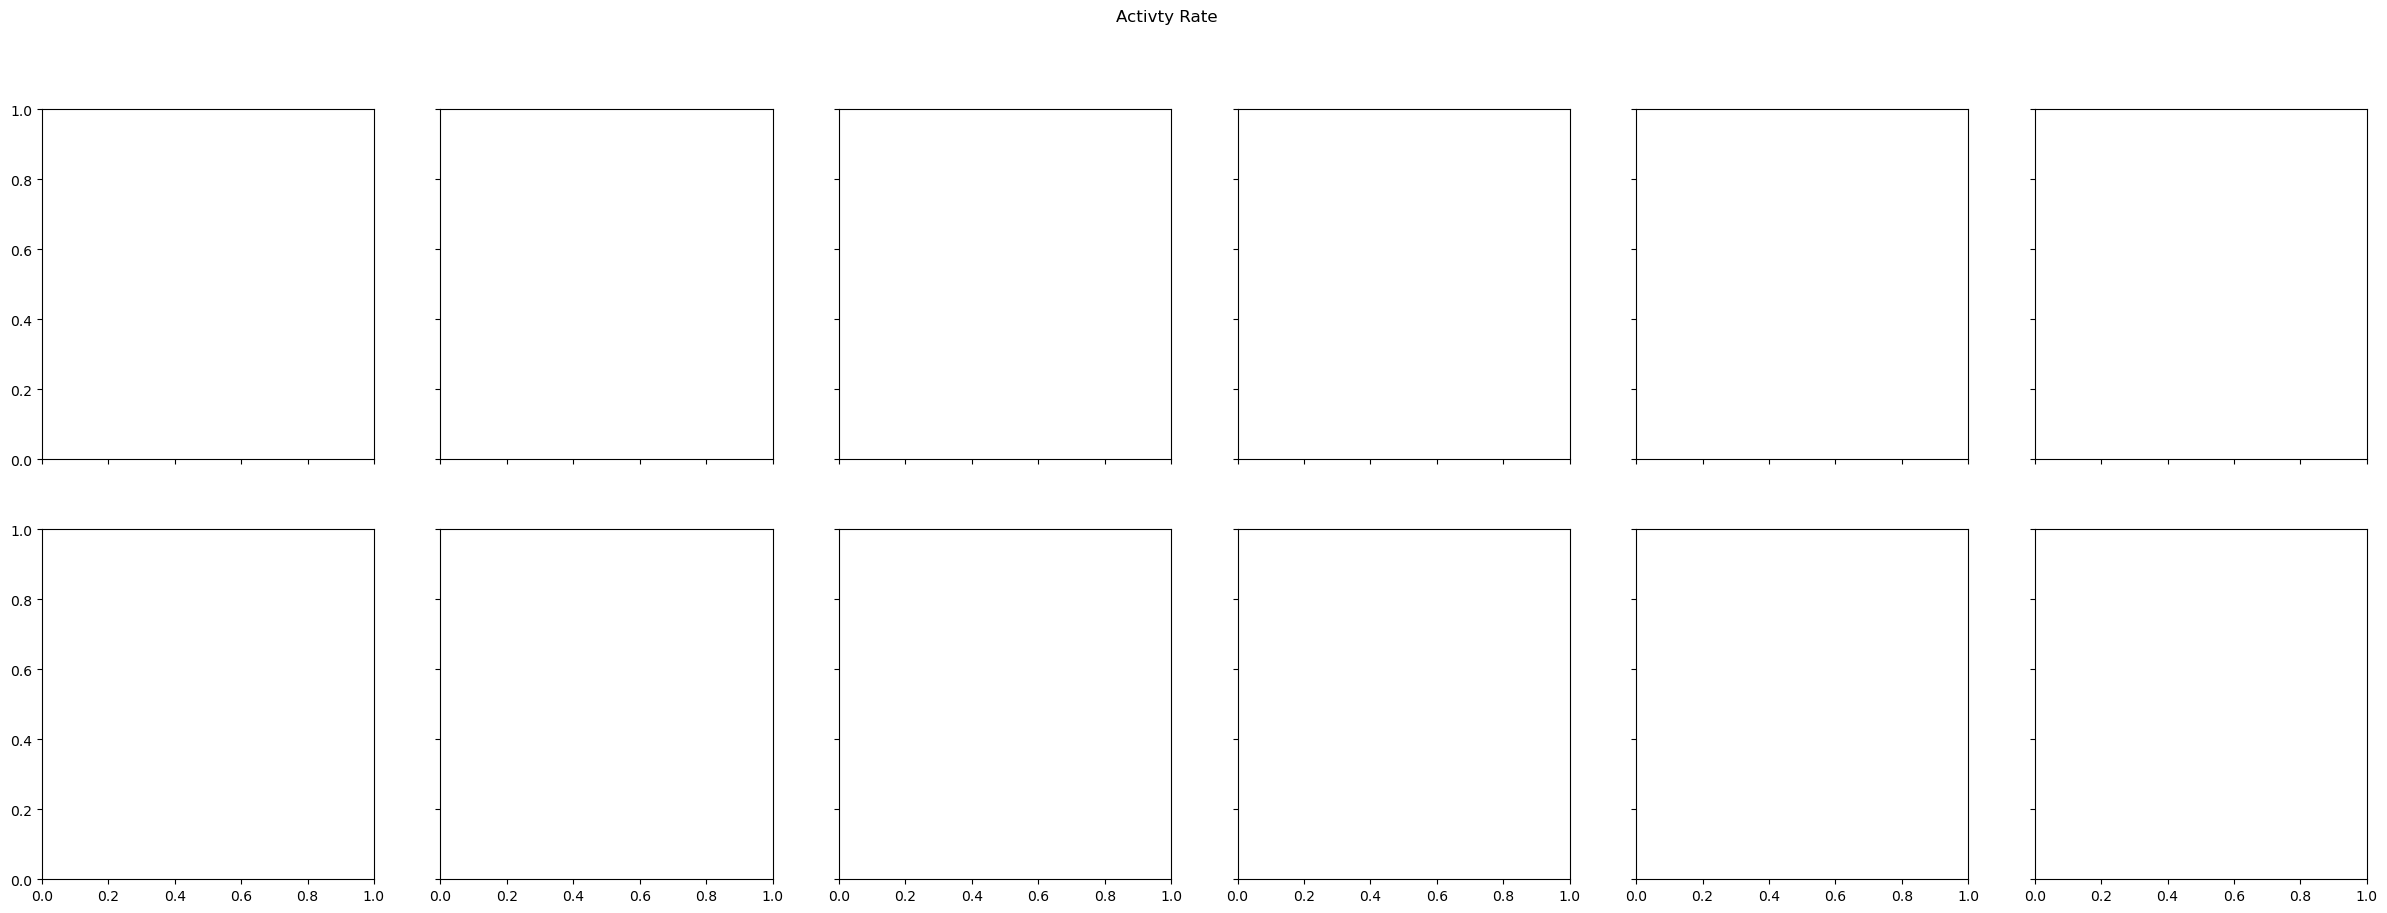

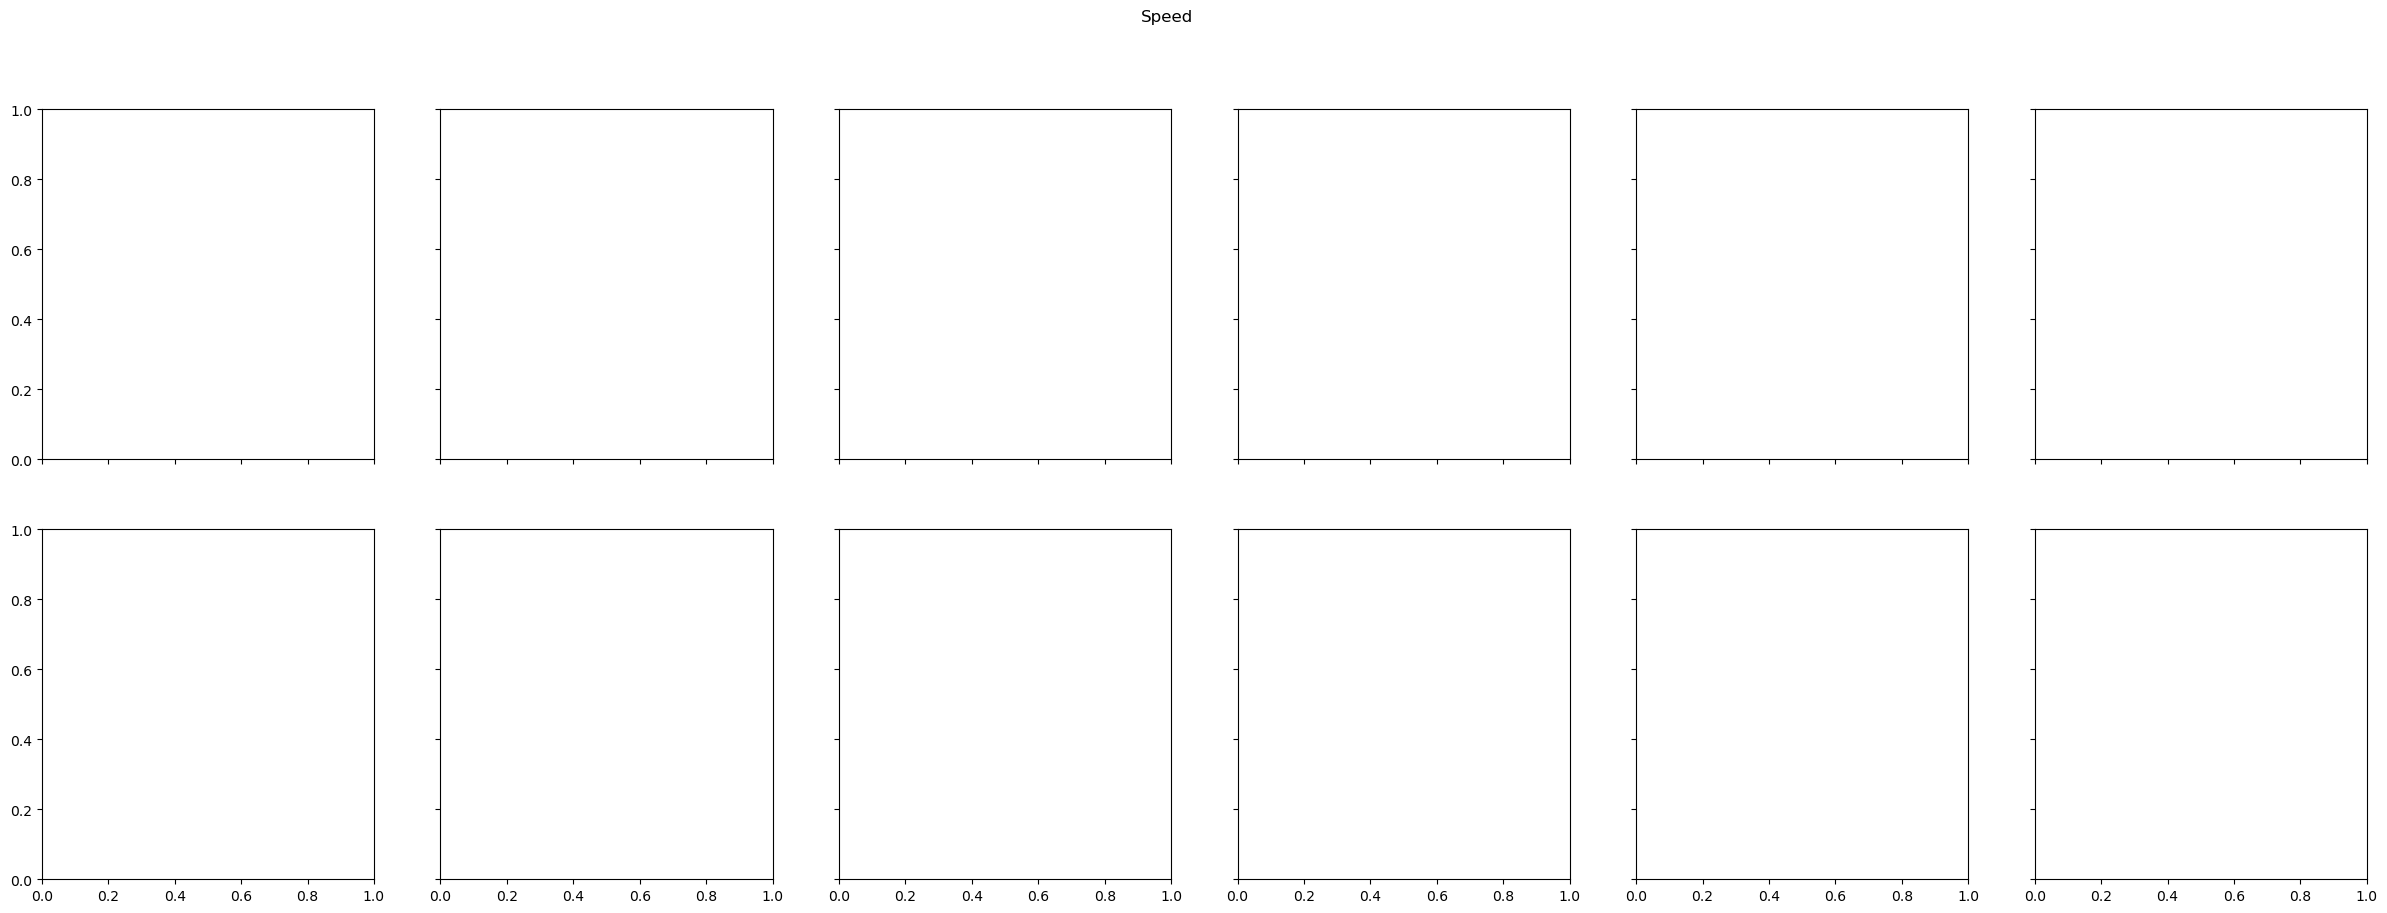

In [34]:
(fig_mu, ax_mu), (fig_speed, ax_speed) = ar.plot_activity_rates()
fig_mu.savefig(os.path.join(figdir,'fam_only_block3_activity.pdf'),format='pdf')
# fig_speed.savefig(os.path.join(figdir,'fam_only_block3_speed.pdf'),format='pdf')


In [ ]:
ar.mixed_anova()

Day 0
nan nan
Day 1
-1.55761968909285 0.1416361332513624
Day 2
-0.7247569516305106 0.48053962136436834
Day 3
-0.045106009796196146 0.9646598805870531
Day 4
-0.07017848191773482 0.9450441975404524
Day 5
-1.1188744352048068 0.2820243563836776


/tmp/ipykernel_2427998/2412473628.py:6: RuntimeWarning: Mean of empty slice
  ctrl = np.array([np.nanmean(ar.ctrl_data[mouse]['mu'][day]) for mouse in ar.ctrl_mice])


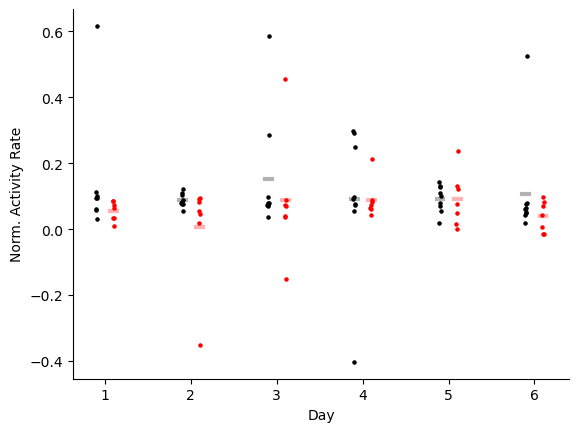

In [28]:
fig, ax = plt.subplots()
for day in ar.days:
   
    
    
    ctrl = np.array([np.nanmean(ar.ctrl_data[mouse]['mu'][day]) for mouse in ar.ctrl_mice])
    ax.scatter(5*day-.5 + np.linspace(-0.05,0.05, num = len(ar.ctrl_mice)), ctrl, color = 'black', s=5)
    ax.plot(5*day  -.5 + np.array([-0.2,0.2]), ctrl.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    ko = np.array([np.nanmean(ar.ko_data[mouse]['mu'][day]) for mouse in ar.ko_mice])
    ax.scatter(5*day+.5 + np.linspace(-0.05,0.05, num = len(ar.ko_mice)), ko, color = 'red', s=5)
    ax.plot(5*day  +.5 + np.array([-0.2,0.2]), ko.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    
    
    
    t,p = sp.stats.ttest_ind(ko,ctrl)
    print('Day', day)
    print(t,p)
    

ax.set_ylabel('Norm. Activity Rate')
ax.set_xlabel('Day')
ax.set_xticks(5*np.arange(6))
ax.set_xticklabels(np.arange(1,7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylim([0.5,2.4])
# fig.savefig(os.path.join(figdir,"alldays_block3actrate.pdf"),format = 'pdf')

In [23]:
ar_fam = ActivityRate(days = np.arange(6), block=5, pos_bin=True, pos_avg=True, novel_only=False, fam_only=True)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


In [24]:
ar_fam.mixed_anova()

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0           ko  0.290411    1   14  0.290411  18.123158  0.000797  0.564177   
1          day  0.014975    4   56  0.003744   0.897469  0.471706  0.060243   
2  Interaction  0.017454    4   56  0.004363   1.046043  0.391821  0.069523   

        eps  
0       NaN  
1  0.593455  
2       NaN  
    Contrast  day    A    B Paired  Parametric         T        dof  \
0        day    -  0.0  1.0   True        True  0.115236  15.000000   
1        day    -  0.0  2.0   True        True  0.796893  15.000000   
2        day    -  0.0  3.0   True        True -1.023976  15.000000   
3        day    -  0.0  4.0   True        True -0.337857  15.000000   
4        day    -  1.0  2.0   True        True  1.022177  15.000000   
5        day    -  1.0  3.0   True        True -1.188815  15.000000   
6        day    -  1.0  4.0   True        True -0.602833  15.000000   
7        day    -  2.0  3.0   Tr

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc       np2  \
 0           ko  0.290411    1   14  0.290411  18.123158  0.000797  0.564177   
 1          day  0.014975    4   56  0.003744   0.897469  0.471706  0.060243   
 2  Interaction  0.017454    4   56  0.004363   1.046043  0.391821  0.069523   
 
         eps  
 0       NaN  
 1  0.593455  
 2       NaN  ,
 'posthoc':     Contrast  day    A    B Paired  Parametric         T        dof  \
 0        day    -  0.0  1.0   True        True  0.115236  15.000000   
 1        day    -  0.0  2.0   True        True  0.796893  15.000000   
 2        day    -  0.0  3.0   True        True -1.023976  15.000000   
 3        day    -  0.0  4.0   True        True -0.337857  15.000000   
 4        day    -  1.0  2.0   True        True  1.022177  15.000000   
 5        day    -  1.0  3.0   True        True -1.188815  15.000000   
 6        day    -  1.0  4.0   True        True -0.602833  15.000000   
 7        day    -  2

Day 0
-3.2031601893468378 0.00638031469861082
Day 1
-3.7083297787503553 0.002338439172905182
Day 2
-3.1644692827302277 0.006890564552654331
Day 3
-2.920275559886991 0.01118466083995802
Day 4
-2.5553510930728143 0.02287867879181479
Day 5
-1.9230537415060827 0.0750543094533984


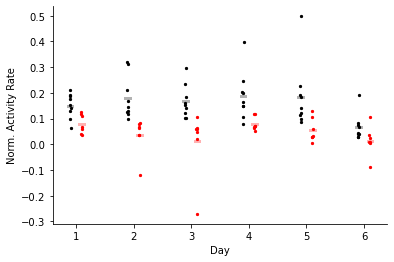

In [26]:
fig, ax = plt.subplots()
for day in ar_fam.days:
   
    
    
    ctrl = np.array([np.nanmean(ar_fam.ctrl_data[mouse]['mu'][day]) for mouse in ar_fam.ctrl_mice])
    ax.scatter(5*day-.5 + np.linspace(-0.05,0.05, num = len(ar_fam.ctrl_mice)), ctrl, color = 'black', s=5)
    ax.plot(5*day  -.5 + np.array([-0.2,0.2]), ctrl.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    ko = np.array([np.nanmean(ar_fam.ko_data[mouse]['mu'][day]) for mouse in ar_fam.ko_mice])
    ax.scatter(5*day+.5 + np.linspace(-0.05,0.05, num = len(ar_fam.ko_mice)), ko, color = 'red', s=5)
    ax.plot(5*day  +.5 + np.array([-0.2,0.2]), ko.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    
    
    
    t,p = sp.stats.ttest_ind(ko,ctrl)
    print('Day', day)
    print(t,p)
    

ax.set_ylabel('Norm. Activity Rate')
ax.set_xlabel('Day')
ax.set_xticks(5*np.arange(6))
ax.set_xticklabels(np.arange(1,7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylim([0.5,2.4])
# fig.savefig(os.path.join(figdir,"alldays_famactrate.pdf"),format = 'pdf')

In [27]:
ar_nov.df['nov'] = np.ones([ar_nov.df.shape[0],])
ar_fam.df['nov'] = np.zeros([ar_fam.df.shape[0],])

In [28]:
comb_df = pd.concat([ar_nov.df,ar_fam.df])

In [37]:
aov = rm_anova(data=comb_df[(comb_df['day']<5) & (comb_df['ko']==0)], dv='mu', within=['day', 'nov'], subject='m')
print(aov)
print(pairwise_ttests(comb_df[(comb_df['day']<5) & (comb_df['ko']==0)], dv='mu',  within=['day', 'nov'], subject='m',
                                           padjust='holm',parametric=True))

      Source        SS  ddof1  ddof2        MS           F         p-unc  \
0        day  0.066891      4     32  0.016723    1.989125  1.198966e-01   
1        nov  0.379117      1      8  0.379117  187.222419  7.840524e-07   
2  day * nov  0.020380      4     32  0.005095    5.726409  1.360197e-03   

      p-GG-corr       np2       eps  
0  1.795638e-01  0.199129  0.409719  
1  7.840524e-07  0.959021  1.000000  
2  2.996077e-03  0.417182  0.824532  
     Contrast  day    A    B Paired  Parametric          T  dof alternative  \
0         day    -  0.0  1.0   True        True  -1.662526  8.0   two-sided   
1         day    -  0.0  2.0   True        True  -2.332817  8.0   two-sided   
2         day    -  0.0  3.0   True        True  -1.989729  8.0   two-sided   
3         day    -  0.0  4.0   True        True  -1.834310  8.0   two-sided   
4         day    -  1.0  2.0   True        True   0.082850  8.0   two-sided   
5         day    -  1.0  3.0   True        True  -1.121148  8.0   two

In [38]:
aov = rm_anova(data=comb_df[(comb_df['day']<5) & (comb_df['ko']==1)], dv='mu', within=['day', 'nov'], subject='m')
print(aov)
print(pairwise_ttests(comb_df[(comb_df['day']<5) & (comb_df['ko']==1)], dv='mu',  within=['day', 'nov'], subject='m',
                                           padjust='holm',parametric=True))

      Source        SS  ddof1  ddof2        MS          F     p-unc  \
0        day  0.052270      4     24  0.013068   1.650201  0.194380   
1        nov  0.105361      1      6  0.105361  31.617629  0.001352   
2  day * nov  0.005141      4     24  0.001285   1.594365  0.208148   

   p-GG-corr       np2       eps  
0   0.242136  0.215707  0.362074  
1   0.001352  0.840500  1.000000  
2   0.246571  0.209941  0.446443  
     Contrast  day    A    B Paired  Parametric         T  dof alternative  \
0         day    -  0.0  1.0   True        True  1.475272  6.0   two-sided   
1         day    -  0.0  2.0   True        True  1.096051  6.0   two-sided   
2         day    -  0.0  3.0   True        True -0.713786  6.0   two-sided   
3         day    -  0.0  4.0   True        True  0.028639  6.0   two-sided   
4         day    -  1.0  2.0   True        True  0.467586  6.0   two-sided   
5         day    -  1.0  3.0   True        True -1.716629  6.0   two-sided   
6         day    -  1.0  4.0 

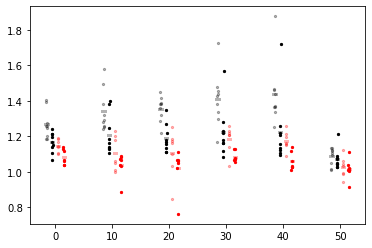

In [22]:
fig, ax = plt.subplots()
for day in ar_fam.days:
    ctrl = np.array([np.nanmean(ar_nov.ctrl_data[mouse]['mu'][day]) for mouse in ar_nov.ctrl_mice])
    ax.scatter(10*day-1.5 + np.linspace(-0.05,0.05, num = len(ar_nov.ctrl_mice)), ctrl, color = 'black', s=5, alpha = .3)
    ax.plot(10*day  -1.5 + np.array([-0.2,0.2]), ctrl.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    ctrl = np.array([np.nanmean(ar_fam.ctrl_data[mouse]['mu'][day]) for mouse in ar_fam.ctrl_mice])
    ax.scatter(10*day-.5 + np.linspace(-0.05,0.05, num = len(ar_fam.ctrl_mice)), ctrl, color = 'black', s=5, alpha=1)
    ax.plot(10*day  -.5 + np.array([-0.2,0.2]), ctrl.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    ko = np.array([np.nanmean(ar_nov.ko_data[mouse]['mu'][day]) for mouse in ar_nov.ko_mice])
    ax.scatter(10*day+.5 + np.linspace(-0.05,0.05, num = len(ar_nov.ko_mice)), ko, color = 'red', s=5, alpha=.3)
    ax.plot(10*day  +.5 + np.array([-0.2,0.2]), ko.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    
    ko = np.array([np.nanmean(ar_fam.ko_data[mouse]['mu'][day]) for mouse in ar_fam.ko_mice])
    ax.scatter(10*day+1.5 + np.linspace(-0.05,0.05, num = len(ar_fam.ko_mice)), ko, color = 'red', s=5, alpha=1)
    ax.plot(10*day  +1.5 + np.array([-0.2,0.2]), ko.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    
    

In [23]:
df = ar_nov.df
df

/tmp/ipykernel_896112/1377455592.py:263: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr,axis=axis), sp.stats.sem(arr, axis=axis, nan_policy='omit')


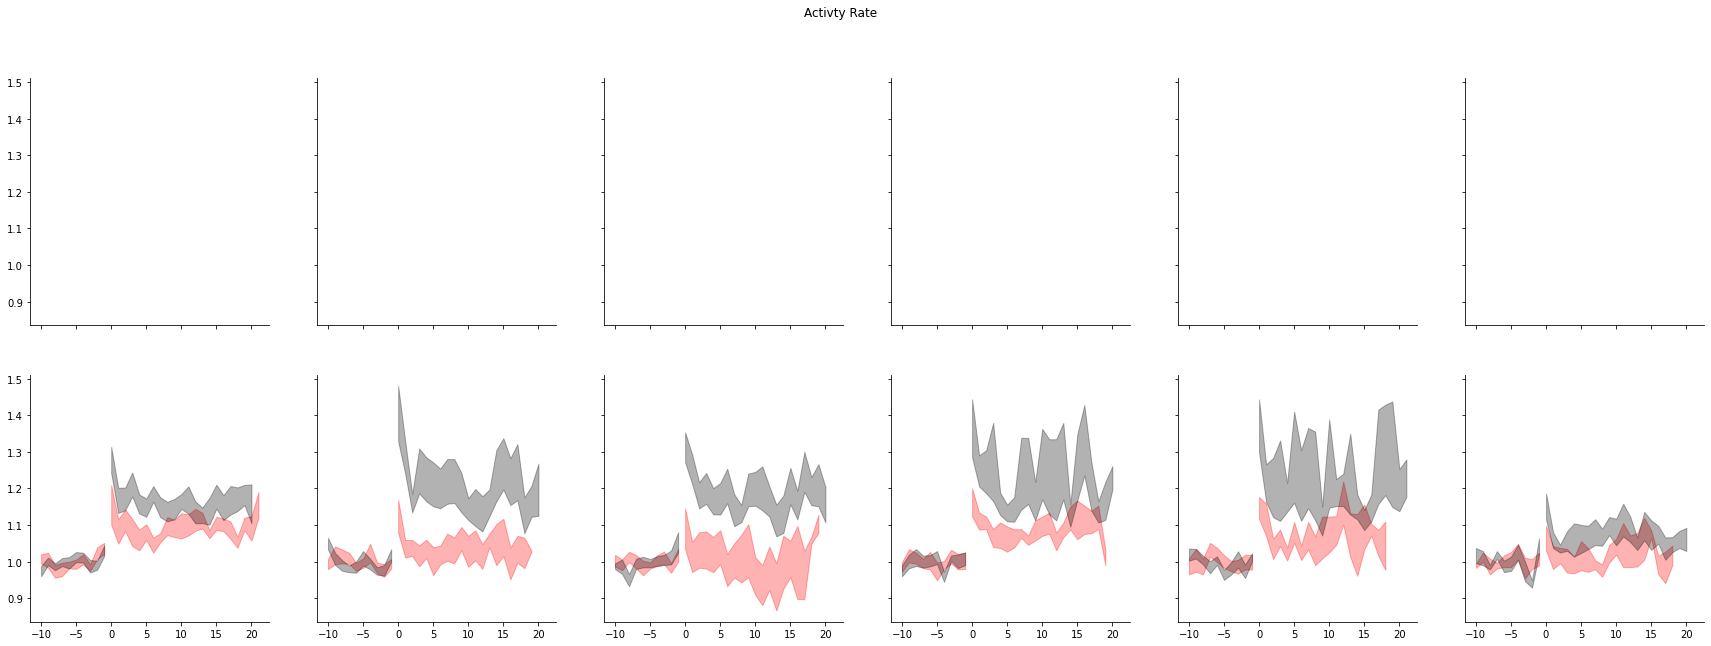

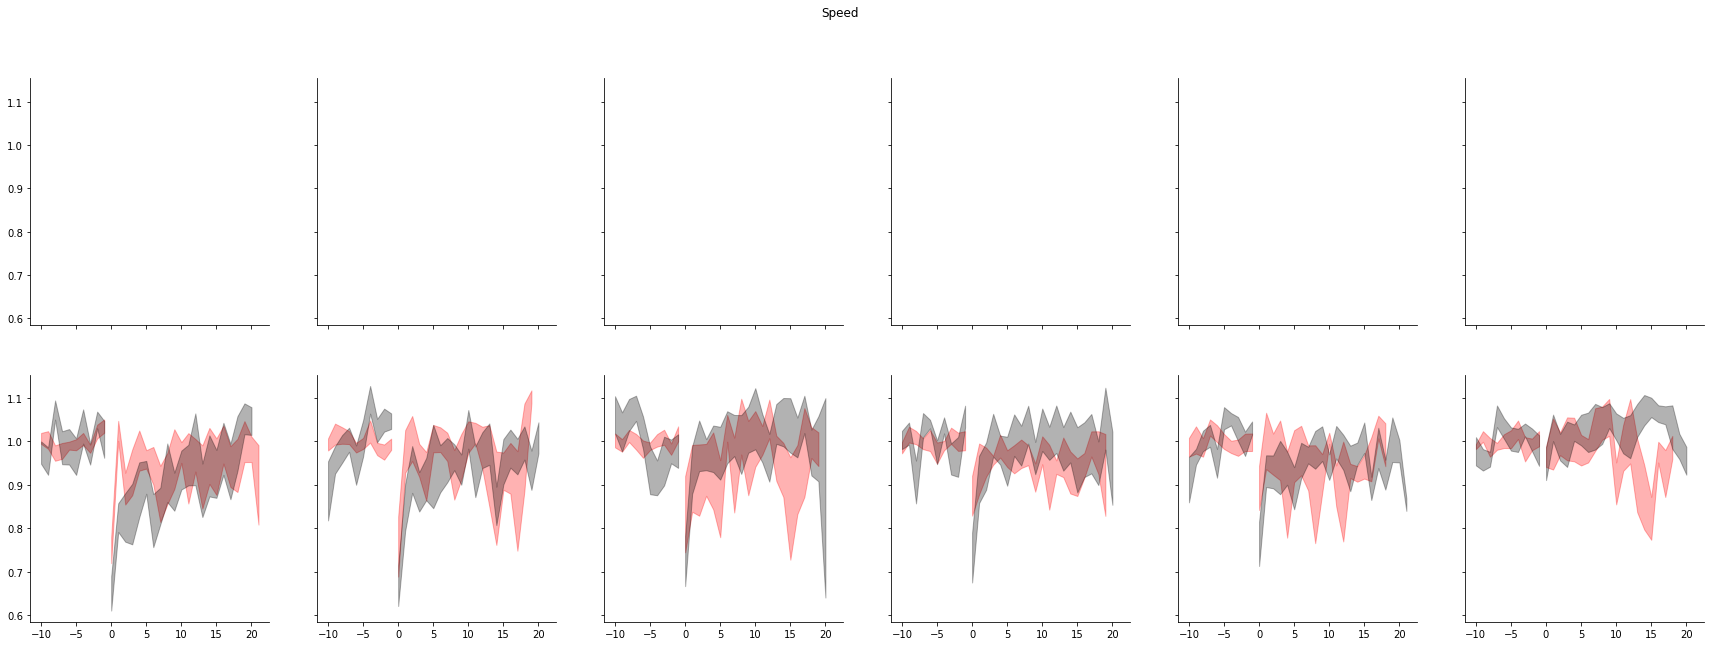

In [37]:
(fig_mu, ax_mu), (fig_speed, ax_speed) = ar.plot_activity_rates()
fig_mu.savefig(os.path.join(figdir,'fam_only_block5_activity.pdf'),format='pdf')
fig_speed.savefig(os.path.join(figdir,'fam_only_block5_speed.pdf'),format='pdf')

In [30]:
def activity_rate_hist(sess, x= np.linspace(0,4,num=100)):
    last_block_ind = np.argwhere(sess.trial_info['block_number']==5)[0][0]
    _lr = sess.trial_info['LR'][last_block_ind:]

    baseline_tmat = np.nanmean(np.nanmean(sess.trial_matrices['spks'][last_block_ind-10:last_block_ind,:,:],axis=0,keepdims=True),axis=1,keepdims=True)
    tmat = sess.trial_matrices['spks'][last_block_ind:,:,:]
    tmat = np.log(np.nanmean(np.nanmean(tmat[_lr==sess.novel_arm,:,:]/baseline_tmat,axis=0),axis=0))
#     tmat = np.nanmean(np.nanmean(tmat[_lr==sess.novel_arm,:,:]/baseline_tmat,axis=0),axis=0)
    
    hist_sm = tpu.utilities.gaussian(tmat[:,np.newaxis], .1, x[np.newaxis,:]).mean(axis=0)
    hist_sm /=hist_sm.sum()
    return hist_sm
    

day 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

day 1
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

day 2


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

day 3
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

day 4


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUti

day 5


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/T

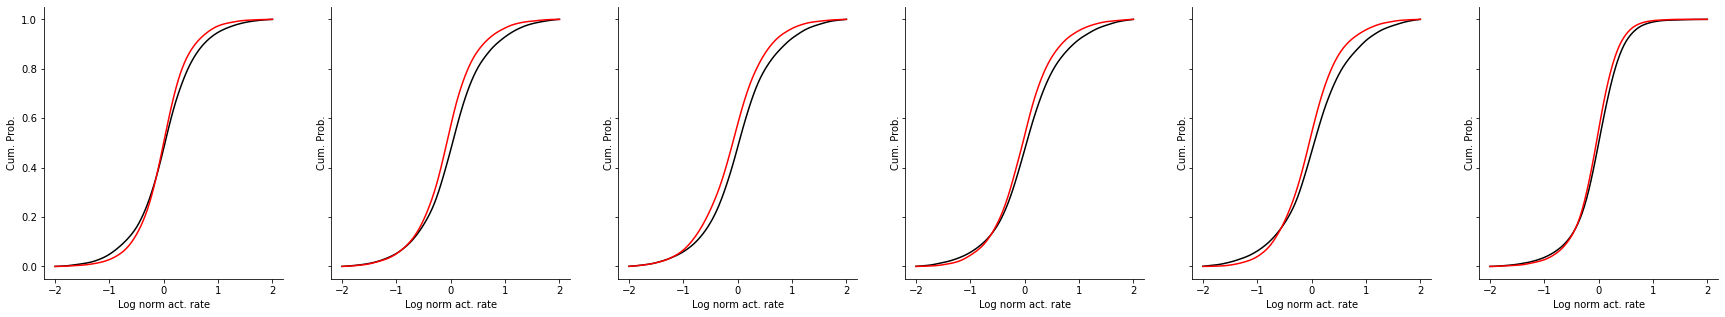

In [32]:
fig,ax = plt.subplots(1,6, figsize = [30,5], sharey=True, sharex=True)


x = np.linspace(-2,2,num=100)
for day in range(6):
    print("day %d" % day)
    hist_sm = 0
    for mouse in ctrl_mice:
        hist_sm += activity_rate_hist(u.load_single_day(mouse,day, verbose=False),x=x)
    
    ax[day].plot(x,np.cumsum(hist_sm/hist_sm.sum()),color='black',alpha=1)

    hist_sm = 0
    for mouse in ko_mice:
        hist_sm += activity_rate_hist(u.load_single_day(mouse,day, verbose = False),x=x)
    ax[day].plot(x,np.cumsum(hist_sm/hist_sm.sum()),color='red',alpha=1)
        
    ax[day].set_xlabel('Log norm act. rate')
    ax[day].set_ylabel('Cum. Prob.')
    ax[day].spines['top'].set_visible(False)
    ax[day].spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,'logactrate_cumdist.pdf'),format='pdf')

(1, 1, 962)


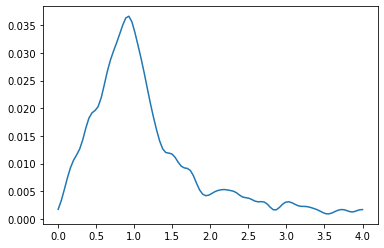

In [26]:
last_block_ind = np.argwhere(sess.trial_info['block_number']==5)[0][0]
_lr = sess.trial_info['LR'][last_block_ind:]

baseline_tmat = np.nanmean(np.nanmean(sess.trial_matrices['spks'][last_block_ind-10:last_block_ind,:,:],axis=0,keepdims=True),axis=1,keepdims=True)
print(baseline_tmat.shape)
tmat = sess.trial_matrices['spks'][last_block_ind:,:,:]
tmat = np.nanmean(np.nanmean(tmat[_lr==sess.novel_arm,:,:]/baseline_tmat,axis=0),axis=0)

fig,ax=plt.subplots()

x = np.linspace(0,4,num=100)
hist_sm = tpu.utilities.gaussian(tmat[:,np.newaxis], .1, x[np.newaxis,:]).mean(axis=0)
hist_sm /=hist_sm.sum()
ax.plot(x,hist_sm)


               
# baseline_mu = (np.nanmean(baseline_tmat, axis=1, keepdims=True)/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)).mean(axis=-1).ravel()
# mu[:tmat.shape[0]] = (np.nanmean(tmat, axis=1, keepdims=True)/np.nanmean(np.nanmean(baseline_tmat, axis=0, keepdims=True), axis=1, keepdims=True)).mean(axis=-1).ravel()


In [ ]:
mouse, day = ar.ko_mice[2], 3
lr = ar.ko_data[mouse]['famnov'][day]
mu = np.nanmean(ar.ko_data[mouse]['mu'][day], axis=1)
fig, ax = plt.subplots(2,2, figsize= [10,10], sharex = True)
ax[0, 0].scatter(mu[lr==1,:].mean(axis=0), ar.ko_data[mouse]['place_cell_info'][day]['right']['SI'])
ax[0, 0].vlines(1, 0, 1.2, color='red')
r,p = sp.stats.spearmanr(mu[lr==1,:].mean(axis=0), ar.ko_data[mouse]['place_cell_info'][day]['right']['SI'])
print('right', r, p)



ax[0,1].scatter(mu[lr==1,:].mean(axis=0), ar.ko_data[mouse]['place_cell_info'][day]['left']['SI'])
r,p = sp.stats.spearmanr(mu[lr==1,:].mean(axis=0), ar.ko_data[mouse]['place_cell_info'][day]['left']['SI'])
print('left', r, p)

In [ ]:
print(res)

In [ ]:


ctrl_mu, ctrl_bmu, speed, _, ctrl_lr = ar.make_plot_arr(ar.ctrl_data,0)
ko_mu, ko_bmu, speed, _, ko_lr = ar.make_plot_arr(ar.ko_data,0)

In [ ]:
print(ctrl_mu.shape, ko_mu.shape)
print(ctrl_bmu.shape, ko_bmu.shape)

In [ ]:
for i in range(5):
    fig,ax = plt.subplots(1,4, figsize= [20,5])
    fig.subplots_adjust(wspace=.5)
    combined_mu = np.log(np.concatenate((ctrl_bmu[i,:,:], ctrl_mu[i,:,:]), axis=0))
    mu = np.log(ctrl_mu[i,:,:])
    mask = ctrl_lr[i,:] ==1
    h = ax[0].imshow(combined_mu, vmin=-1, vmax=1, cmap='seismic')
    fig.colorbar(h,ax = ax[0])
    ax[0].set_yticks([0, 10, 20, 30, 40])
    ax[0].set_yticklabels([-10, 0, 10, 20, 30])
    ax[0].set_ylabel('Trials')
    ax[0].set_xlabel('Position')
    ax[0].set_title('All Trials')
    
    ax[1].imshow(mu[mask,:], vmin=-1, vmax=1, cmap='seismic')
    ax[1].set_ylabel('Trials')
    ax[1].set_xlabel('Position')
    ax[1].set_title('Familiar Trials')
    
    
    ax[2].imshow(mu[~mask,:], vmin=-1, vmax=1, cmap='seismic')
    ax[2].set_ylabel('Trials')
    ax[2].set_xlabel('Position')
    ax[2].set_title('Novel Trials')
    
    ax[3].plot(np.nanmean(mu[mask,:],axis=0))
    ax[3].plot(np.nanmean(mu[~mask,:], axis=0))
    
    fig.savefig(os.path.join(figdir,"%s_trial_heatmaps.pdf" % ctrl_mice[i]), format='pdf')

In [ ]:
for i in range(5):
    fig,ax = plt.subplots(1,4, figsize= [20,5])
    fig.subplots_adjust(wspace=.5)
    combined_mu = np.log(np.concatenate((ko_bmu[i,:,:], ko_mu[i,:,:]), axis=0))
    mu = np.log(ko_mu[i,:,:])
    mask = ctrl_lr[i,:] ==1
    h = ax[0].imshow(combined_mu, vmin=-1, vmax=1, cmap='seismic')
    fig.colorbar(h,ax = ax[0])
    ax[0].set_yticks([0, 10, 20, 30, 40])
    ax[0].set_yticklabels([-10, 0, 10, 20, 30])
    ax[0].set_ylabel('Trials')
    ax[0].set_xlabel('Position')
    ax[0].set_title('All Trials')
    
    ax[1].imshow(mu[mask,:], vmin=-1, vmax=1, cmap='seismic')
    ax[1].set_ylabel('Trials')
    ax[1].set_xlabel('Position')
    ax[1].set_title('Familiar Trials')
    
    
    ax[2].imshow(mu[~mask,:], vmin=-1, vmax=1, cmap='seismic')
    ax[2].set_ylabel('Trials')
    ax[2].set_xlabel('Position')
    ax[2].set_title('Novel Trials')
    
    ax[3].plot(np.nanmean(mu[mask,:],axis=0))
    ax[3].plot(np.nanmean(mu[~mask,:], axis=0))
    
    fig.savefig(os.path.join(figdir,"%s_trial_heatmaps.pdf" % ko_mice[i]), format='pdf')

<ipython-input-80-8efc1cee4cd0>:3: RuntimeWarning: Mean of empty slice
  ax[1].imshow(np.nanmean(ko_mu, axis=0), vmin = 1, vmax = 2, cmap='magma')
<ipython-input-80-8efc1cee4cd0>:4: RuntimeWarning: Mean of empty slice
  ax[2].imshow(np.nanmean(ctrl_mu, axis=0) - np.nanmean(ko_mu, axis=0), cmap='seismic', vmin=-1, vmax = 1)


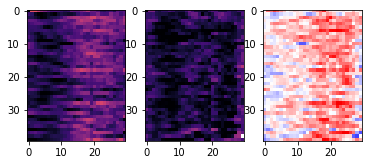

In [80]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(np.nanmean(ctrl_mu, axis=0), vmin = 1, vmax = 2, cmap='magma')
ax[1].imshow(np.nanmean(ko_mu, axis=0), vmin = 1, vmax = 2, cmap='magma')
ax[2].imshow(np.nanmean(ctrl_mu, axis=0) - np.nanmean(ko_mu, axis=0), cmap='seismic', vmin=-1, vmax = 1)

<ipython-input-81-336e5a105740>:6: RuntimeWarning: Mean of empty slice
  mu, sem = ar.mu_sem(np.nanmean(ko_mu, axis=0))


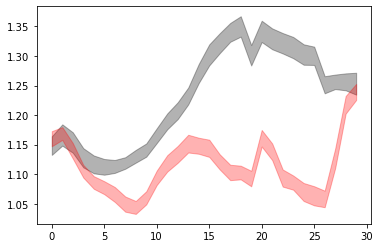

In [81]:
fig, ax = plt.subplots(sharey = True)
x = np.arange(30)
mu, sem = ar.mu_sem(np.nanmean(ctrl_mu, axis=0))
ax.fill_between(x, mu-sem, mu+sem, alpha = .3, color='black')

mu, sem = ar.mu_sem(np.nanmean(ko_mu, axis=0))
ax.fill_between(x, mu-sem, mu+sem, alpha = .3, color='red')

In [51]:
t,p = sp.stats.ranksums(np.nanmean(ko_mu[:,10:],axis=-1), np.nanmean(ctrl_mu[:,10:],axis=-1))
print(t,p)

-0.5222329678670935 0.6015081344405899


In [ ]:
# plot change in activity rate as a function of position

# correlate change in activity rate with spatial information or just whether or not its a place cell (both familiar and novel)

# check raw data to make sure there's no funny business